In [2]:
# 1. 나눔 폰트 설치 명령어
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 2. 런타임 재시작 (이 메시지를 본 후 직접 실행)
print("❌ 폰트 변경을 위해 [런타임] -> [런타임 다시 시작]을 클릭하세요. 재시작 후 다음 코드 블록을 실행하세요.")

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/

# 데이터불러오기

In [1]:
''' 데이터불러오기'''

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import os

# ==============================================================================
# 0. 환경 설정 및 파일 로드 (Google Drive 경로)
# ==============================================================================
DRIVE_PATH = '/content/drive/MyDrive/bigcon/data/raw/'
FILE_1_MASTER = os.path.join(DRIVE_PATH, "big_data_set1_f.csv")
FILE_2_PERF = os.path.join(DRIVE_PATH, "big_data_set2_f.csv")
FILE_3_CUST = os.path.join(DRIVE_PATH, "big_data_set3_f.csv")
GEOCODED_FILE = os.path.join(DRIVE_PATH, "df_geocoded.csv")
MACRO_FILE = os.path.join(DRIVE_PATH, "macro_data_combined_final.csv")
Preprocessing=os.path.join(DRIVE_PATH,"df_Preprocessing.csv")

FILE_1_PRE=os.path.join(DRIVE_PATH,"df1_pre.csv")
FILE_23_PRE=os.path.join(DRIVE_PATH,"df23_pre.csv")


# MISSING_VALUE_CODE = -999999.9
# LAG_PERIOD = 3
# PREDICTION_WINDOW_MONTHS = 5
# SALES_DROP_THRESHOLD = -0.15 # 매출 급락 기준: 전월 대비 10% 하락

# 데이터 로드
try:
    df1_org = pd.read_csv(FILE_1_MASTER, encoding='cp949')
    df2_org = pd.read_csv(FILE_2_PERF, encoding='cp949')
    df3_org= pd.read_csv(FILE_3_CUST, encoding='cp949')
    df_geocoded_org = pd.read_csv(GEOCODED_FILE, encoding='utf8', index_col=0)
    combined_macro_df = pd.read_csv(MACRO_FILE, encoding='utf8')
    df_preprocessing=pd.read_csv(Preprocessing, encoding='utf8')

    df1_pre_org=pd.read_csv(FILE_1_PRE, encoding='utf8')
    df23_pre_org=pd.read_csv(FILE_23_PRE, encoding='utf8')

except Exception as e:
    raise RuntimeError(f"❌ 파일 로드 실패: {e}")

# data copy 생성
df1=df1_org.copy()
df2=df2_org.copy()
df3=df3_org.copy()
out=combined_macro_df.copy()
df=df_preprocessing.copy()
df_geocoded = df_geocoded_org.copy()

df1_pre=df1_pre_org.copy()
df23_pre=df23_pre_org.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   가맹점구분번호                86590 non-null  object 
 1   기준년월                   86590 non-null  int64  
 2   배달매출금액 비율              86590 non-null  float64
 3   동일 업종 매출금액 비율          86590 non-null  float64
 4   동일 업종 매출건수 비율          86590 non-null  float64
 5   동일 업종 내 매출 순위 비율       86590 non-null  float64
 6   동일 상권 내 매출 순위 비율       86590 non-null  float64
 7   동일 업종 내 해지 가맹점 비중      86590 non-null  float64
 8   동일 상권 내 해지 가맹점 비중      86590 non-null  float64
 9   남성 20대이하 고객 비중         86590 non-null  float64
 10  남성 30대 고객 비중           86590 non-null  float64
 11  남성 40대 고객 비중           86590 non-null  float64
 12  남성 50대 고객 비중           86590 non-null  float64
 13  남성 60대이상 고객 비중         86590 non-null  float64
 14  여성 20대이하 고객 비중         86590 non-null  float64
 15  여성

y 값 정의

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumBarunGothic' # 한글 폰트 설정 가정
plt.rcParams['axes.unicode_minus'] = False

# ⚠️ 폰트 설정 재확인 (NanumBarunGothic으로 확정)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 상수 정의
SALES_DROP_THRESHOLD = -0.20
PREDICTION_WINDOW_MONTHS = 3
ID_COL = '가맹점구분번호'
SALES_COL = '동일 업종 매출금액 비율'

# A. CRISIS_SALES_DROP (Soft Crisis, Y1) 정의
print("⚠️ CRISIS_SALES_DROP (매출 15% 급락, 3개월) 재정의 시작...")

drop_rates = []
current_shift_col = SALES_COL

for i in range(1, PREDICTION_WINDOW_MONTHS + 1):
    df[f'NEXT_M{i}_SAA'] = df.groupby(ID_COL)[SALES_COL].shift(-i)

    # 전월 대비 변화율 계산
    # 다음 달 매출 - 현재 월 매출 / 현재 월 매출
    df[f'DROP_RATE_M{i}'] = (df[f'NEXT_M{i}_SAA'] - df[current_shift_col]) / (df[current_shift_col] + 1e-6)
    drop_rates.append(df[f'DROP_RATE_M{i}'] < SALES_DROP_THRESHOLD)

    # 다음 반복을 위해 현재 컬럼 업데이트 (다음 달 매출 대비로 변경하여 연속 급락 방지)
    current_shift_col = f'NEXT_M{i}_SAA'

# Y1: 다음 5개월 중 어느 한 달이라도 15% 이상 급락한 경우
df['CRISIS_SALES_DROP'] = pd.concat(drop_rates, axis=1).any(axis=1).astype(int)

# B. IS_CLOSED (Hard Closure, Y2) 정의
# '폐업일' 컬럼이 df_geocoded에서 combined_df를 거쳐 df에 복사되어 있다고 가정
df['IS_CLOSED'] = df['폐업일'].notna().astype(int)

# 임시 컬럼 정리
drop_cols = [col for col in df.columns if col.startswith('NEXT_M') or col.startswith('DROP_RATE')]
df = df.drop(columns=drop_cols, errors='ignore')

# C. 상권 결측치 임시 처리 (EDA 시각화 대비)
BZN_COL = '상권'
df[BZN_COL] = df[BZN_COL].fillna(f'{BZN_COL}_미분류')

print(f"✅ CRISIS_SALES_DROP 재정의 완료. (Y1 사례 수: {df['CRISIS_SALES_DROP'].sum()})")
print(f"✅ IS_CLOSED (Hard Closure) 변수 생성 완료. (Y2 사례 수: {df['IS_CLOSED'].sum()})")


⚠️ CRISIS_SALES_DROP (매출 15% 급락, 3개월) 재정의 시작...
✅ CRISIS_SALES_DROP 재정의 완료. (Y1 사례 수: 44430)
✅ IS_CLOSED (Hard Closure) 변수 생성 완료. (Y2 사례 수: 2334)


# df의 폐업일?

df1의 폐업일이 20230913~

데이터 전처리 과정 중 '24년 매출 기준 국세청 데이터를 '25 하반기 카드사 가맹점 정보와 매칭 과정에서 폐업된 가맹점은 제외되어 산출됩니다.따라서 데이터 분석은 주어진 '23.1~'24.12 데이터를 기반으로 '25.7월 이후 가맹점이 어려워지는 순간(폐업, 매출 급락) 을 감지할 수 있는 'AI 조기 경보 시스템'을 제안해주시면 됩니다.



In [ ]:
df1_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   가맹점구분번호       4185 non-null   object 
 1   가맹점주소         4185 non-null   object 
 2   가맹점명          4185 non-null   object 
 3   업종            4185 non-null   object 
 4   상권            4185 non-null   object 
 5   개설일           4185 non-null   object 
 6   폐업일           127 non-null    object 
 7   LAT           4185 non-null   float64
 8   LNG           4185 non-null   float64
 9   브랜드구분코드_FREQ  4185 non-null   float64
dtypes: float64(3), object(7)
memory usage: 327.1+ KB


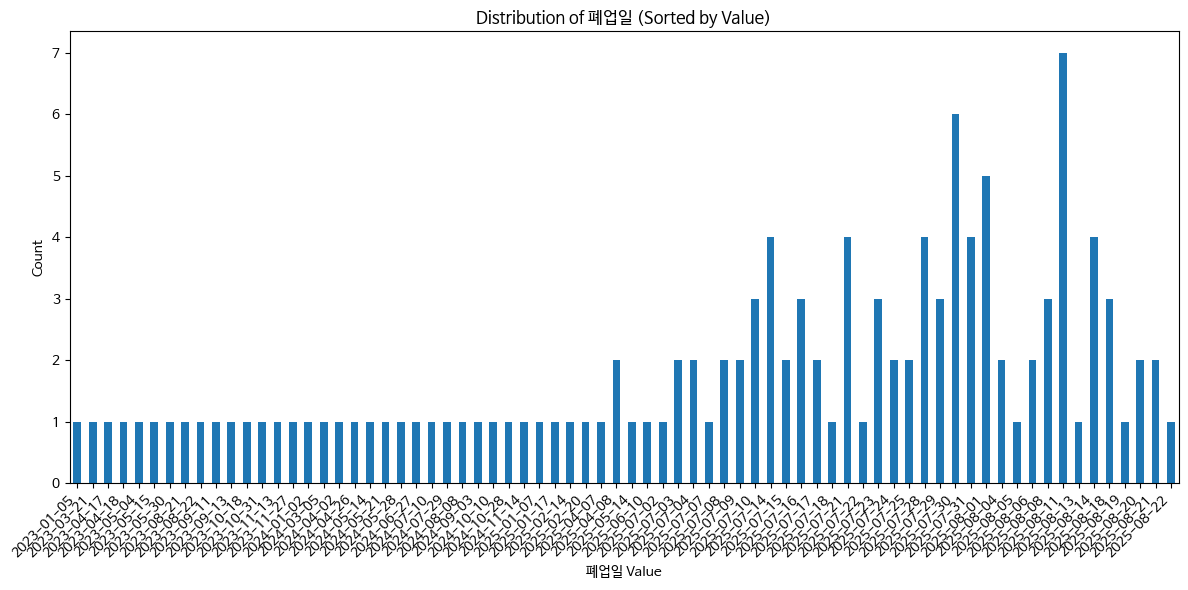

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# value_counts() 결과를 내림차순으로 정렬하여 그래프로 시각화
plt.figure(figsize=(12, 6))
df1_pre['폐업일'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of 폐업일 (Sorted by Value)')
plt.xlabel('폐업일 Value')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df1_pre

가맹점구분번호                가맹점주소          가맹점명        업종   상권  \
0     16184E93D9           서울 성동구 마장동          성우**       축산물  마장동   
1     4D039EA8B7           서울 성동구 마장동          대보**       축산물  마장동   
2     0074C4990A           서울 성동구 마장동          대용**       축산물  마장동   
3     68308F2746           서울 성동구 마장동          통일**       축산물  마장동   
4     4117EDDE9C           서울 성동구 마장동          한울**       축산물  마장동   
...          ...                  ...           ...       ...  ...   
4180  7FCF23E6F3    서울특별시 성동구 마장로 137  아이**********  아이스크림/빙수  왕십리   
4181  9743B78531      서울 성동구 독서당로 223          어반**        양식   옥수   
4182  C2261977A8  서울특별시 성동구 마장로35길 76          한성**       축산물  마장동   
4183  F1C69918DF      서울 성동구 왕십리로 410          국수**  한식-국수/만두  왕십리   
4184  58B8C943BF     서울특별시 성동구 매봉길 50      아이******  아이스크림/빙수   옥수   

             개설일  폐업일        LAT         LNG  브랜드구분코드_FREQ  
0     2013-03-20  NaN  37.566380  127.045326      0.870490  
1     2013-11-22  NaN  37.566380  127.045326      0.870490  
2     2014-05-12  NaN  37.566380  127.045326      0.870490  
3     2015-11-24  NaN  37.566380  127.045326      0.870490  
4     2015-12-11  NaN  37.566380  127.045326      0.870490  
...          ...  ...        ...         ...           ...  
4180  2023-08-21  NaN  37.567825  127.025054      0.870490  
4181  2013-03-05  NaN  37.544271  127.015192      0.870490  
4182  2023-05-17  NaN  37.570263  127.041997      0.870490  
4183  2021-10-07  NaN  37.566603  127.024082      0.000478  
4184  2023-03-03  NaN  37.547299  127.012189      0.870490  

[4185 rows x 10 columns]

/tmp/ipython-input-2180674308.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=monthly_closure_counts, x='폐업일', y='Count', palette='viridis')


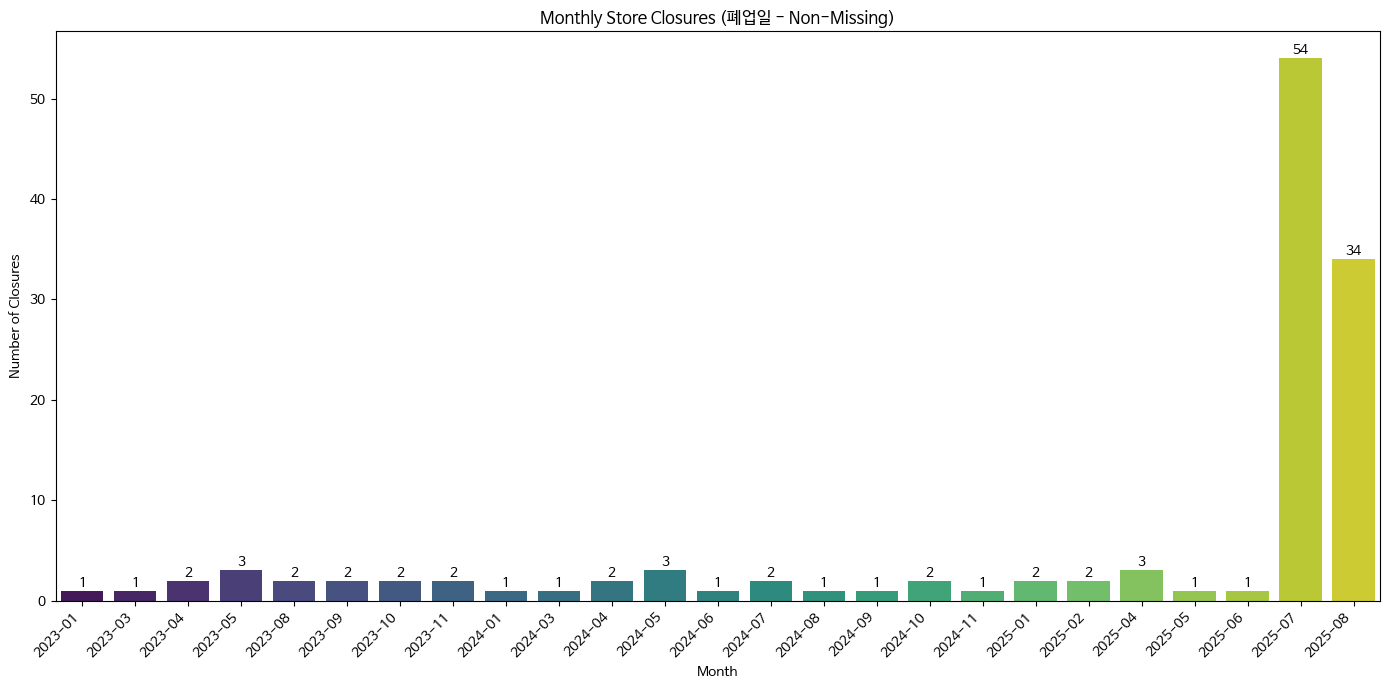

127

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 폐업일 컬럼에서 결측치가 아닌 행만 선택
non_missing_closure_dates = df1_pre.dropna(subset=['폐업일']).copy()

# 폐업일 값을 날짜 형식으로 변환
# '폐업일' 컬럼이 object 타입 문자열이므로 바로 to_datetime 사용
non_missing_closure_dates['폐업일'] = pd.to_datetime(non_missing_closure_dates['폐업일'], errors='coerce')

# 유효한 날짜만 필터링
non_missing_closure_dates = non_missing_closure_dates.dropna(subset=['폐업일'])

# 월별 폐업 카운트 집계
monthly_closure_counts = non_missing_closure_dates.groupby(non_missing_closure_dates['폐업일'].dt.to_period('M')).size().reset_index(name='Count')
monthly_closure_counts['폐업일'] = monthly_closure_counts['폐업일'].astype(str) # 시각화를 위해 문자열로 변환

# 월별 막대 그래프 시각화
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=monthly_closure_counts, x='폐업일', y='Count', palette='viridis')

# 그래프에 개수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title('Monthly Store Closures (폐업일 - Non-Missing)')
plt.xlabel('Month')
plt.ylabel('Number of Closures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(len(non_missing_closure_dates))

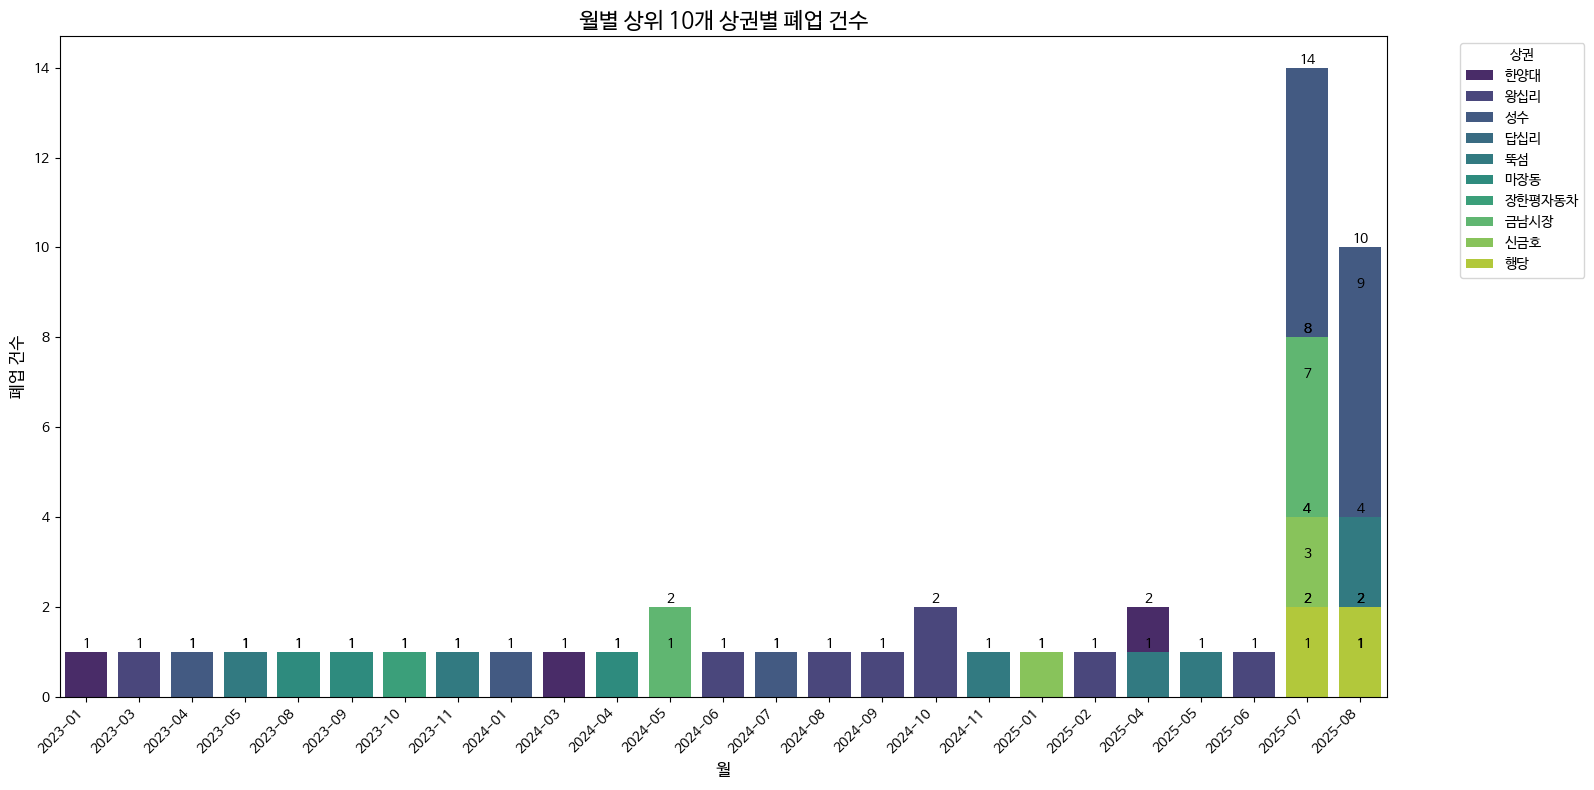

'총 폐업 데이터 건수: 127'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# ⚠️ Colab에서 한글 폰트가 깨지지 않도록 설정하는 코드
# 아래 코드를 실행한 뒤, 런타임 → '런타임 다시 시작'을 꼭 해주세요!
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv > /dev/null
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 폐업일 컬럼에서 결측치가 아닌 행만 선택
non_missing_closure_dates = df1_pre.dropna(subset=['폐업일']).copy()

# 폐업일 값을 날짜 형식으로 변환
non_missing_closure_dates['폐업일'] = pd.to_datetime(non_missing_closure_dates['폐업일'], errors='coerce')

# 유효한 날짜만 필터링
non_missing_closure_dates = non_missing_closure_dates.dropna(subset=['폐업일'])

# 월별 및 상권별 폐업 카운트 집계
monthly_bzn_closure_counts = non_missing_closure_dates.groupby([non_missing_closure_dates['폐업일'].dt.to_period('M'), '상권']).size().reset_index(name='Count')
monthly_bzn_closure_counts['폐업일'] = monthly_bzn_closure_counts['폐업일'].astype(str) # 시각화를 위해 문자열로 변환

# 상위 N개 상권 선택 (예: 상위 10개)
top_n_bzns = monthly_bzn_closure_counts['상권'].value_counts().nlargest(10).index
monthly_bzn_closure_counts_top = monthly_bzn_closure_counts[monthly_bzn_closure_counts['상권'].isin(top_n_bzns)]

# 월별 상권별 누적 막대 그래프 시각화
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=monthly_bzn_closure_counts_top, x='폐업일', y='Count', hue='상권', dodge=False, palette='viridis')

# 그래프에 개수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title('월별 상위 10개 상권별 폐업 건수', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('폐업 건수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='상권', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

display(f"총 폐업 데이터 건수: {len(non_missing_closure_dates)}")

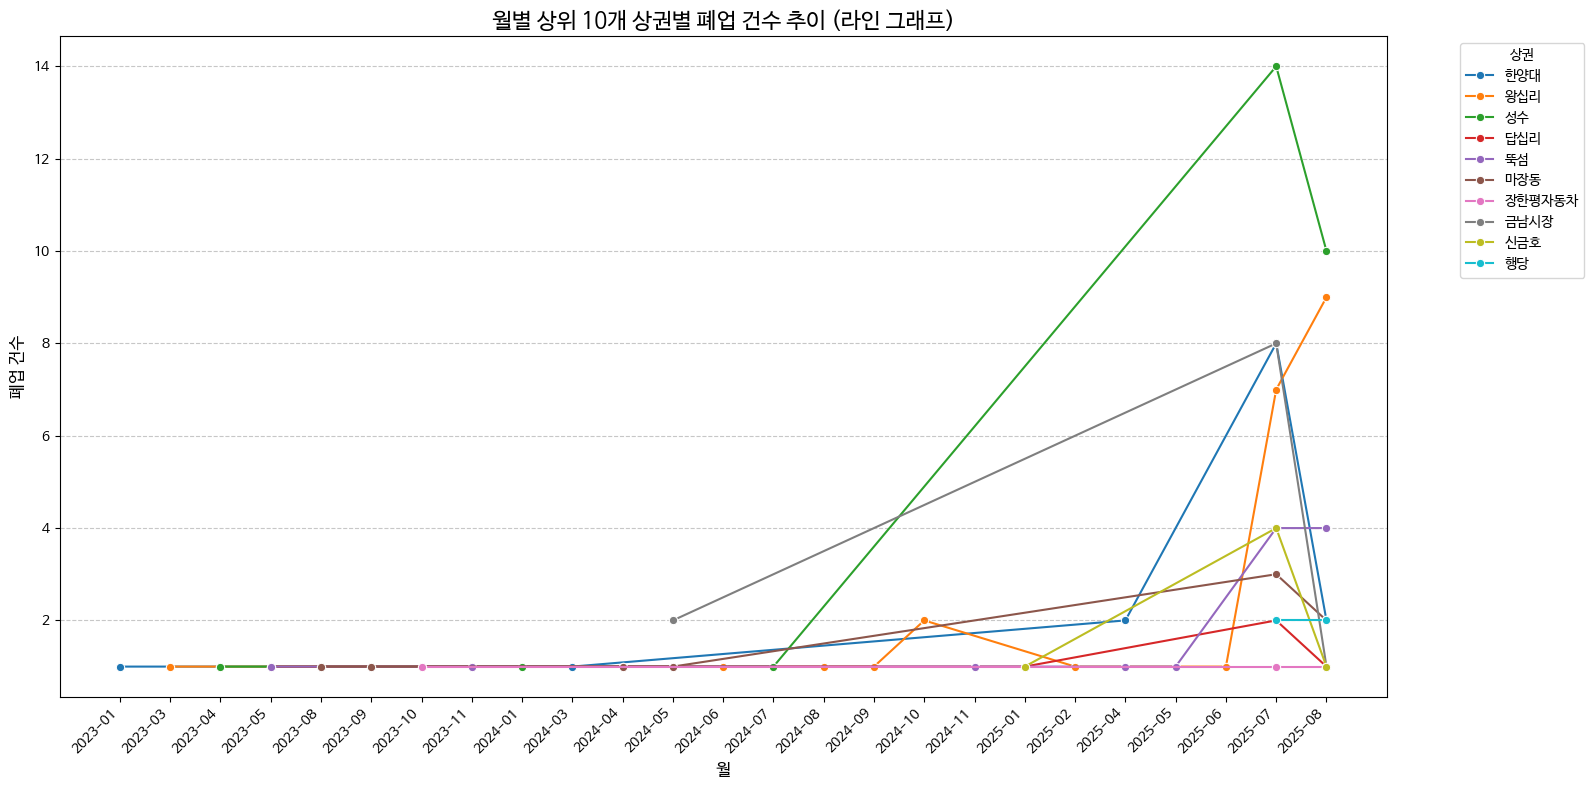

'총 폐업 데이터 건수: 127'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# ⚠️ Colab에서 한글 폰트가 깨지지 않도록 설정하는 코드
# # 아래 코드를 실행한 뒤, 런타임 → '런타임 다시 시작'을 꼭 해주세요!
# !sudo apt-get install -y fonts-nanum > /dev/null
# !sudo fc-cache -fv > /dev/null
# !rm ~/.cache/matplotlib -rf

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 폐업일 컬럼에서 결측치가 아닌 행만 선택
non_missing_closure_dates = df1_pre.dropna(subset=['폐업일']).copy()

# 폐업일 값을 날짜 형식으로 변환
non_missing_closure_dates['폐업일'] = pd.to_datetime(non_missing_closure_dates['폐업일'], errors='coerce')

# 유효한 날짜만 필터링
non_missing_closure_dates = non_missing_closure_dates.dropna(subset=['폐업일'])

# 월별 및 상권별 폐업 카운트 집계
monthly_bzn_closure_counts = non_missing_closure_dates.groupby([non_missing_closure_dates['폐업일'].dt.to_period('M'), '상권']).size().reset_index(name='Count')
monthly_bzn_closure_counts['폐업일'] = monthly_bzn_closure_counts['폐업일'].astype(str) # 시각화를 위해 문자열로 변환

# 상위 N개 상권 선택 (예: 상위 10개)
top_n_bzns = monthly_bzn_closure_counts['상권'].value_counts().nlargest(10).index
monthly_bzn_closure_counts_top = monthly_bzn_closure_counts[monthly_bzn_closure_counts['상권'].isin(top_n_bzns)]

# 월별 상권별 라인 그래프 시각화
plt.figure(figsize=(16, 8))
sns.lineplot(data=monthly_bzn_closure_counts_top, x='폐업일', y='Count', hue='상권', marker='o')

plt.title('월별 상위 10개 상권별 폐업 건수 추이 (라인 그래프)', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('폐업 건수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='상권', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

display(f"총 폐업 데이터 건수: {len(non_missing_closure_dates)}")

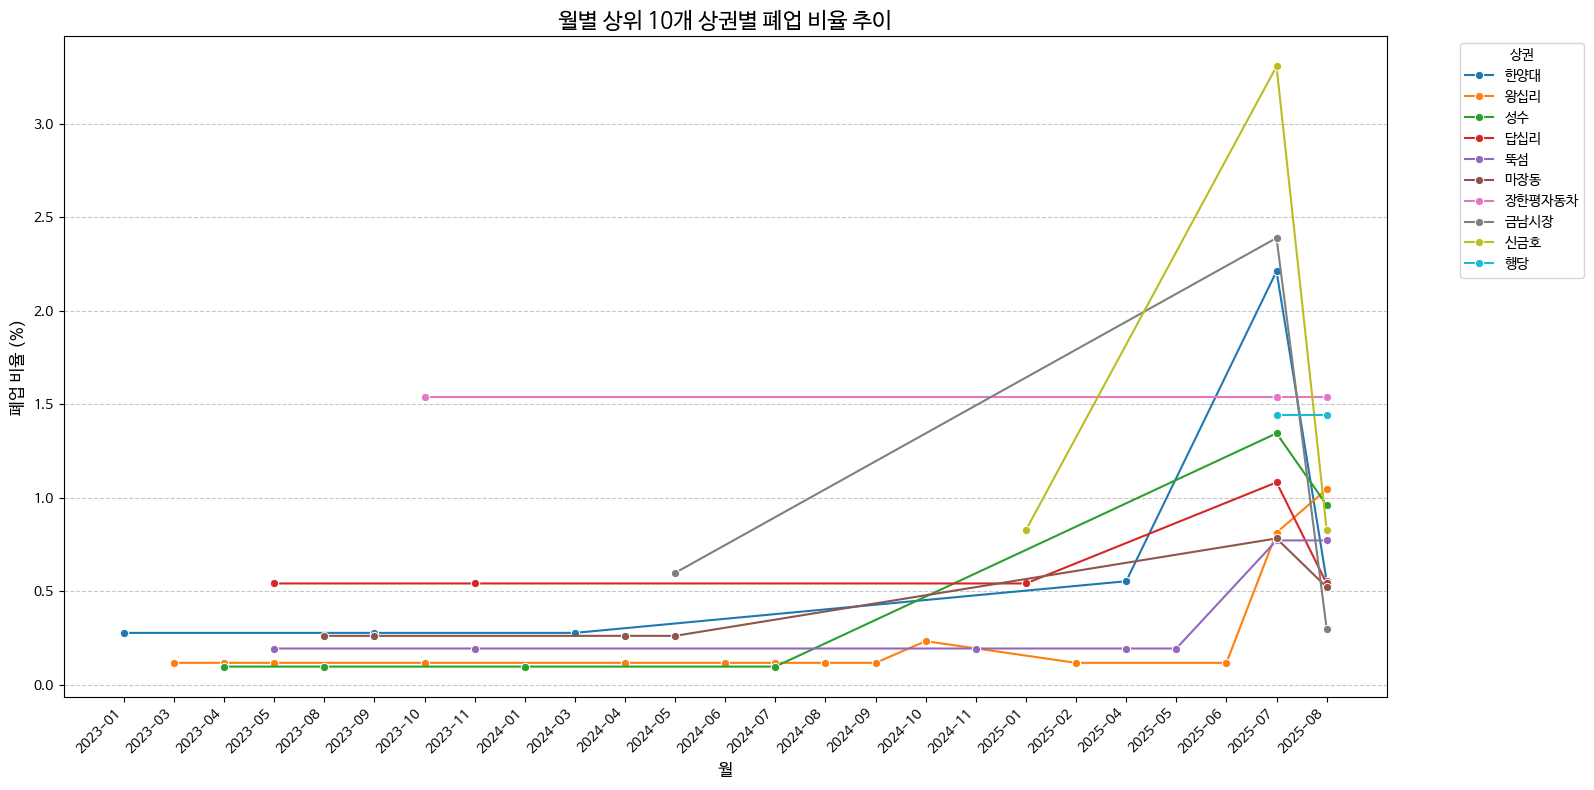

'총 폐업 데이터 건수: 127'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# ⚠️ Colab에서 한글 폰트가 깨지지 않도록 설정하는 코드
# # 아래 코드를 실행한 뒤, 런타임 → '런타임 다시 시작'을 꼭 해주세요!
# !sudo apt-get install -y fonts-nanum > /dev/null
# !sudo fc-cache -fv > /dev/null
# !rm ~/.cache/matplotlib -rf

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 폐업일 컬럼에서 결측치가 아닌 행만 선택
non_missing_closure_dates = df1_pre.dropna(subset=['폐업일']).copy()

# 폐업일 값을 날짜 형식으로 변환
non_missing_closure_dates['폐업일'] = pd.to_datetime(non_missing_closure_dates['폐업일'], errors='coerce')

# 유효한 날짜만 필터링
non_missing_closure_dates = non_missing_closure_dates.dropna(subset=['폐업일'])

# 월별 및 상권별 폐업 카운트 집계
monthly_bzn_closure_counts = non_missing_closure_dates.groupby([non_missing_closure_dates['폐업일'].dt.to_period('M'), '상권']).size().reset_index(name='Closure_Count')

# 각 상권별 전체 가맹점 수를 계산 (df1_pre 기준)
bzn_total_stores = df1_pre['상권'].value_counts().reset_index(name='Total_Stores')
bzn_total_stores.rename(columns={'index': '상권'}, inplace=True)

# 월별 상권별 폐업 데이터에 전체 상점 수 병합
monthly_bzn_closure_counts = pd.merge(monthly_bzn_closure_counts, bzn_total_stores, on='상권', how='left')

# 폐업 비율 계산
monthly_bzn_closure_counts['Closure_Rate'] = (monthly_bzn_closure_counts['Closure_Count'] / monthly_bzn_closure_counts['Total_Stores']) * 100

# 시각화를 위해 '폐업일'을 문자열로 변환
monthly_bzn_closure_counts['폐업일_str'] = monthly_bzn_closure_counts['폐업일'].astype(str)

# 상위 N개 상권 선택 (폐업 건수 기준 상위 10개)
top_n_bzns = monthly_bzn_closure_counts.groupby('상권')['Closure_Count'].sum().nlargest(10).index
monthly_bzn_closure_counts_top = monthly_bzn_closure_counts[monthly_bzn_closure_counts['상권'].isin(top_n_bzns)]

# 월별 상권별 라인 그래프 시각화 (모든 상권을 한 그래프에)
plt.figure(figsize=(16, 8))
sns.lineplot(data=monthly_bzn_closure_counts_top, x='폐업일_str', y='Closure_Rate', hue='상권', marker='o')

plt.title('월별 상위 10개 상권별 폐업 비율 추이', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('폐업 비율 (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='상권', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례로 상권 구분
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

display(f"총 폐업 데이터 건수: {len(non_missing_closure_dates)}")

# df 2,3 시계열 시각화

In [4]:
df1_eda=df1_pre.copy()
df23_eda=df23_pre.copy()

In [5]:
df1_eda['폐업여부'] = df1_eda['폐업일'].notna().astype(int)

In [7]:
df1_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   가맹점구분번호       4185 non-null   object 
 1   가맹점주소         4185 non-null   object 
 2   가맹점명          4185 non-null   object 
 3   업종            4185 non-null   object 
 4   상권            4185 non-null   object 
 5   개설일           4185 non-null   object 
 6   폐업일           127 non-null    object 
 7   LAT           4185 non-null   float64
 8   LNG           4185 non-null   float64
 9   브랜드구분코드_FREQ  4185 non-null   float64
 10  폐업여부          4185 non-null   int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 359.8+ KB


In [8]:
df23_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   가맹점구분번호                86590 non-null  object 
 1   기준년월                   86590 non-null  object 
 2   배달매출금액 비율              86590 non-null  float64
 3   동일 업종 매출금액 비율          86590 non-null  float64
 4   동일 업종 매출건수 비율          86590 non-null  float64
 5   동일 업종 내 매출 순위 비율       86590 non-null  float64
 6   동일 상권 내 매출 순위 비율       86590 non-null  float64
 7   동일 업종 내 해지 가맹점 비중      86590 non-null  float64
 8   동일 상권 내 해지 가맹점 비중      86590 non-null  float64
 9   남성 20대이하 고객 비중         86590 non-null  float64
 10  남성 30대 고객 비중           86590 non-null  float64
 11  남성 40대 고객 비중           86590 non-null  float64
 12  남성 50대 고객 비중           86590 non-null  float64
 13  남성 60대이상 고객 비중         86590 non-null  float64
 14  여성 20대이하 고객 비중         86590 non-null  float64
 15  여성

In [10]:
# 기준년월 → datetime 형식 변환 (그래프 축 정렬용)
df23_eda['기준년월'] = pd.to_datetime(df23_eda['기준년월'], format='mixed')

# 두 데이터 병합
# df_merged = pd.merge(df23_eda, df1_eda[['가맹점구분번호', '폐업여부']], on='가맹점구분번호', how='left')


# 기준 키: 가맹점구분번호
# df1_eda: 점포 마스터(주소, 상권, 업종, 폐업여부 등)
# df23_eda: 월별 매출 및 고객 비율 지표

df_merged = pd.merge(
    df23_eda,
    df1_eda,   # 전체 칼럼 다 포함
    on='가맹점구분번호',
    how='left'   # df23 기준으로 병합 (월별 데이터 보존)
)


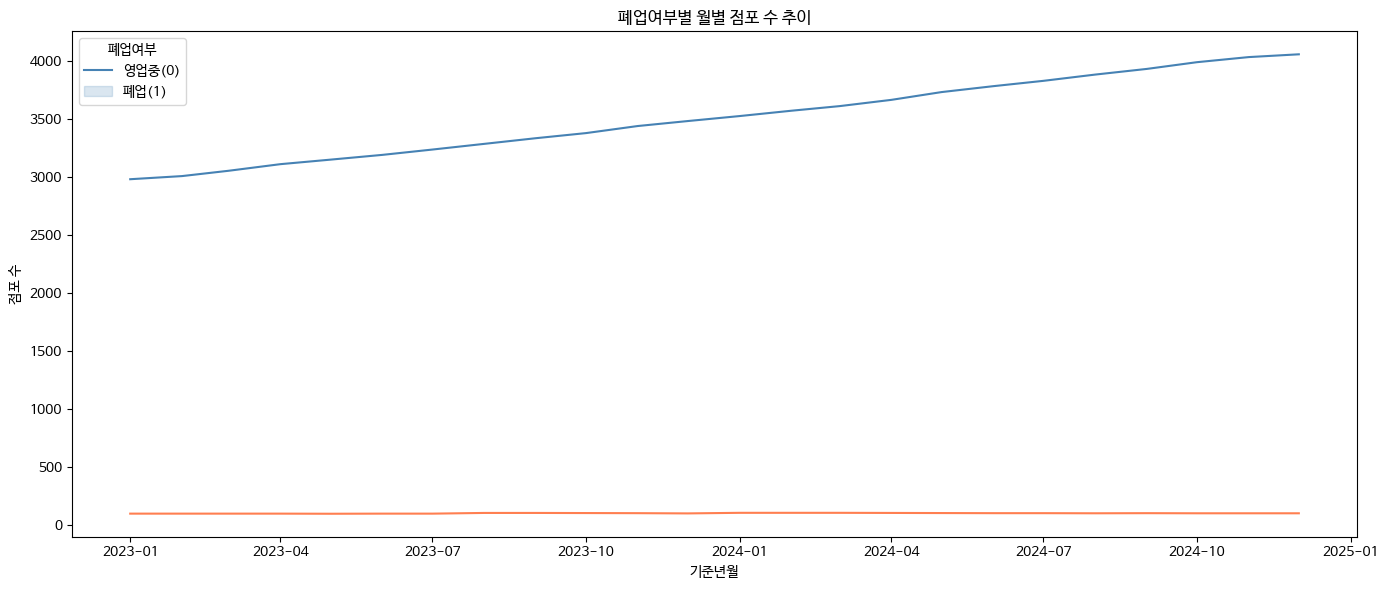

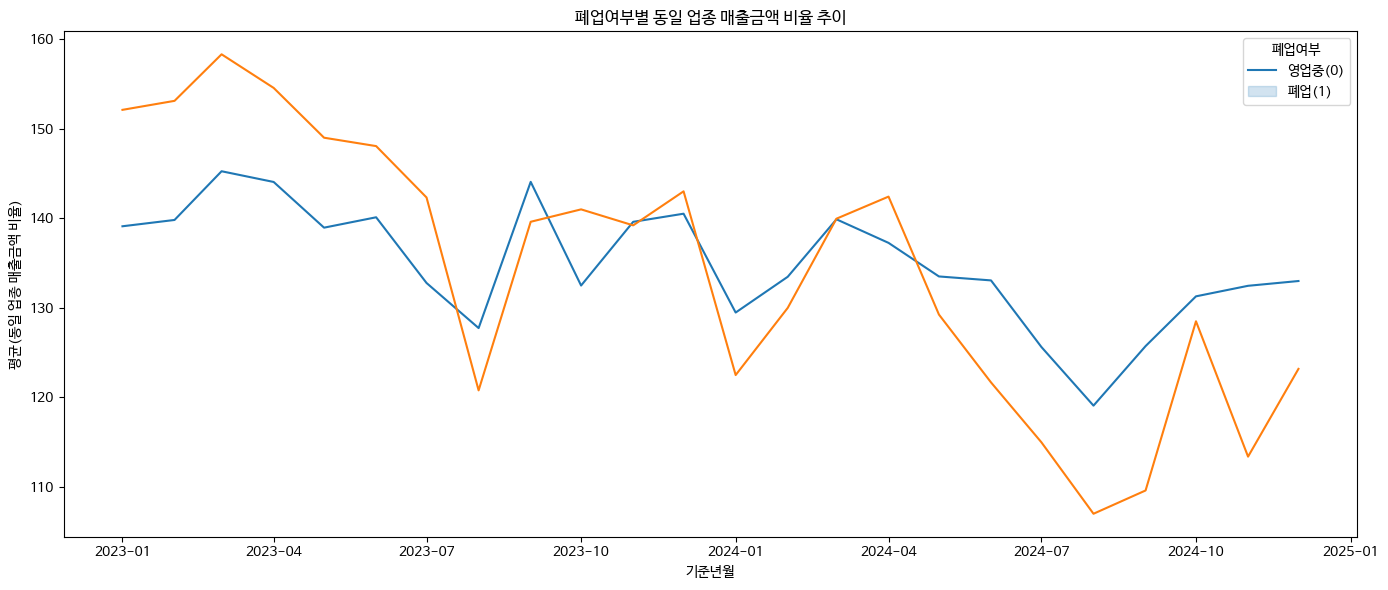

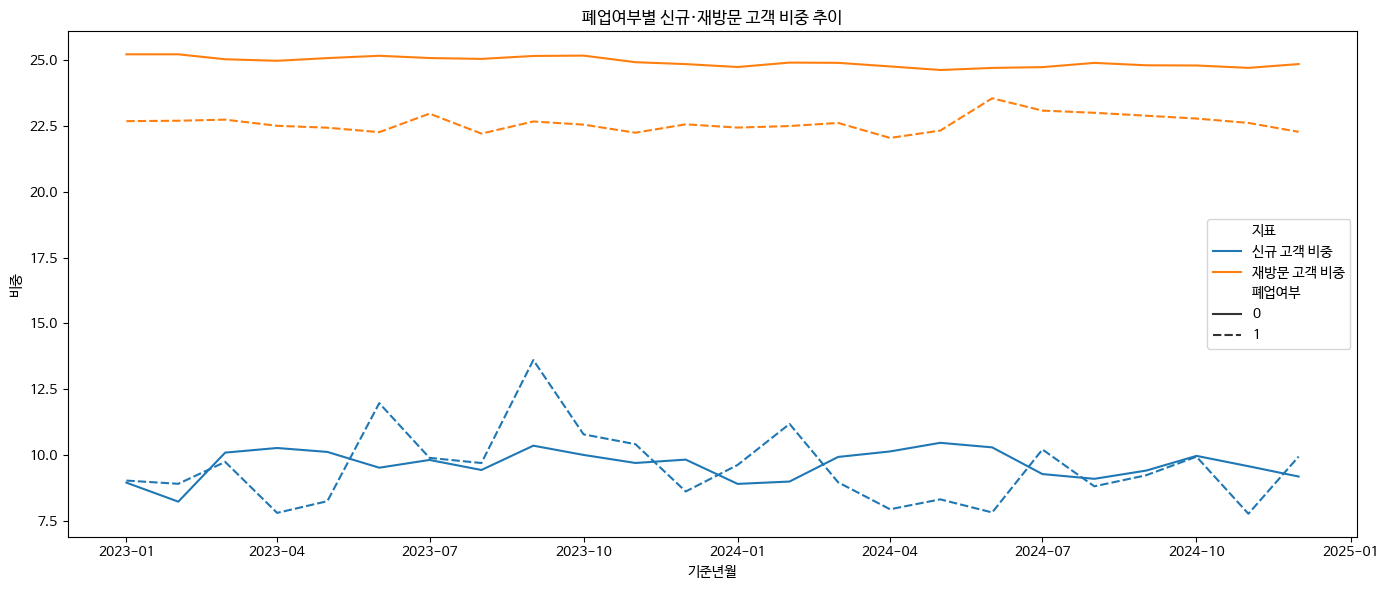

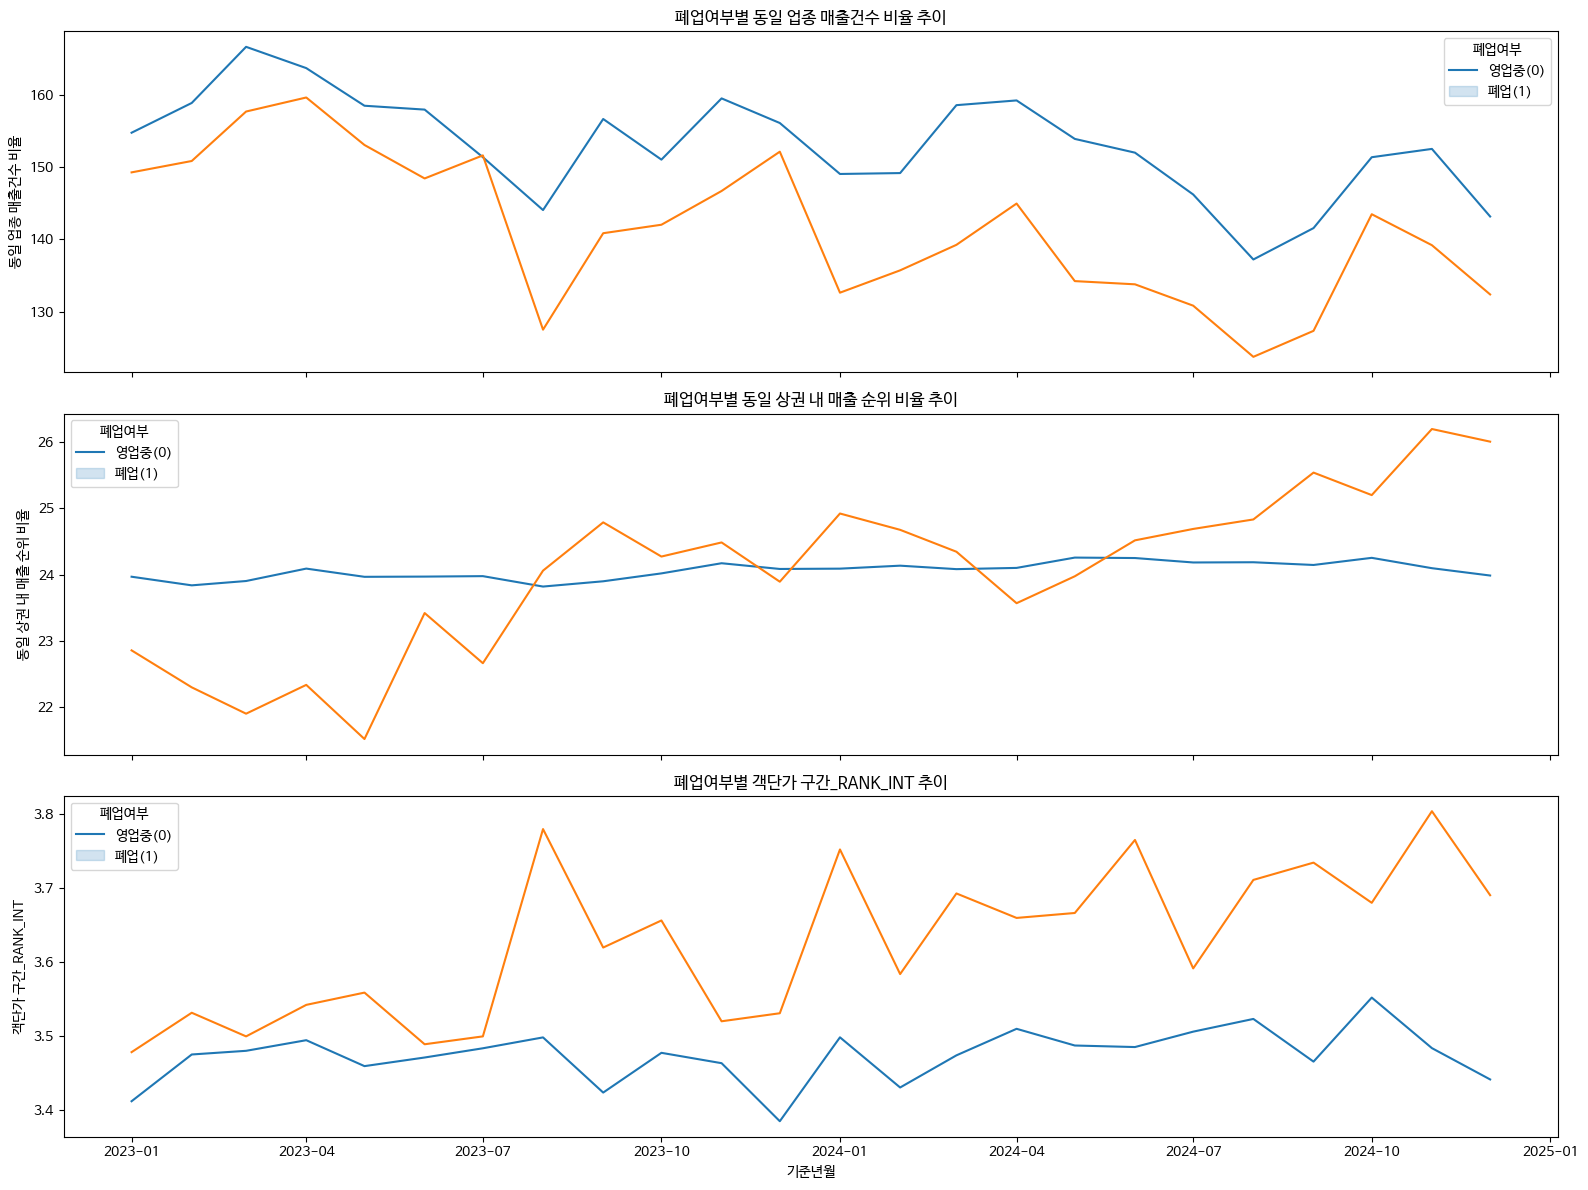

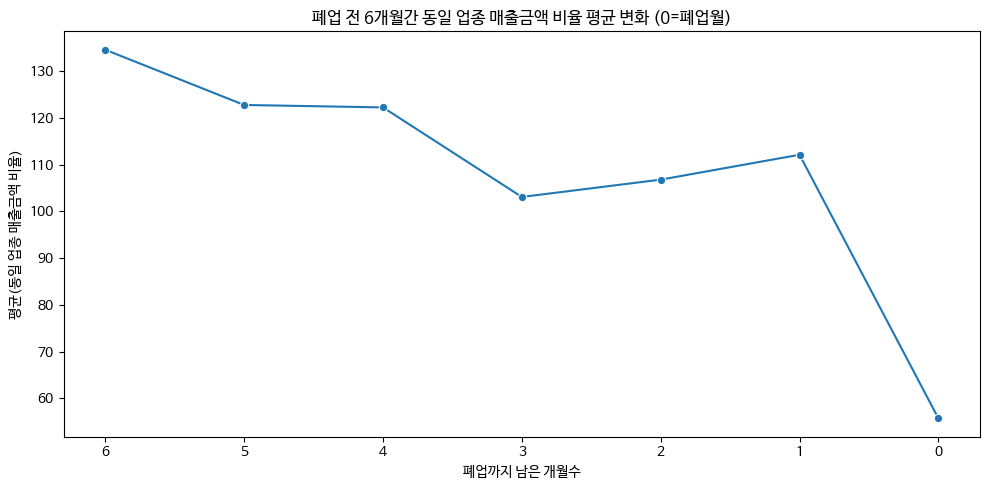

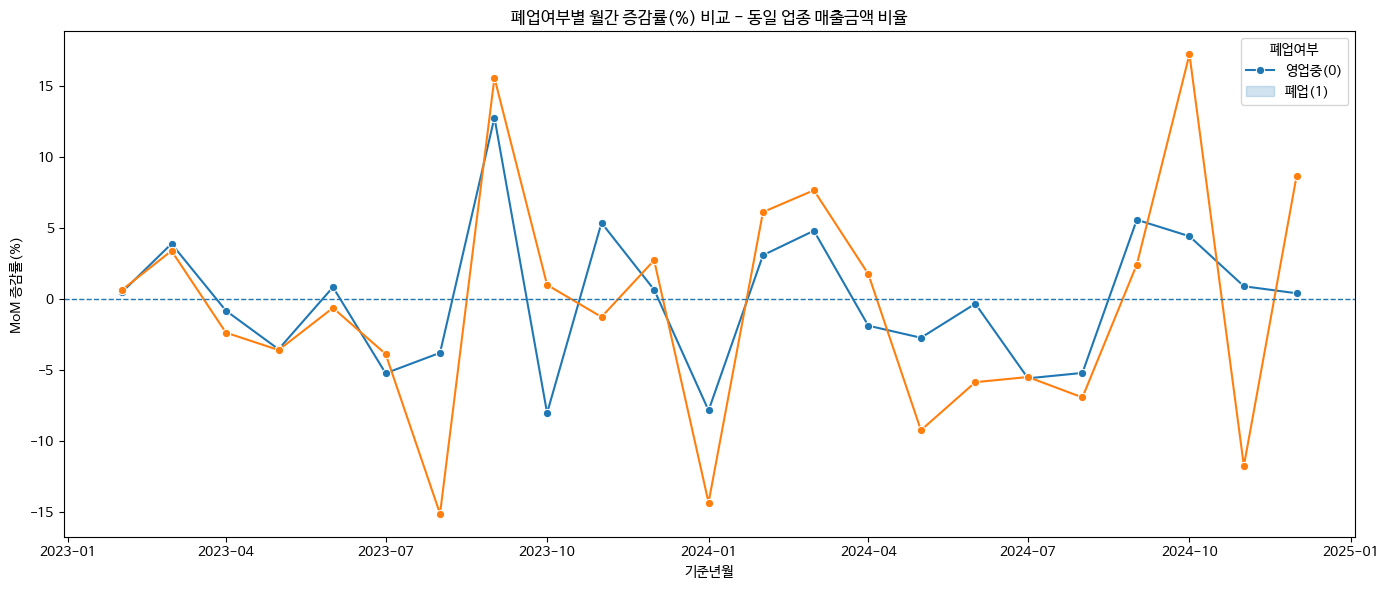

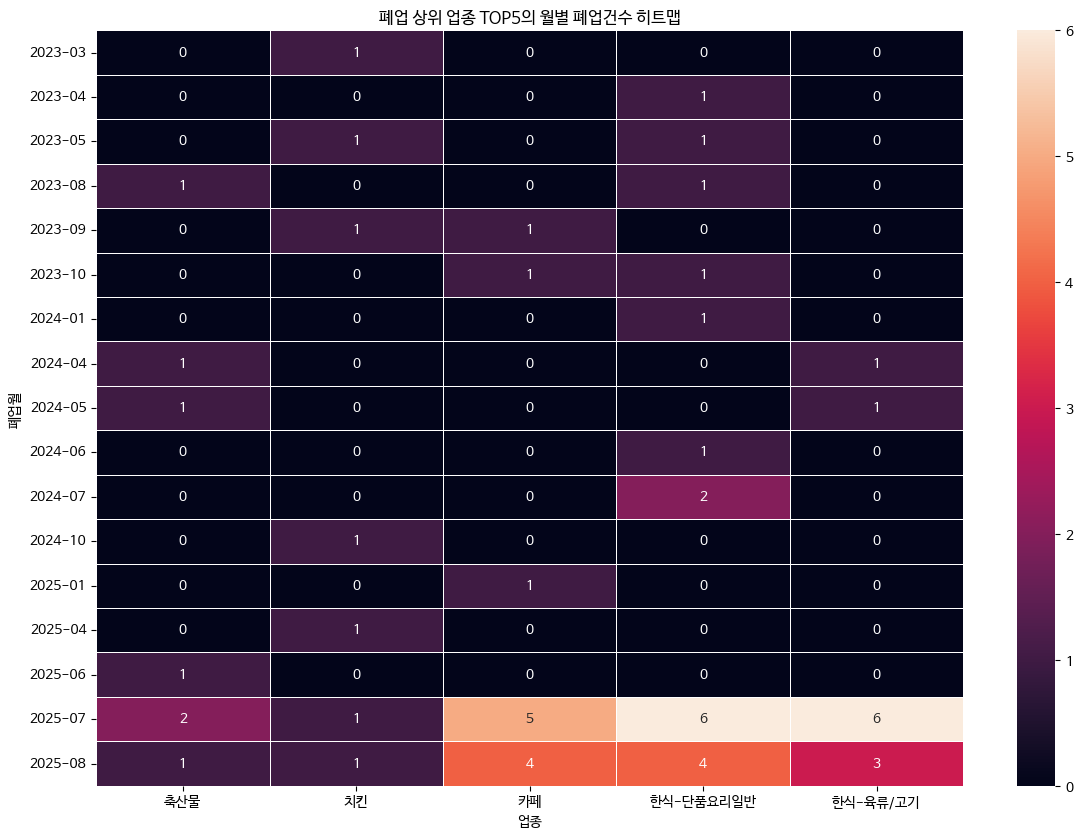

In [21]:
# -----------------------------------------------------------------------------
# 목적
# - df_merged(월별 패널 + 점포 마스터 + 폐업여부/폐업일) 기반으로
#   1) 폐업여부별 월별 점포 수 추이
#   2) 폐업여부별 '동일 업종 매출금액 비율' 추세
#   3) 폐업여부별 신규/재방문 고객 비중 추세
#   4) 주요 지표(예: 매출건수비율, 상권내순위비율, 객단가랭크) 다중 서브플롯
#   5) 폐업 전 N(기본 6)개월 전조 추세 (예: 동일 업종 매출금액 비율)
#   6) 영업 지속(0) vs 폐업(1) 집단의 '월간 증감률' 비교
#   7) '폐업 상위 업종 TOP5'의 월별 폐업건수 히트맵
#
# 전제
# - df_merged에 다음 컬럼들이 존재한다고 가정:
#   ['가맹점구분번호','기준년월','폐업여부','폐업일','업종',
#    '동일 업종 매출금액 비율','신규 고객 비중','재방문 고객 비중',
#    '동일 업종 매출건수 비율','동일 상권 내 매출 순위 비율','객단가 구간_RANK_INT']
# - '기준년월'은 문자열(YYYY-MM / YYYY-MM-DD 등)일 수 있으므로 안전하게 datetime으로 변환
# - '폐업여부'는 0/1의 정수
# - '폐업일'은 문자열 날짜(또는 NaN)
#
# 사용 라이브러리: pandas, numpy, matplotlib, seaborn
# -----------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (옵션) 한글 폰트 설정 - 환경에 따라 주석 처리/변경하세요.
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


# 0) 공통 전처리: 기준년월/폐업일 안전 파싱 ---------------------------------------
df = df_merged.copy()

# 기준년월 정규화(혼합 포맷 대비)
s = df['기준년월'].astype(str).str.strip()
s = s.str.replace(r'^(\d{4}-\d{2})-\d{2}$', r'\1', regex=True)   # YYYY-MM-DD -> YYYY-MM
s = s.str.replace(r'^(\d{4})/(\d{2})$', r'\1-\2', regex=True)    # YYYY/MM -> YYYY-MM
s = s.str.replace(r'^(\d{4})(\d{2})$', r'\1-\2', regex=True)     # YYYYMM -> YYYY-MM
s = s.str.replace(r'^(\d{4})(\d{2})(\d{2})$', r'\1-\2', regex=True)  # YYYYMMDD -> YYYY-MM
df['기준년월'] = pd.to_datetime(s, format='%Y-%m', errors='coerce')

# 폐업일 파싱(폐업점포만 의미 있음)
if '폐업일' in df.columns:
    df['폐업일_dt'] = pd.to_datetime(df['폐업일'], errors='coerce')
else:
    df['폐업일_dt'] = pd.NaT

# 1) 폐업여부별 월별 '점포 수' 추이 ---------------------------------------------
tp_cnt = (
    df.groupby(['기준년월','폐업여부'])['가맹점구분번호']
      .nunique()
      .reset_index(name='가맹점수')
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tp_cnt, x='기준년월', y='가맹점수', hue='폐업여부', palette=['steelblue','coral'])
plt.title('폐업여부별 월별 점포 수 추이')
plt.ylabel('점포 수'); plt.xlabel('기준년월')
plt.legend(title='폐업여부', labels=['영업중(0)','폐업(1)'])
plt.tight_layout()
plt.show()

# 2) 폐업여부별 '동일 업종 매출금액 비율' 추이 -----------------------------------
if '동일 업종 매출금액 비율' in df.columns:
    avg_sales = (
        df.groupby(['기준년월','폐업여부'])['동일 업종 매출금액 비율']
          .mean()
          .reset_index()
    )
    plt.figure(figsize=(14,6))
    sns.lineplot(data=avg_sales, x='기준년월', y='동일 업종 매출금액 비율', hue='폐업여부')
    plt.title('폐업여부별 동일 업종 매출금액 비율 추이')
    plt.ylabel('평균(동일 업종 매출금액 비율)'); plt.xlabel('기준년월')
    plt.legend(title='폐업여부', labels=['영업중(0)','폐업(1)'])
    plt.tight_layout()
    plt.show()

# 3) 폐업여부별 '신규/재방문 고객 비중' 추이 -------------------------------------
need_cols = {'신규 고객 비중','재방문 고객 비중'}
if need_cols.issubset(df.columns):
    cust_trend = (
        df.groupby(['기준년월','폐업여부'])[['신규 고객 비중','재방문 고객 비중']]
          .mean()
          .reset_index()
          .melt(id_vars=['기준년월','폐업여부'], var_name='지표', value_name='비중')
    )

    plt.figure(figsize=(14,6))
    sns.lineplot(data=cust_trend, x='기준년월', y='비중', hue='지표', style='폐업여부')
    plt.title('폐업여부별 신규·재방문 고객 비중 추이')
    plt.xlabel('기준년월'); plt.ylabel('비중')
    plt.tight_layout()
    plt.show()

# 4) 주요 지표 다중 서브플롯 -----------------------------------------------------
metrics = [
    '동일 업종 매출건수 비율',
    '동일 상권 내 매출 순위 비율',
    '객단가 구간_RANK_INT'
]
metrics = [m for m in metrics if m in df.columns]  # 실제 존재하는 컬럼만 사용

if metrics:
    n = len(metrics)
    fig, axes = plt.subplots(n, 1, figsize=(16, 4*n), sharex=True)
    if n == 1:
        axes = [axes]
    for ax, m in zip(axes, metrics):
        avg_m = (
            df.groupby(['기준년월','폐업여부'])[m]
              .mean()
              .reset_index()
        )
        sns.lineplot(data=avg_m, x='기준년월', y=m, hue='폐업여부', ax=ax)
        ax.set_title(f'폐업여부별 {m} 추이')
        ax.legend(title='폐업여부', labels=['영업중(0)','폐업(1)'])
        ax.set_xlabel('기준년월')
    plt.tight_layout()
    plt.show()

# 5) 폐업 전 N개월 전조 추세 (폐업점포만) -----------------------------------------
#   - 폐업월(0) 기준으로 남은 개월 수(diff_month)를 계산
#   - 예: 0~6개월 구간 평균 변화를 그림
pre_N = 6
if '동일 업종 매출금액 비율' in df.columns:
    closed = df[df['폐업여부'] == 1].copy()
    closed = closed.sort_values(['가맹점구분번호','기준년월'])
    # 개월차 = (폐업연-기준연)*12 + (폐업월-기준월)
    closed['diff_month'] = (
        (closed['폐업일_dt'].dt.year - closed['기준년월'].dt.year) * 12 +
        (closed['폐업일_dt'].dt.month - closed['기준년월'].dt.month)
    )
    # 0~pre_N개월만 필터(폐업월 포함)
    closed_pre = closed[(closed['diff_month'] >= 0) & (closed['diff_month'] <= pre_N)]
    trend_pre = (
        closed_pre.groupby('diff_month')['동일 업종 매출금액 비율']
          .mean()
          .reset_index()
    )
    plt.figure(figsize=(10,5))
    sns.lineplot(data=trend_pre, x='diff_month', y='동일 업종 매출금액 비율', marker='o')
    plt.title(f'폐업 전 {pre_N}개월간 동일 업종 매출금액 비율 평균 변화 (0=폐업월)')
    plt.xlabel('폐업까지 남은 개월수'); plt.ylabel('평균(동일 업종 매출금액 비율)')
    plt.gca().invert_xaxis()  # x축을 N -> 0 순서로 보이게
    plt.tight_layout()
    plt.show()

# 6) 집단별(0/1) '월간 증감률(%)' 비교 ------------------------------------------
#   - 집단별 월평균(동일 업종 매출금액 비율) -> month-on-month pct_change
if '동일 업종 매출금액 비율' in df.columns:
    grp = (
        df.groupby(['기준년월','폐업여부'])['동일 업종 매출금액 비율']
          .mean()
          .reset_index()
          .sort_values(['폐업여부','기준년월'])
    )
    # 집단별로 월별 증감률 계산
    grp['MoM_pct'] = grp.groupby('폐업여부')['동일 업종 매출금액 비율'].pct_change() * 100.0

    plt.figure(figsize=(14,6))
    sns.lineplot(data=grp, x='기준년월', y='MoM_pct', hue='폐업여부', marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title('폐업여부별 월간 증감률(%) 비교 - 동일 업종 매출금액 비율')
    plt.ylabel('MoM 증감률(%)'); plt.xlabel('기준년월')
    plt.legend(title='폐업여부', labels=['영업중(0)','폐업(1)'])
    plt.tight_layout()
    plt.show()

# 7) '폐업 상위 업종 TOP5'의 월별 폐업건수 히트맵 -------------------------------
#   - 폐업 "발생"을 집계하려면 실제 폐업월을 사용해야 함(패널의 모든 월이 아님)
#   - df_merged의 업종/폐업일_dt를 이용해 폐업월(Period)별 업종별 카운트를 계산
if {'업종','폐업여부'}.issubset(df.columns):
    # 업종별 총 폐업건수
    by_ind = (
        df[df['폐업여부'] == 1]
          .drop_duplicates('가맹점구분번호')[['가맹점구분번호','업종']]
          .value_counts('업종')
          .sort_values(ascending=False)
    )
    top5_inds = by_ind.index[:5].tolist()

    # 폐업월 추출 (폐업점포만)
    tmp = df[(df['폐업여부'] == 1) & (df['업종'].isin(top5_inds))].copy()
    # 가맹점 단위 중복 제거(폐업월 하나로 집계)
    tmp = tmp.drop_duplicates('가맹점구분번호')
    tmp['폐업월'] = tmp['폐업일_dt'].dt.to_period('M').astype(str)

    # 피벗(행: 폐업월, 열: 업종, 값: 폐업건수)
    heat = (
        tmp.groupby(['폐업월','업종'])['가맹점구분번호']
           .nunique()
           .reset_index(name='폐업건수')
           .pivot(index='폐업월', columns='업종', values='폐업건수')
           .fillna(0)
           .sort_index()
    )

    plt.figure(figsize=(12, max(6, len(heat)*0.5)))
    sns.heatmap(heat, annot=True, fmt='.0f', linewidths=.5, cbar=True)
    plt.title('폐업 상위 업종 TOP5의 월별 폐업건수 히트맵')
    plt.xlabel('업종'); plt.ylabel('폐업월')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 끝. 각 섹션은 독립적으로 동작하므로, 필요한 섹션만 남겨서 실행해도 됩니다.
# -----------------------------------------------------------------------------


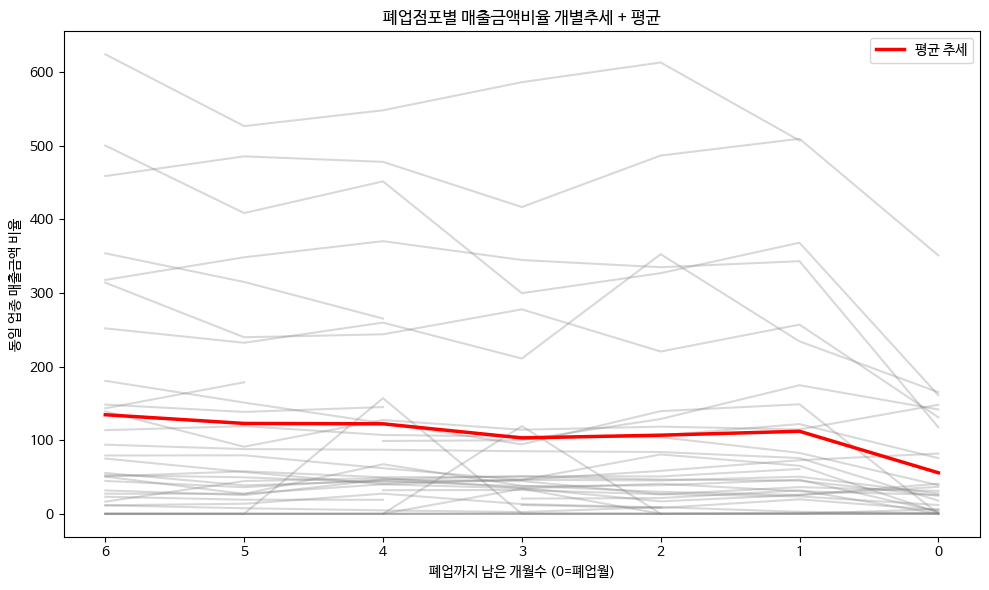

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

closed = df_merged[df_merged['폐업여부']==1].copy()
closed['기준년월'] = pd.to_datetime(closed['기준년월'], errors='coerce')
closed['폐업일_dt'] = pd.to_datetime(closed['폐업일'], errors='coerce')

# 폐업까지 남은 개월수 계산
closed['diff_month'] = (
    (closed['폐업일_dt'].dt.year - closed['기준년월'].dt.year) * 12 +
    (closed['폐업일_dt'].dt.month - closed['기준년월'].dt.month)
)

# 폐업 전 6개월 구간만
pre_N = 6
closed_pre = closed[(closed['diff_month'] >= 0) & (closed['diff_month'] <= pre_N)]

plt.figure(figsize=(10,6))
for gid, sub in closed_pre.groupby('가맹점구분번호'):
    plt.plot(sub['diff_month'], sub['동일 업종 매출금액 비율'], color='gray', alpha=0.3)

# 평균곡선
avg = (
    closed_pre.groupby('diff_month')['동일 업종 매출금액 비율']
    .mean().reset_index()
)
sns.lineplot(data=avg, x='diff_month', y='동일 업종 매출금액 비율',
             color='red', linewidth=2.5, label='평균 추세')

plt.title('폐업점포별 매출금액비율 개별추세 + 평균')
plt.xlabel('폐업까지 남은 개월수 (0=폐업월)')
plt.ylabel('동일 업종 매출금액 비율')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
import math
import matplotlib.pyplot as plt


# 매출금액 비율:	폐업 3~2개월 전부터 업종 평균 대비 매출이 뚜렷히 하락하는 패턴이 다수 점포에서 관찰되면 “Soft Warning Feature”로 유효함
# 매출건수 비율:	매출금액보다 먼저 하락한다면 고객 방문수 감소가 선행지표 역할
# 상권 내 순위 비율:	순위가 급격히 하락하는 시점이 매출보다 앞서면, 경쟁 점포의 영향이 폐업 요인
# 재방문 고객 비중:	점포 충성도 저하. 일부 업종(카페, 음식점)은 이 지표가 가장 강력한 폐업 전조 가능성
# 신규 고객 비중:	신규 유입이 장기간 낮으면 자연 폐업(수요 고갈형) 패턴
# 취소율 구간_RANK_INT:	품질 문제나 서비스 불만이 누적되는 시그널로, 상승곡선은 경고 신호


# 그릴 대상 지표
metrics = [
    ('동일 업종 매출금액 비율', '매출금액 비율'),
    ('동일 업종 매출건수 비율', '매출건수 비율'),
    ('동일 상권 내 매출 순위 비율', '상권 내 순위 비율'),
    ('재방문 고객 비중', '재방문 고객 비중'),
    ('신규 고객 비중', '신규 고객 비중'),
    ('취소율 구간_RANK_INT', '취소율 등급'),
]

# 시각화 설정
targets = closed_pre['가맹점구분번호'].unique()
n = len(targets)
cols = 4
rows = math.ceil(n / cols)

for col_name, label in metrics:
    if col_name not in closed_pre.columns:
        print(f"⚠️ '{col_name}' 컬럼이 없어서 건너뜀")
        continue

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows*2.2), sharex=True, sharey=False)
    axes = axes.flatten()

    for i, gid in enumerate(targets):
        sub = closed_pre[closed_pre['가맹점구분번호']==gid].sort_values('diff_month')
        axes[i].plot(sub['diff_month'], sub[col_name], color='steelblue', alpha=0.8)
        axes[i].invert_xaxis()
        axes[i].set_title(gid, fontsize=7)
        axes[i].grid(True, alpha=0.2)

    fig.suptitle(f'폐업점포별 {label} 변화 (폐업 전 6개월)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

[INFO] 특징 행렬 크기: (32, 78), 점포 수: 32
[INFO] Best k = 2, silhouette = 0.2926


가맹점구분번호  cluster
0  099CBF2425        0
1  104031A6C2        1
2  1521FF7269        0
3  1E00B3CC15        1
4  2D56DC79C1        0

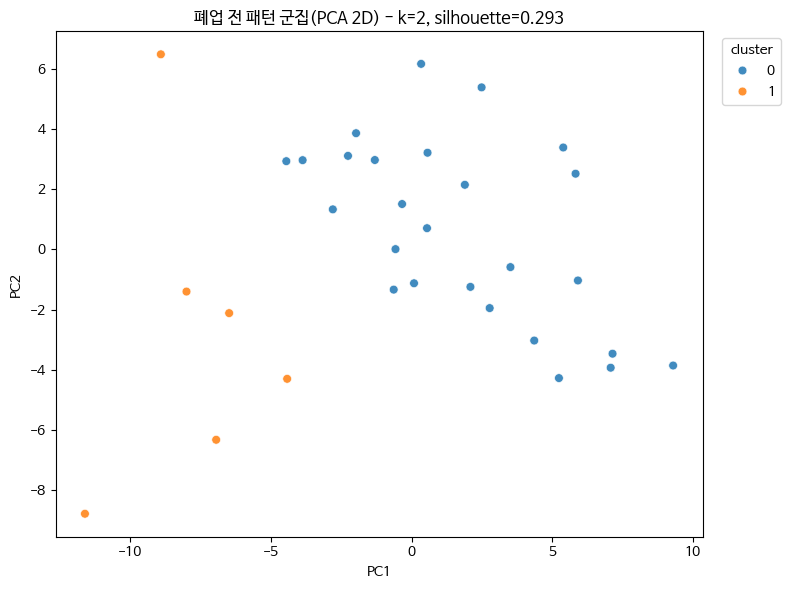

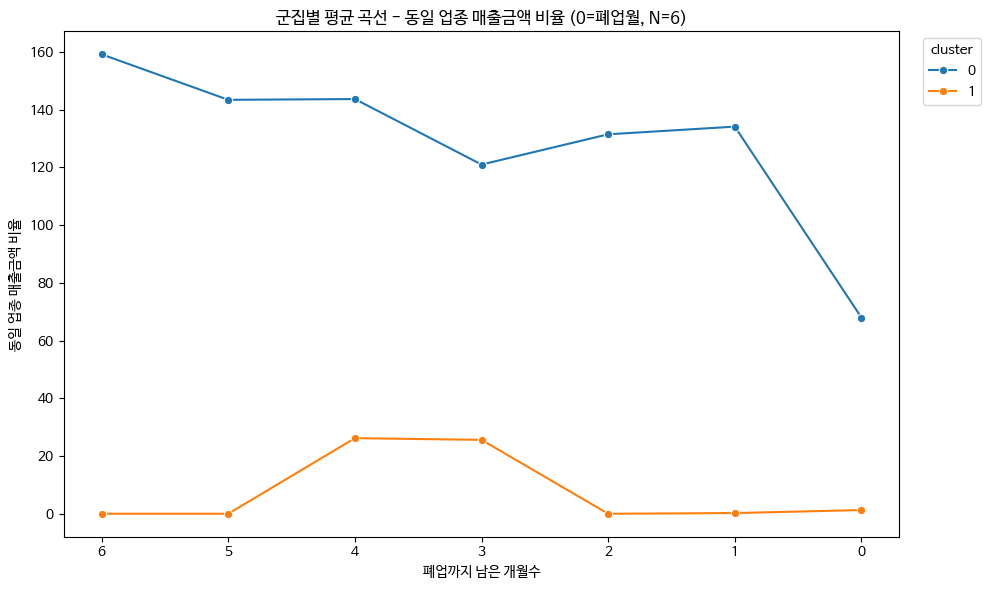

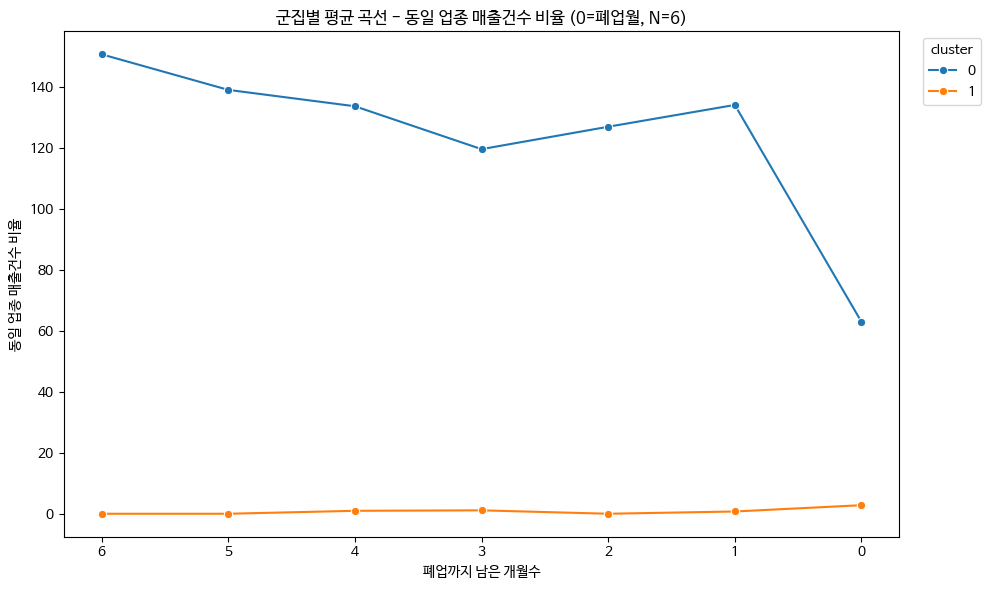

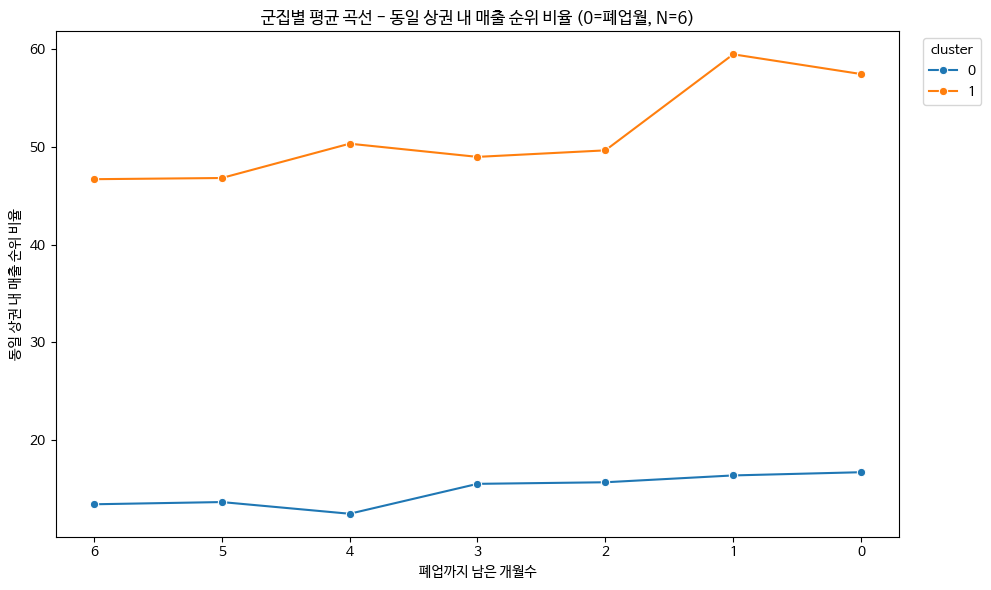

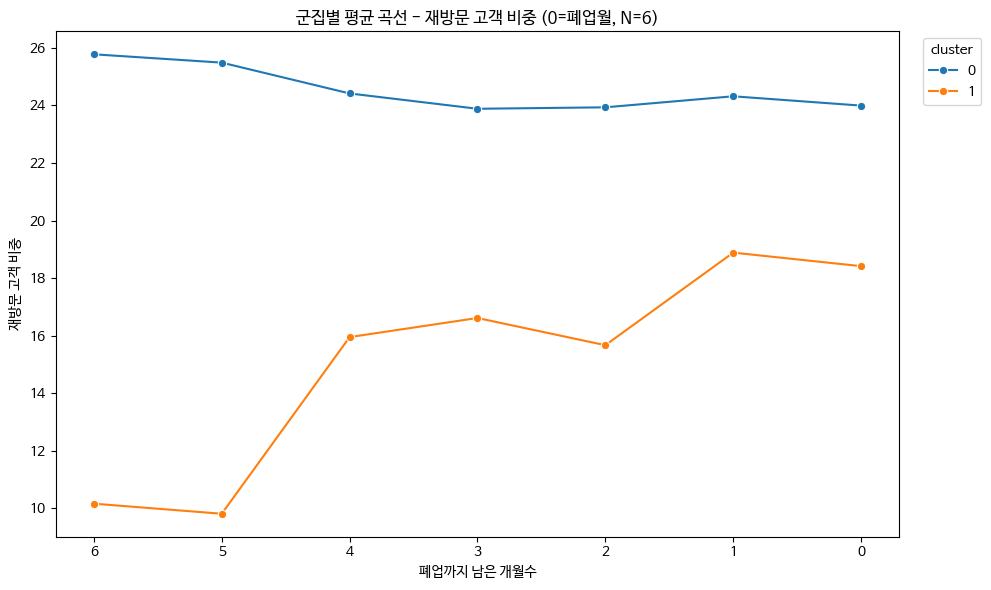

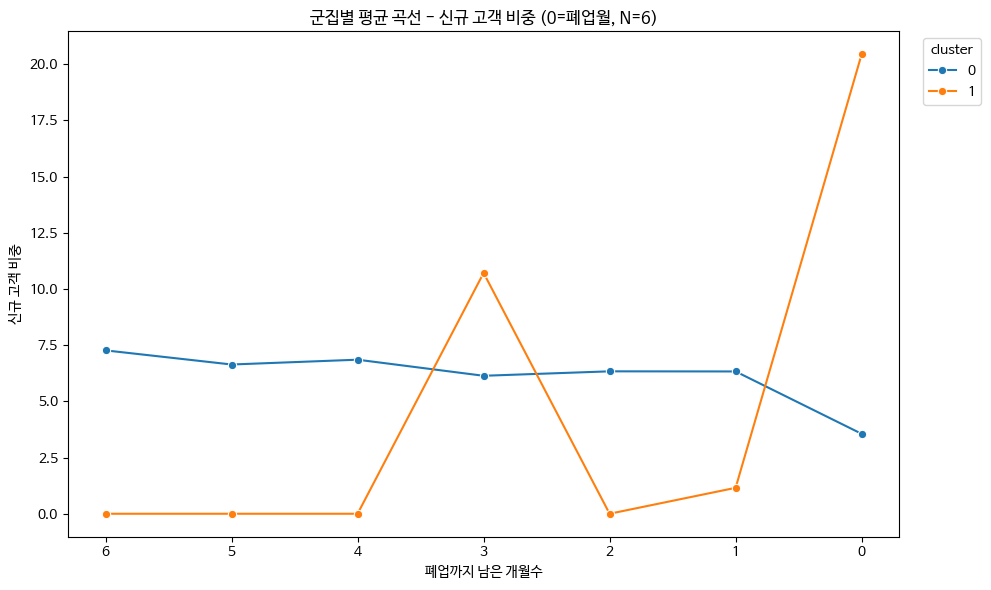

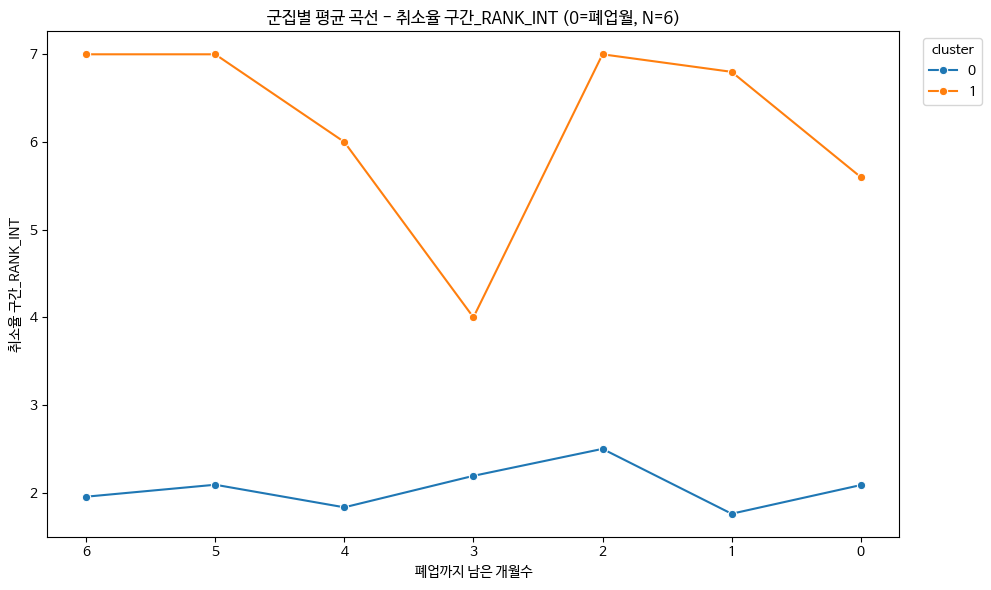

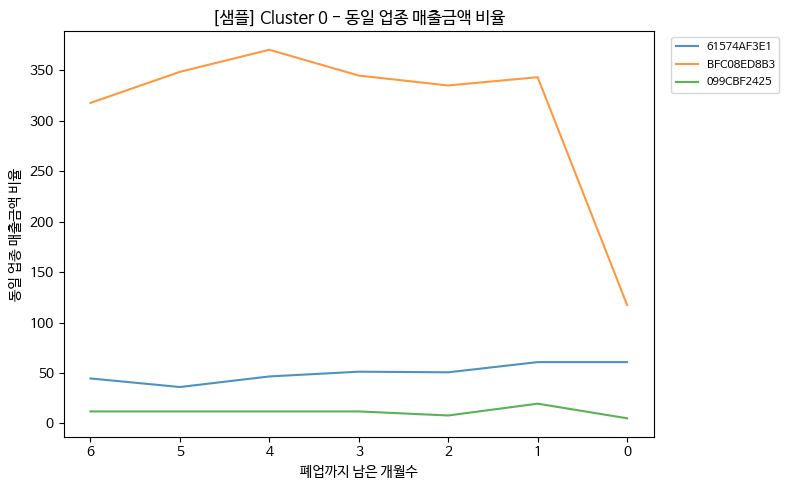

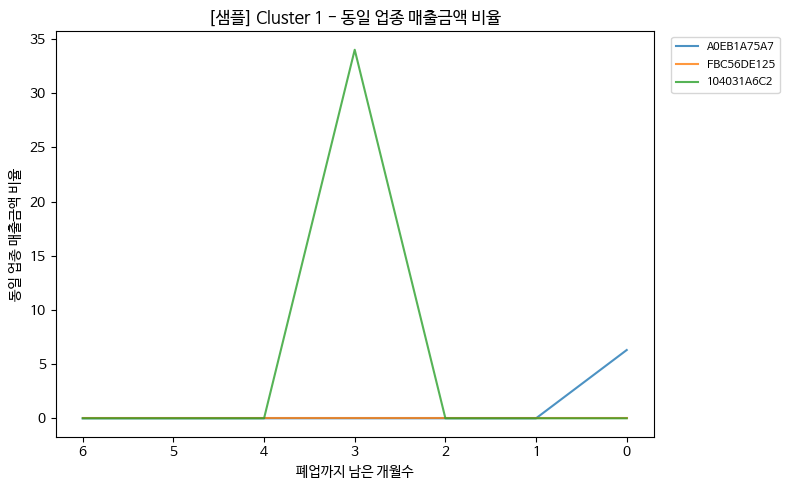

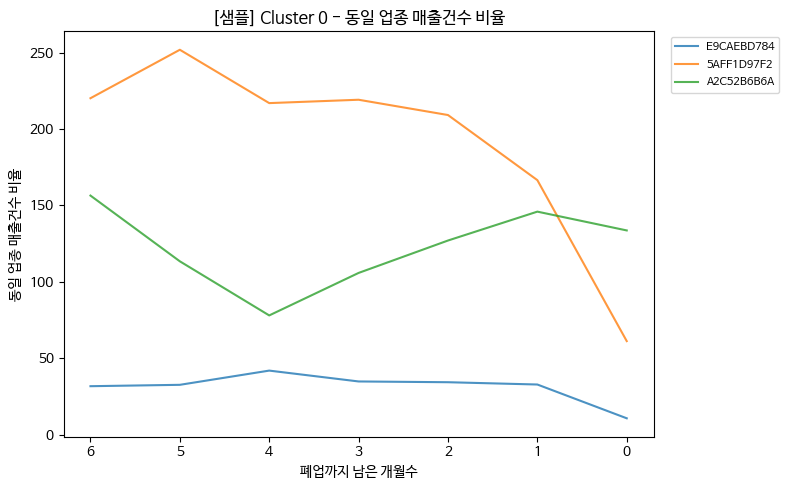

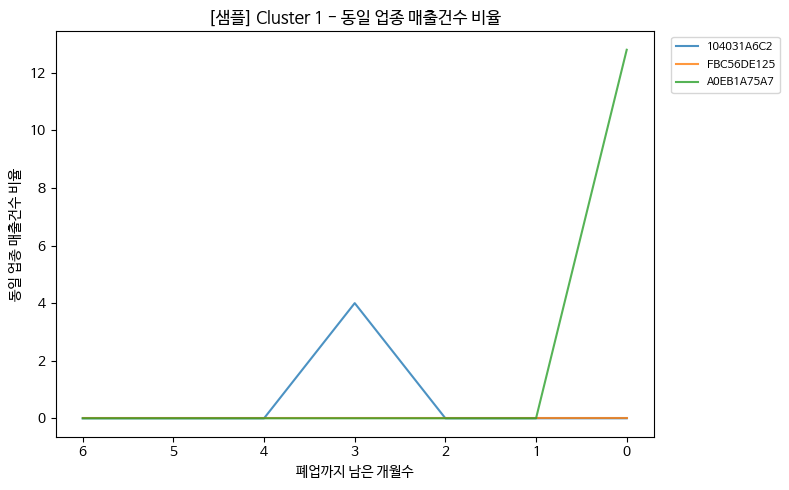

In [25]:
# -----------------------------------------------------------------------------
# 목적
# - df_merged(월별 패널 + 점포 마스터 + 폐업여부/폐업일)에서
#   폐업점포들의 "폐업 전 N개월" 시계열 패턴을 특징화하여 군집(KMeans)하고
#   PCA 2D로 시각화 + 군집별 평균 곡선을 비교합니다.
#
# 전제 컬럼
# ['가맹점구분번호','기준년월','폐업여부','폐업일',  (필수)
#  '동일 업종 매출금액 비율','동일 업종 매출건수 비율','동일 상권 내 매출 순위 비율',
#  '재방문 고객 비중','신규 고객 비중','취소율 구간_RANK_INT']  (권장)
#
# 주요 아이디어
# - 폐업점포만 추출 → 폐업월(0) 기준으로 '남은 개월수 diff_month' 정렬
# - 각 지표별로 [0..N]개월을 같은 길이로 정렬/보간하여 특징 벡터 생성
# - 추가로 trend slope, 마지막-처음 변화량(delta) 같은 통계 특징도 결합
# - 표준화 후 KMeans 군집 (k=2..6 중 silhouette 최고 k를 선택)
# - PCA 2D로 군집 분포 시각화, 군집별 평균 곡선 그래프 출력
#
# 출력
# - best_k, 실루엣 스코어, 각 점포의 cluster 라벨
# - PCA 산점도, 군집별 평균 곡선(지표별)
# -----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

plt.rcParams['axes.unicode_minus'] = False

# ==============================
# 0) 기본 준비
# ==============================
df = df_merged.copy()

# 기준년월/폐업일 안전 파싱
s = df['기준년월'].astype(str).str.strip()
s = s.str.replace(r'^(\d{4}-\d{2})-\d{2}$', r'\1', regex=True)   # YYYY-MM-DD -> YYYY-MM
s = s.str.replace(r'^(\d{4})/(\d{2})$', r'\1-\2', regex=True)    # YYYY/MM -> YYYY-MM
s = s.str.replace(r'^(\d{4})(\d{2})$', r'\1-\2', regex=True)     # YYYYMM -> YYYY-MM
s = s.str.replace(r'^(\d{4})(\d{2})(\d{2})$', r'\1-\2', regex=True)  # YYYYMMDD -> YYYY-MM
df['기준년월'] = pd.to_datetime(s, format='%Y-%m', errors='coerce')

if '폐업일' in df.columns:
    df['폐업일_dt'] = pd.to_datetime(df['폐업일'], errors='coerce')
else:
    df['폐업일_dt'] = pd.NaT

# 폐업점포만
closed = df[df['폐업여부'] == 1].copy()
closed = closed.sort_values(['가맹점구분번호', '기준년월'])

# 폐업까지 남은 개월수(diff_month)
closed['diff_month'] = (
    (closed['폐업일_dt'].dt.year - closed['기준년월'].dt.year) * 12 +
    (closed['폐업일_dt'].dt.month - closed['기준년월'].dt.month)
)

# 사용할 지표(존재하는 것만 사용)
candidate_metrics = [
    '동일 업종 매출금액 비율',
    '동일 업종 매출건수 비율',
    '동일 상권 내 매출 순위 비율',
    '재방문 고객 비중',
    '신규 고객 비중',
    '취소율 구간_RANK_INT',
]
metrics = [m for m in candidate_metrics if m in closed.columns]
assert len(metrics) > 0, "사용 가능한 지표 컬럼이 없습니다. metrics 리스트를 확인하세요."

# 분석 구간: 폐업 전 N개월
N = 6             # 0..6개월(총 7포인트)
min_coverage = 4  # 각 점포-지표가 최소 몇 개월 이상 값이 있어야 유효로 볼지

# ==============================
# 1) 정렬/보간: 각 점포 × 지표 × (0..N)월의 고정 길이 벡터 만들기
# ==============================
# 결과를 담을 dict: {가맹점: [지표별 시계열 벡터 + 통계특징]}
X_rows = []
store_ids = []

def build_series_features(x, name):
    """
    x: ndarray shape (N+1,)
    name: metric name (str)
    return: dict of engineered features for this series
    """
    # 단조 보간 뒤에도 남은 NaN은 0으로 처리(또는 전체 평균으로 대체 가능)
    series = pd.Series(x).interpolate(limit_direction='both').fillna(0).values

    # 선형 추세 기울기 (x축 0..N)
    t = np.arange(len(series))
    slope = np.polyfit(t, series, 1)[0] if np.isfinite(series).all() and len(series) > 1 else 0.0

    # 마지막-처음 변화량
    delta = float(series[-1] - series[0])

    # 평균/표준편차
    mean_ = float(np.nanmean(series))
    std_  = float(np.nanstd(series))

    # 분산/최솟값/최댓값
    min_ = float(np.nanmin(series))
    max_ = float(np.nanmax(series))

    # 지표명 접두어로 feature 이름 부여
    feats = {
        f'{name}_slope': slope,
        f'{name}_delta': delta,
        f'{name}_mean': mean_,
        f'{name}_std': std_,
        f'{name}_min': min_,
        f'{name}_max': max_,
    }
    # 원시 포인트도 붙이고 싶다면 아래 주석을 해제 (차원이 커지지만 군집 분리가 좋아질 수 있음)
    for i, v in enumerate(series):
        feats[f'{name}_m{i}'] = float(v)
    return feats

# 점포별로 루프
for gid, sub in closed.groupby('가맹점구분번호'):
    # 0..N 범위만 사용
    subN = sub[(sub['diff_month'] >= 0) & (sub['diff_month'] <= N)]
    if subN.empty:
        continue

    # diff_month를 인덱스로 정렬
    panel = subN.set_index('diff_month').sort_index()

    # 커버리지 체크(지표별로 최소 개수 충족)
    ok = False
    for m in metrics:
        if m in panel.columns and panel[m].notna().sum() >= min_coverage:
            ok = True
            break
    if not ok:
        continue

    feats_all = {}
    # 각 지표에 대해 0..N 인덱스의 값 벡터 만들기
    full_index = pd.Index(range(0, N+1), name='diff_month')
    for m in metrics:
        # diff_month 축으로 재색인 → 보간
        arr = panel.reindex(full_index)[m].astype(float)
        # 보간: 중앙은 선형, 양 끝 NaN은 양방향 채움
        arr = arr.interpolate(limit_direction='both')

        # 만약 데이터가 거의 없으면 continue (안정성)
        if arr.notna().sum() < min_coverage:
            continue

        feats_m = build_series_features(arr.values, m)
        feats_all.update(feats_m)

    if len(feats_all) == 0:
        continue

    X_rows.append(feats_all)
    store_ids.append(gid)

X = pd.DataFrame(X_rows, index=store_ids)
print(f"[INFO] 특징 행렬 크기: {X.shape}, 점포 수: {len(store_ids)}")

assert len(store_ids) > 1, "유효한 점포가 2개 미만입니다. min_coverage, N, metrics 등을 조정하세요."

# ==============================
# 2) 표준화 + 최적 k 선택(K=2..6, silhouette)
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_k, best_score, best_model = None, -1.0, None
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_k, best_score, best_model = k, score, kmeans

print(f"[INFO] Best k = {best_k}, silhouette = {best_score:.4f}")
labels = best_model.labels_

# 점포-라벨 매핑
cluster_df = pd.DataFrame({'가맹점구분번호': store_ids, 'cluster': labels})
display(cluster_df.head())

# ==============================
# 3) PCA 2D 시각화
# ==============================
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame({'PC1': coords[:,0], 'PC2': coords[:,1], 'cluster': labels, '가맹점구분번호': store_ids})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.85)
plt.title(f'폐업 전 패턴 군집(PCA 2D) - k={best_k}, silhouette={best_score:.3f}')
plt.legend(title='cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ==============================
# 4) 군집별 평균 곡선 비교 (지표별)
#    - diff_month(0..N) 축에서 각 군집의 평균 곡선을 그림
# ==============================
# closed_pre: 군집 라벨을 합치기 위해 원본에서 0..N 구간 추출
closed_pre = closed[(closed['diff_month'] >= 0) & (closed['diff_month'] <= N)].copy()
closed_pre = closed_pre.merge(cluster_df, on='가맹점구분번호', how='inner')

for m in metrics:
    if m not in closed_pre.columns:
        continue

    plt.figure(figsize=(10,6))
    # 군집 × 개월 평균
    avg_curve = (
        closed_pre.groupby(['cluster','diff_month'])[m]
                  .mean()
                  .reset_index()
    )
    sns.lineplot(data=avg_curve, x='diff_month', y=m, hue='cluster', marker='o')
    plt.gca().invert_xaxis()
    plt.title(f'군집별 평균 곡선 - {m} (0=폐업월, N={N})')
    plt.xlabel('폐업까지 남은 개월수'); plt.ylabel(m)
    plt.legend(title='cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ==============================
# 5) 군집별 대표점포 샘플 곡선(옵션)
#    - 각 군집에서 임의 3개 점포를 뽑아 개별 곡선 시각화 (지표 1~2개만)
# ==============================
np.random.seed(42)
sample_per_cluster = 3
sample_metric_list = [m for m in metrics][:2]  # 앞에서 1~2개만 샘플

for m in sample_metric_list:
    for c in sorted(pca_df['cluster'].unique()):
        candidates = closed_pre.loc[closed_pre['cluster']==c, '가맹점구분번호'].unique()
        pick = np.random.choice(candidates, size=min(sample_per_cluster, len(candidates)), replace=False)
        fig, ax = plt.subplots(figsize=(8,5))
        for gid in pick:
            sub = closed_pre[(closed_pre['가맹점구분번호']==gid)].set_index('diff_month').sort_index()
            y = sub[m].reindex(range(0, N+1)).interpolate(limit_direction='both')
            ax.plot(range(0, N+1), y.values, alpha=0.8, label=str(gid))
        ax.invert_xaxis()
        ax.set_title(f'[샘플] Cluster {c} - {m}')
        ax.set_xlabel('폐업까지 남은 개월수'); ax.set_ylabel(m)
        ax.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# -----------------------------------------------------------------------------
# 해석 가이드
# - PCA 산점도: 서로 멀리 떨어진 군집일수록 '폐업 전 패턴'이 상이함
# - 군집별 평균 곡선:
#    * Cluster A: 매출/건수 완만한 하락, 재방문 유지 → 운영상 문제보다는 수요 감소형
#    * Cluster B: 재방문 급락 + 취소율 상승 → 품질/서비스 이슈형
#    * Cluster C: 상권 내 순위 급락 → 경쟁 심화/입지 이슈형
# - cluster_df를 df1_eda/상권/업종과 다시 조인해 업종/상권별 분포를 보면,
#   어떤 업종/상권이 어떤 "폐업 전 패턴"에 많이 속하는지 확인 가능
# -----------------------------------------------------------------------------


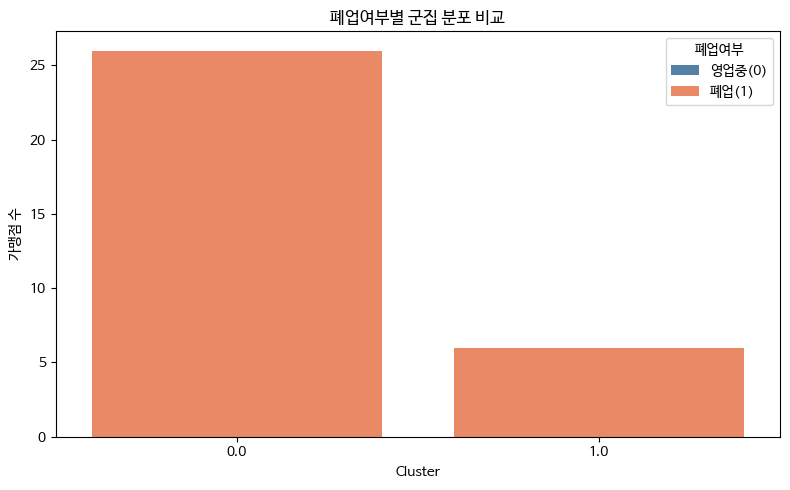

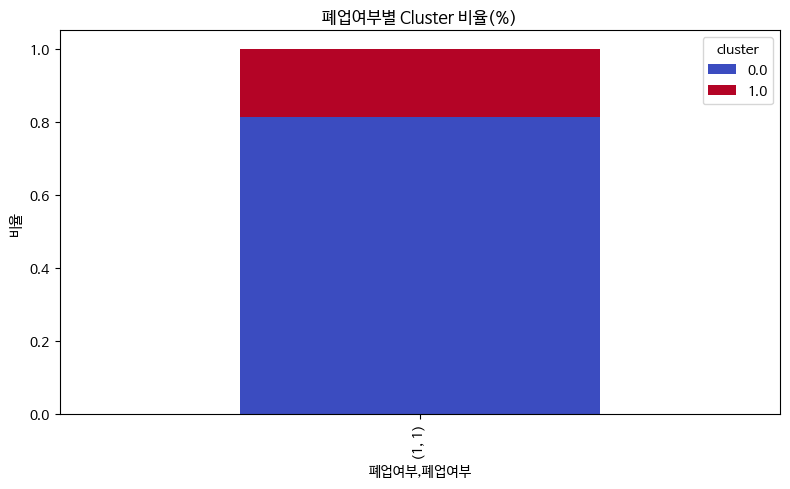

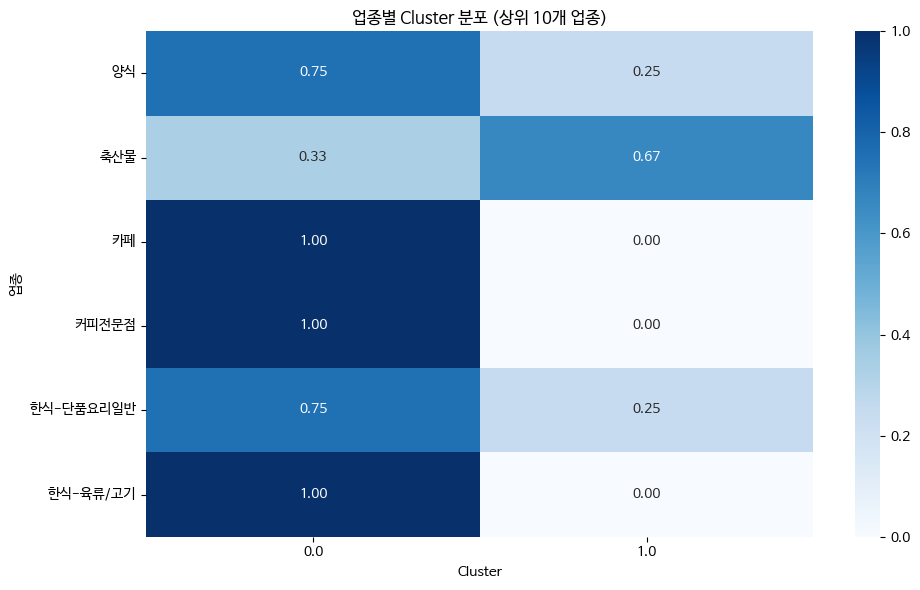

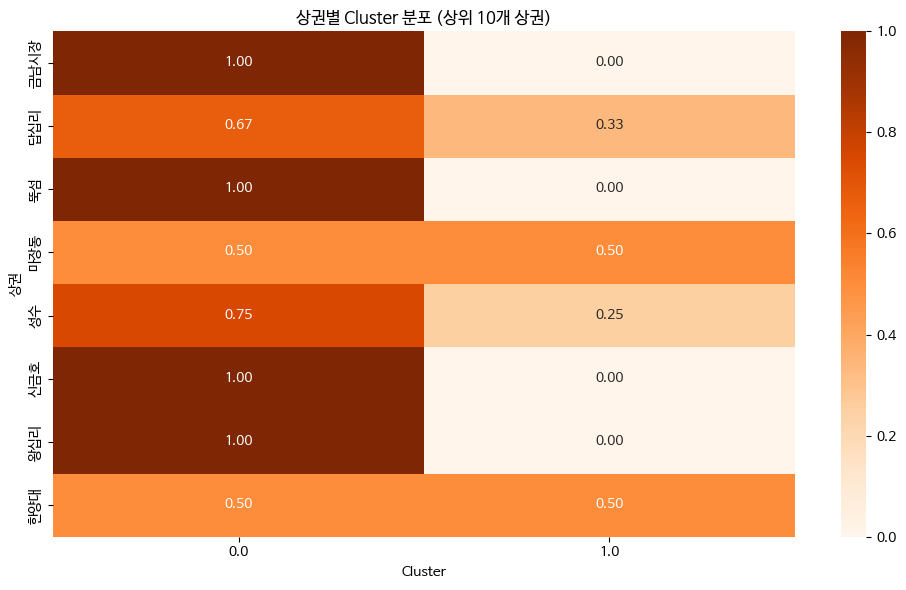

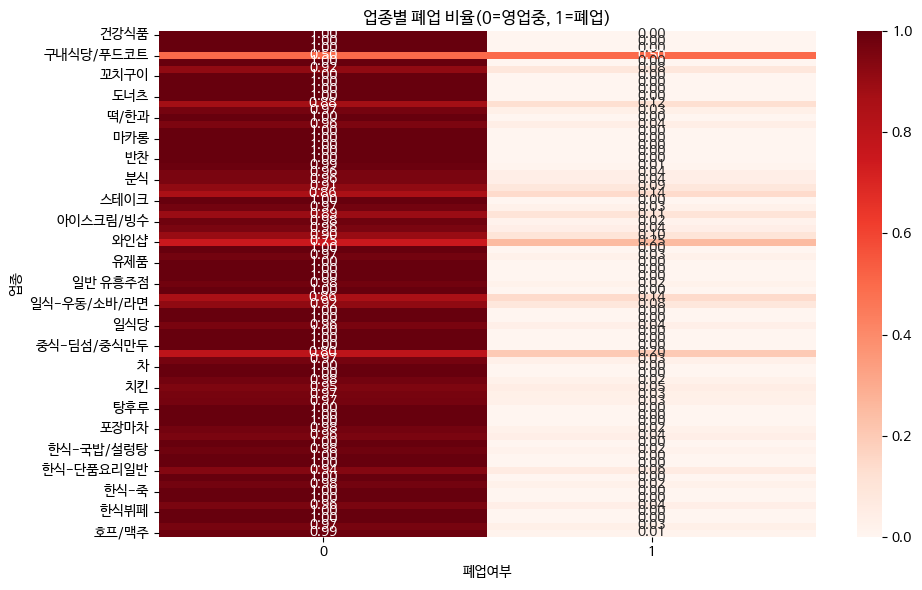

폐업여부  cluster  점포수  업종수  상권수
0     1      0.0   26   11    9
1     1      1.0    6    4    5

In [26]:
# -----------------------------------------------------------------------------
# 목적
# - 이전 단계에서 만든 cluster_df (가맹점구분번호, cluster) 결과를
#   df_merged와 병합하여
#   ① 폐업여부(0/1)별 cluster 분포
#   ② 업종별 cluster 분포
#   ③ 상권별 cluster 분포
#   를 비교/시각화
# -----------------------------------------------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) 병합: 군집결과 + 원본 메타정보
# ------------------------------------------------------------
df_clustered = pd.merge(
    df_merged,
    cluster_df,
    on='가맹점구분번호',
    how='left'
)

# 폐업여부, 업종, 상권, cluster 컬럼이 존재하는지 확인
cols_needed = ['폐업여부','업종','상권','cluster']
for c in cols_needed:
    assert c in df_clustered.columns, f"❌ '{c}' 컬럼이 없습니다."

# 가맹점 단위로 unique 처리 (월별 중복 제거)
df_clustered_unique = df_clustered.drop_duplicates('가맹점구분번호')

# ------------------------------------------------------------
# 1️⃣ 폐업여부별 cluster 분포
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.countplot(
    data=df_clustered_unique,
    x='cluster',
    hue='폐업여부',
    palette=['steelblue','coral']
)
plt.title('폐업여부별 군집 분포 비교')
plt.xlabel('Cluster')
plt.ylabel('가맹점 수')
plt.legend(title='폐업여부', labels=['영업중(0)', '폐업(1)'])
plt.tight_layout()
plt.show()

# 비율로도 비교 (Stacked bar)
share = (
    df_clustered_unique.groupby(['폐업여부','cluster'])
    .size()
    .groupby(level=0).apply(lambda x: x/x.sum())
    .unstack()
)
share.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8,5))
plt.title('폐업여부별 Cluster 비율(%)')
plt.ylabel('비율')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2️⃣ 업종별 cluster 분포 (히트맵)
# ------------------------------------------------------------
# 업종이 너무 많으면 상위 N개만 시각화
topN_industries = 10
top_inds = df_clustered_unique['업종'].value_counts().head(topN_industries).index
tmp = df_clustered_unique[df_clustered_unique['업종'].isin(top_inds)]

# 업종×Cluster 교차표 (건수)
pivot_ind = pd.crosstab(tmp['업종'], tmp['cluster'], normalize='index')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_ind, annot=True, fmt='.2f', cmap='Blues')
plt.title(f'업종별 Cluster 분포 (상위 {topN_industries}개 업종)')
plt.xlabel('Cluster')
plt.ylabel('업종')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3️⃣ 상권별 cluster 분포 (히트맵)
# ------------------------------------------------------------
topN_biz = 10
top_biz_zones = df_clustered_unique['상권'].value_counts().head(topN_biz).index
tmp2 = df_clustered_unique[df_clustered_unique['상권'].isin(top_biz_zones)]

pivot_biz = pd.crosstab(tmp2['상권'], tmp2['cluster'], normalize='index')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_biz, annot=True, fmt='.2f', cmap='Oranges')
plt.title(f'상권별 Cluster 분포 (상위 {topN_biz}개 상권)')
plt.xlabel('Cluster')
plt.ylabel('상권')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4️⃣ 폐업여부별 업종 분포 (보너스: 히트맵)
# ------------------------------------------------------------
pivot_ind_closed = pd.crosstab(
    df_clustered_unique['업종'],
    df_clustered_unique['폐업여부'],
    normalize='index'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_ind_closed, annot=True, fmt='.2f', cmap='Reds')
plt.title('업종별 폐업 비율(0=영업중, 1=폐업)')
plt.xlabel('폐업여부')
plt.ylabel('업종')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5️⃣ 인사이트용 정리표
# ------------------------------------------------------------
summary = (
    df_clustered_unique.groupby(['폐업여부','cluster'])
    .agg({
        '가맹점구분번호':'count',
        '업종': pd.Series.nunique,
        '상권': pd.Series.nunique
    })
    .rename(columns={'가맹점구분번호':'점포수','업종':'업종수','상권':'상권수'})
    .reset_index()
)
display(summary)


# EDA: 매출급감

급락기준: 3개월 간 매출이 20% 하락한 가게

Threshold (급락 기준)	−0.15는 위기 사례(Y=1)의 수를 너무 적게 만들어 모델이 학습할 데이터 자체가 부족해지는 클래스 불균형을 심화시킬 수 있어.	−0.10 (10% 하락)으로 완화하여 Y=1 샘플 수를 늘리거나, −0.15로 유지하되 모델링 시 오버샘플링 기법을 반드시 적용해야 해.
Window (예측 기간)	5개월은 예측 난이도를 매우 높여. 예측 기간이 길수록 노이즈가 많아져 모델 정확도가 떨어져.	$\mathbf{3}$개월로 축소하여 예측 정확도를 높이거나, 5개월 외에 $\mathbf{3}$개월 모델과 $\mathbf{6}$개월 모델을 따로 만들어 성과를 비교하는 다중 모델 전략을 쓰는 게 좋아.

In [ ]:
df['CRISIS_SALES_DROP'].value_counts()

CRISIS_SALES_DROP
1    44430
0    42160
Name: count, dtype: int64

1. 고객 충성도(재방문율) vs Crisis Rate
인사이트 가설: 재방문 고객 비중이 낮아 고객 충성도가 약한 상점일수록, 매출 급락 위험에 더 취약할 것이다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ⚠️ 폰트 설정 (앞서 폰트 설치/재시작을 완료했다고 가정)
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 상수 정의
Y1_COL = 'CRISIS_SALES_DROP'

# --- 1. 고객 충성도(재방문율) vs Crisis Rate ---
# 재방문 고객 비중을 10개 구간으로 나누어 분석
df['RETENTION_BIN'] = pd.cut(df['재방문 고객 비중'], bins=10, labels=False, include_lowest=True)

loyalty_risk = df.groupby('RETENTION_BIN').agg(
    Crisis_Rate=(Y1_COL, 'mean'),
    Retention_Avg=('재방문 고객 비중', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Retention_Avg', y='Crisis_Rate', data=loyalty_risk, palette='plasma')
plt.title('재방문 고객 비중 구간별 매출 급락 위험도')
plt.xlabel('평균 재방문 고객 비중 (%)')
plt.ylabel('Crisis Rate')
plt.tight_layout()
plt.savefig('eda_new_1_customer_loyalty.png')
plt.close()
print("✅ EDA New 1: 고객 충성도 vs Crisis Rate 저장 완료 (eda_new_1_customer_loyalty.png)")

✅ EDA New 1: 고객 충성도 vs Crisis Rate 저장 완료 (eda_new_1_customer_loyalty.png)


2. 고객 기반 편중도(고령층 의존도) vs Crisis Rate
인사이트 가설: 특정 연령층(특히 고령층)에 대한 의존도가 높은 상점은 유동성 변화에 취약하여 리스크가 더 클 것이다.

In [ ]:
# --- 2. 고객 기반 편중도(고령층 의존도) vs Crisis Rate ---
# 고령층 고객 비중 합산 (남성 60대이상 + 여성 60대이상)
df['SENIOR_DEP'] = df['남성 60대이상 고객 비중'] + df['여성 60대이상 고객 비중']

# 고령층 의존도를 10개 구간으로 나누어 분석
df['SENIOR_BIN'] = pd.cut(df['SENIOR_DEP'], bins=10, labels=False, include_lowest=True)

senior_risk = df.groupby('SENIOR_BIN').agg(
    Crisis_Rate=(Y1_COL, 'mean'),
    Senior_Avg=('SENIOR_DEP', 'mean')
).dropna().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Senior_Avg', y='Crisis_Rate', data=senior_risk, marker='o', color='purple')
plt.title('고령층 고객 의존도(%)별 매출 급락 위험도')
plt.xlabel('평균 고령층 고객 비중 (%)')
plt.ylabel('Crisis Rate')
plt.tight_layout()
plt.savefig('eda_new_2_senior_dependency.png')
plt.close()
print("✅ EDA New 2: 고령층 의존도 vs Crisis Rate 저장 완료 (eda_new_2_senior_dependency.png)")

✅ EDA New 2: 고령층 의존도 vs Crisis Rate 저장 완료 (eda_new_2_senior_dependency.png)


# EDA: 폐업여부

폐업일을 기준으로 폐업여부

In [ ]:
df['IS_CLOSED'].value_counts()

IS_CLOSED
0    84256
1     2334
Name: count, dtype: int64

In [ ]:
# ----------------------------------------------------
# A. Y2 (Hard Closure) 변수 생성
# ----------------------------------------------------

# combined_df에는 이미 폐업일 컬럼이 존재하며, NaN이 아닌 경우 폐업으로 간주
df['IS_CLOSED'] = df['폐업일'].notna().astype(int)

print(f"✅ IS_CLOSED (Hard Closure) 변수 생성 완료. (폐업 사례 수: {df['IS_CLOSED'].sum()})")

✅ IS_CLOSED (Hard Closure) 변수 생성 완료. (폐업 사례 수: 2334)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

AGE_RANK_COL = '가맹점 운영개월수 구간_RANK_INT'

# 1. 가맹점 운영 기간(RANK)별 폐업률 계산
# 랭크 1이 가장 오래된(안정적인) 구간이므로, 낮은 랭크일수록 폐업률이 낮아야 정상
closure_by_age = df.groupby(AGE_RANK_COL)['IS_CLOSED'].mean().sort_index(ascending=True).reset_index()
closure_by_age.rename(columns={'IS_CLOSED': 'Closure_Rate'}, inplace=True)

# 2. 시각화 (Bar Plot)
plt.figure(figsize=(9, 6))
sns.barplot(x=AGE_RANK_COL, y='Closure_Rate', data=closure_by_age, palette='Purples_d')
plt.title('가맹점 운영 기간(RANK)별 실제 폐업률 비교', fontsize=15)
plt.xlabel('운영 기간 랭크 (1: 가장 오래된 구간)')
plt.ylabel('Hard Closure Rate (폐업 비율)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('eda_hard_closure_by_age_rank.png')
plt.close()

print("✅ Hard Closure EDA: 운영 기간별 폐업률 시각화 저장 완료 (eda_hard_closure_by_age_rank.png)")

✅ Hard Closure EDA: 운영 기간별 폐업률 시각화 저장 완료 (eda_hard_closure_by_age_rank.png)


# EDA 매출급감+ 폐업여부

In [ ]:
# ----------------------------------------------------
# 2. Dual Y-Variable EDA 실행
# ----------------------------------------------------
print("\n--- Dual Y-Variable EDA (Soft Crisis vs Hard Closure) 실행 ---")

# 1. 업종별 위험도 비교 (Y1 vs Y2)
zcd_dual_rate = df.groupby('업종').agg(
    Crisis_Rate=('CRISIS_SALES_DROP', 'mean'),
    Closure_Rate=('IS_CLOSED', 'mean')
).reset_index()

# 위험도가 높은 상위 15개 업종 선택
zcd_dual_rate['Risk_Ratio'] = zcd_dual_rate['Closure_Rate'] + zcd_dual_rate['Crisis_Rate']
zcd_dual_rate = zcd_dual_rate.sort_values(by='Risk_Ratio', ascending=False).head(15)

zcd_dual_rate_melt = zcd_dual_rate.melt(
    id_vars='업종',
    value_vars=['Crisis_Rate', 'Closure_Rate'],
    var_name='Risk_Type',
    value_name='Rate'
)

plt.figure(figsize=(12, 8))
sns.barplot(x='Rate', y='업종', hue='Risk_Type', data=zcd_dual_rate_melt, palette=['#FF6347', '#4682B4'])
plt.title('업종별 위험도 비교: Soft Crisis (매출 급락) vs Hard Closure (실제 폐업)')
plt.xlabel('발생 비율')
plt.ylabel('업종')
plt.tight_layout()
plt.savefig('eda_dual_1_industry_comparison_final.png')
plt.close()
print("✅ EDA 1: 업종별 Soft/Hard Risk 비교 저장 완료 (eda_dual_1_industry_comparison_final.png)")


# 2. 외부 데이터 상관관계 비교 (Y1 vs Y2)
# '소비자물가지수'와 '한국은행 기준금리' 컬럼이 df에 존재한다고 가정
monthly_agg_dual = df.groupby('기준년월').agg(
    Crisis_Rate=('CRISIS_SALES_DROP', 'mean'),
    Closure_Rate=('IS_CLOSED', 'mean'),
    CPI=('소비자물가지수', 'mean'),
    Rate=('한국은행 기준금리', 'mean')
).reset_index()

corr_crisis = monthly_agg_dual[['Crisis_Rate', 'CPI', 'Rate']].corr().iloc[0, 1:]
corr_closure = monthly_agg_dual[['Closure_Rate', 'CPI', 'Rate']].corr().iloc[0, 1:]

corr_df = pd.DataFrame({'Crisis_Rate': corr_crisis, 'Closure_Rate': corr_closure})

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.T, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('외부 데이터 (금리/물가)와의 상관관계 비교')
plt.xlabel('외부 데이터')
plt.ylabel('Y 변수 유형')
plt.tight_layout()
plt.savefig('eda_dual_2_macro_comparison_final.png')
plt.close()
print("✅ EDA 2: 외부 데이터 상관관계 비교 Heatmap 저장 완료 (eda_dual_2_macro_comparison_final.png)")

⚠️ CRISIS_SALES_DROP (매출 15% 급락, 3개월) 재정의 시작...
✅ CRISIS_SALES_DROP 재정의 완료. (Y1 사례 수: 52486)
✅ IS_CLOSED (Hard Closure) 변수 생성 완료. (Y2 사례 수: 2334)

--- Dual Y-Variable EDA (Soft Crisis vs Hard Closure) 실행 ---
✅ EDA 1: 업종별 Soft/Hard Risk 비교 저장 완료 (eda_dual_1_industry_comparison_final.png)
✅ EDA 2: 외부 데이터 상관관계 비교 Heatmap 저장 완료 (eda_dual_2_macro_comparison_final.png)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 환경 설정 ---
warnings.filterwarnings('ignore')
# 폰트 설정 (앞서 폰트 설치/재시작을 완료했다고 가정)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 상수 정의
ID_COL = '가맹점구분번호'
SALES_COL = '동일 업종 매출금액 비율'
LAT_COL = 'LAT'
LON_COL = 'LNG'
Y1_COL = 'CRISIS_SALES_DROP'
Y2_COL = 'IS_CLOSED'
SALES_DROP_THRESHOLD = -0.15
PREDICTION_WINDOW_MONTHS = 3 # 3개월 예측 기간 사용

# A. CRISIS_SALES_DROP (Soft Crisis, Y1) 재정의
print("⚠️ CRISIS_SALES_DROP (매출 15% 급락, 3개월) 재정의 시작...")

drop_rates = []
current_shift_col = SALES_COL

for i in range(1, PREDICTION_WINDOW_MONTHS + 1):
    df[f'NEXT_M{i}_SAA'] = df.groupby(ID_COL)[SALES_COL].shift(-i)
    df[f'DROP_RATE_M{i}'] = (df[f'NEXT_M{i}_SAA'] - df[current_shift_col]) / (df[current_shift_col] + 1e-6)
    drop_rates.append(df[f'DROP_RATE_M{i}'] < SALES_DROP_THRESHOLD)
    current_shift_col = f'NEXT_M{i}_SAA'

# Y1: 다음 3개월 중 어느 한 달이라도 15% 이상 급락한 경우
df[Y1_COL] = pd.concat(drop_rates, axis=1).any(axis=1).astype(int)

# B. IS_CLOSED (Hard Closure, Y2) 정의
df[Y2_COL] = df['폐업일'].notna().astype(int)

# 임시 컬럼 정리
drop_cols = [col for col in df.columns if col.startswith('NEXT_M') or col.startswith('DROP_RATE')]
df = df.drop(columns=drop_cols, errors='ignore')
print("✅ Target 변수 재정의 완료.")


# 2. Geocoded 데이터 Merge
df_geocoded.rename(columns={'ENCODED_MCT': ID_COL, 'LAT': LAT_COL, 'LNG': LON_COL}, inplace=True)
df_geo_coords = df_geocoded[[ID_COL, LAT_COL, LON_COL]].drop_duplicates(subset=[ID_COL]).copy()

# combined_df에 좌표 정보 Left Merge
df = pd.merge(df, df_geo_coords, on=ID_COL, how='left')
print("✅ Geocoded 데이터 Merge 완료.")


# 3. 데이터 필터링 및 리스크 타입 정의
map_data = df[(df[Y1_COL] == 1) | (df[Y2_COL] == 1)].copy()

def get_risk_type(row):
    # Hard Closure (Y2)가 최우선 순위
    if row[Y2_COL] == 1:
        return 'Hard Closure (폐업)'
    # Soft Crisis (Y1)만 발생한 경우
    elif row[Y1_COL] == 1:
        return 'Soft Crisis (매출 급락)'
    return 'None'

map_data['Risk_Type'] = map_data.apply(get_risk_type, axis=1)
map_data_plot = map_data[map_data['Risk_Type'] != 'None']

# 지오코딩 실패로 인한 좌표 결측치 제거
map_data_plot = map_data_plot.dropna(subset=[LAT_COL, LON_COL])

print(f"총 플로팅 대상 데이터 건수: {map_data_plot.shape[0]}건")

# 4. Matplotlib Scatter Plot (지도 시각화)
plt.figure(figsize=(10, 10))

# Soft Crisis (Orange/Red) 마커 그리기
sns.scatterplot(
    x=LON_COL,
    y=LAT_COL,
    data=map_data_plot,
    hue='Risk_Type',
    palette={'Hard Closure (폐업)': '#DC143C', 'Soft Crisis (매출 급락)': '#FF8C00'}, # 빨강, 주황
    style='Risk_Type',
    s=50,
    alpha=0.7
)

# 서울 성동구의 대략적인 위경도 경계 설정 (시각적 명확성 확보)
plt.xlim(127.0, 127.1)
plt.ylim(37.5, 37.6)

plt.title('상권 위기 유형별 분포 (Hard Closure vs. Soft Crisis)', fontsize=15)
plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.legend(title='위기 유형')
plt.gca().set_aspect('equal', adjustable='box') # 지리적 정확도를 위해 비율 유지
plt.tight_layout()
plt.savefig('geospatial_crisis_map_final.png')
plt.close()

print("✅ 위기 유형별 지리적 분포 시각화 파일 저장 완료 (geospatial_crisis_map_final.png)")

⚠️ CRISIS_SALES_DROP (매출 15% 급락, 3개월) 재정의 시작...
✅ Target 변수 재정의 완료.
✅ Geocoded 데이터 Merge 완료.
총 플로팅 대상 데이터 건수: 53190건
✅ 위기 유형별 지리적 분포 시각화 파일 저장 완료 (geospatial_crisis_map_final.png)


지도 시각화

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   가맹점구분번호                86590 non-null  object 
 1   기준년월                   86590 non-null  int64  
 2   배달매출금액 비율              86590 non-null  float64
 3   동일 업종 매출금액 비율          86590 non-null  float64
 4   동일 업종 매출건수 비율          86590 non-null  float64
 5   동일 업종 내 매출 순위 비율       86590 non-null  float64
 6   동일 상권 내 매출 순위 비율       86590 non-null  float64
 7   동일 업종 내 해지 가맹점 비중      86590 non-null  float64
 8   동일 상권 내 해지 가맹점 비중      86590 non-null  float64
 9   남성 20대이하 고객 비중         86590 non-null  float64
 10  남성 30대 고객 비중           86590 non-null  float64
 11  남성 40대 고객 비중           86590 non-null  float64
 12  남성 50대 고객 비중           86590 non-null  float64
 13  남성 60대이상 고객 비중         86590 non-null  float64
 14  여성 20대이하 고객 비중         86590 non-null  float64
 15  여성

In [ ]:
df_geocoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4170 entries, 0 to 4169
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   가맹점구분번호             4170 non-null   object 
 1   MCT_BSE_AR          4170 non-null   object 
 2   MCT_NM              4170 non-null   object 
 3   MCT_BRD_NUM         541 non-null    object 
 4   MCT_SIGUNGU_NM      4170 non-null   object 
 5   HPSN_MCT_ZCD_NM     4170 non-null   object 
 6   HPSN_MCT_BZN_CD_NM  3130 non-null   object 
 7   ARE_D               4170 non-null   int64  
 8   MCT_ME_D            126 non-null    float64
 9   LAT                 4170 non-null   float64
 10  LNG                 4170 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 390.9+ KB


In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.features import IFrame
from IPython.display import display # 코랩에서 지도를 출력하기 위해 필요

# --- 상수 정의 ---
ID_COL = '가맹점구분번호'
LAT_COL = 'LAT'
LON_COL = 'LNG'
Y1_COL = 'CRISIS_SALES_DROP' # Soft Crisis
Y2_COL = 'IS_CLOSED' # Hard Closure

# ⚠️ df_geocoded와 df가 이미 로드되어 있음을 가정합니다.

# A. CRISIS_SALES_DROP (Y1)과 IS_CLOSED (Y2)가 없거나 불완전할 경우를 대비하여 다시 정의
# (가장 최근에 설정된 기준으로 정의)
# 이 로직은 이전 코드 블록에서 실행되어 있어야 하지만, 안전을 위해 변수 존재를 확인합니다.
if Y1_COL not in df.columns:
    print("⚠️ Target 변수 (CRISIS_SALES_DROP)가 없어 임시로 1개월 lookahead로 정의합니다.")
    df['NEXT_M1_SAA'] = df.groupby(ID_COL)['동일 업종 매출금액 비율'].shift(-1)
    df['CRISIS_SALES_DROP'] = ((df['NEXT_M1_SAA'] - df['동일 업종 매출금액 비율']) / (df['동일 업종 매출금액 비율'] + 1e-6) < -0.15).astype(int)
    df.drop(columns=['NEXT_M1_SAA'], errors='ignore', inplace=True)
if Y2_COL not in df.columns:
    df['IS_CLOSED'] = df['폐업일'].notna().astype(int)

# ----------------------------------------------------
# 2. Geocoded 데이터 병합 (KeyError 방지)
# ----------------------------------------------------

# df_geocoded의 컬럼명을 최종 명칭으로 정리
df_geocoded.rename(columns={'ENCODED_MCT': ID_COL, 'LAT': LAT_COL, 'LNG': LON_COL}, inplace=True)
df_geo_coords = df_geocoded[[ID_COL, LAT_COL, LON_COL]].drop_duplicates(subset=[ID_COL]).copy()

# 💡 반드시 df에 좌표가 병합되었는지 확인하고, 없으면 다시 병합합니다.
if LAT_COL not in df.columns:
    df = pd.merge(df, df_geo_coords, on=ID_COL, how='left')
    print("✅ LAT/LNG 컬럼 재병합 완료.")


# ----------------------------------------------------
# 3. 플로팅 데이터 준비 및 Folium 시각화
# ----------------------------------------------------

# 플로팅에 필요한 컬럼만 선택 (KeyError 방지)
plot_data = df[[ID_COL, Y1_COL, Y2_COL, LAT_COL, LON_COL, '가맹점명', '업종']].copy()

# 1. 위기 유형 정의 및 중복 ID 정리 (ID별 하나의 상태만 표시)
def get_risk_type(row):
    if row[Y2_COL] == 1:
        return 'Hard Closure (폐업)'
    elif row[Y1_COL] == 1:
        return 'Soft Crisis (매출 급락)'
    return 'None'

plot_data['Risk_Type'] = plot_data.apply(get_risk_type, axis=1)

# ID별로 위기 상태가 하나만 표시되도록 최우선 순위(폐업) 기준으로 중복 제거
final_plot_data = plot_data.sort_values(by=[ID_COL, Y2_COL, Y1_COL], ascending=[True, False, False])
final_plot_data = final_plot_data[final_plot_data['Risk_Type'] != 'None']
final_plot_data = final_plot_data.drop_duplicates(subset=[ID_COL], keep='first').dropna(subset=[LAT_COL, LON_COL])

print(f"총 플로팅 대상 (Unique 가맹점): {len(final_plot_data)}개")


# 2. Folium 지도 생성
if len(final_plot_data) > 0:
    # 지도의 중심 좌표를 지오코딩된 데이터의 평균으로 설정
    center_lat = final_plot_data[LAT_COL].mean()
    center_lng = final_plot_data[LON_COL].mean()

    m = folium.Map(
        location=[center_lat, center_lng],
        zoom_start=14,
        tiles="cartodbpositron"
    )

    # 마커 추가 및 색상 구분 로직
    for idx, row in final_plot_data.iterrows():
        risk_type = row['Risk_Type']

        # 마커 색상 결정: 폐업(Red) vs 급락(Orange)
        marker_color = 'red' if risk_type == 'Hard Closure (폐업)' else 'orange'

        popup_html = f"""
        <b>유형:</b> {risk_type}<br>
        <b>상호명:</b> {row.get('가맹점명', 'N/A')}<br>
        <b>업종:</b> {row.get('업종', 'N/A')}
        """

        folium.Marker(
            location=[row[LAT_COL], row[LON_COL]],
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=row.get('가맹점명', 'N/A'),
            icon=folium.Icon(color=marker_color, icon='info-sign')
        ).add_to(m)

    print("\n✅ 지도 시각화 완료! 🌟 빨강(폐업) / 주황(급락) 마커를 확인하세요.")
    # 코랩 셀에 지도를 출력
    display(m)
else:
    print("\n지오코딩 및 필터링 후, 지도에 표시할 위기 가맹점 데이터가 없습니다.")

Output hidden; open in https://colab.research.google.com to view.

# 지도 시각화 : 상권 전처리 결과




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

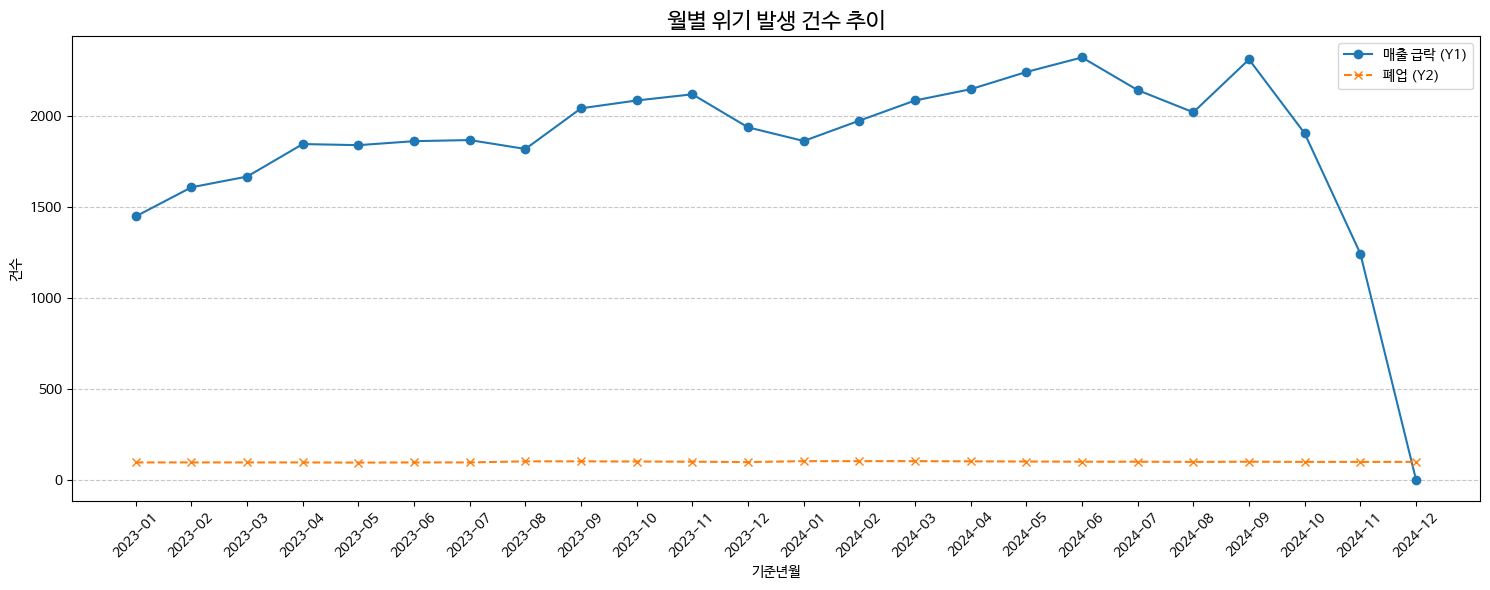


### 3. 위기 그룹 vs. 정상 그룹 비교 시각화 (Y1: 매출 급락) ###


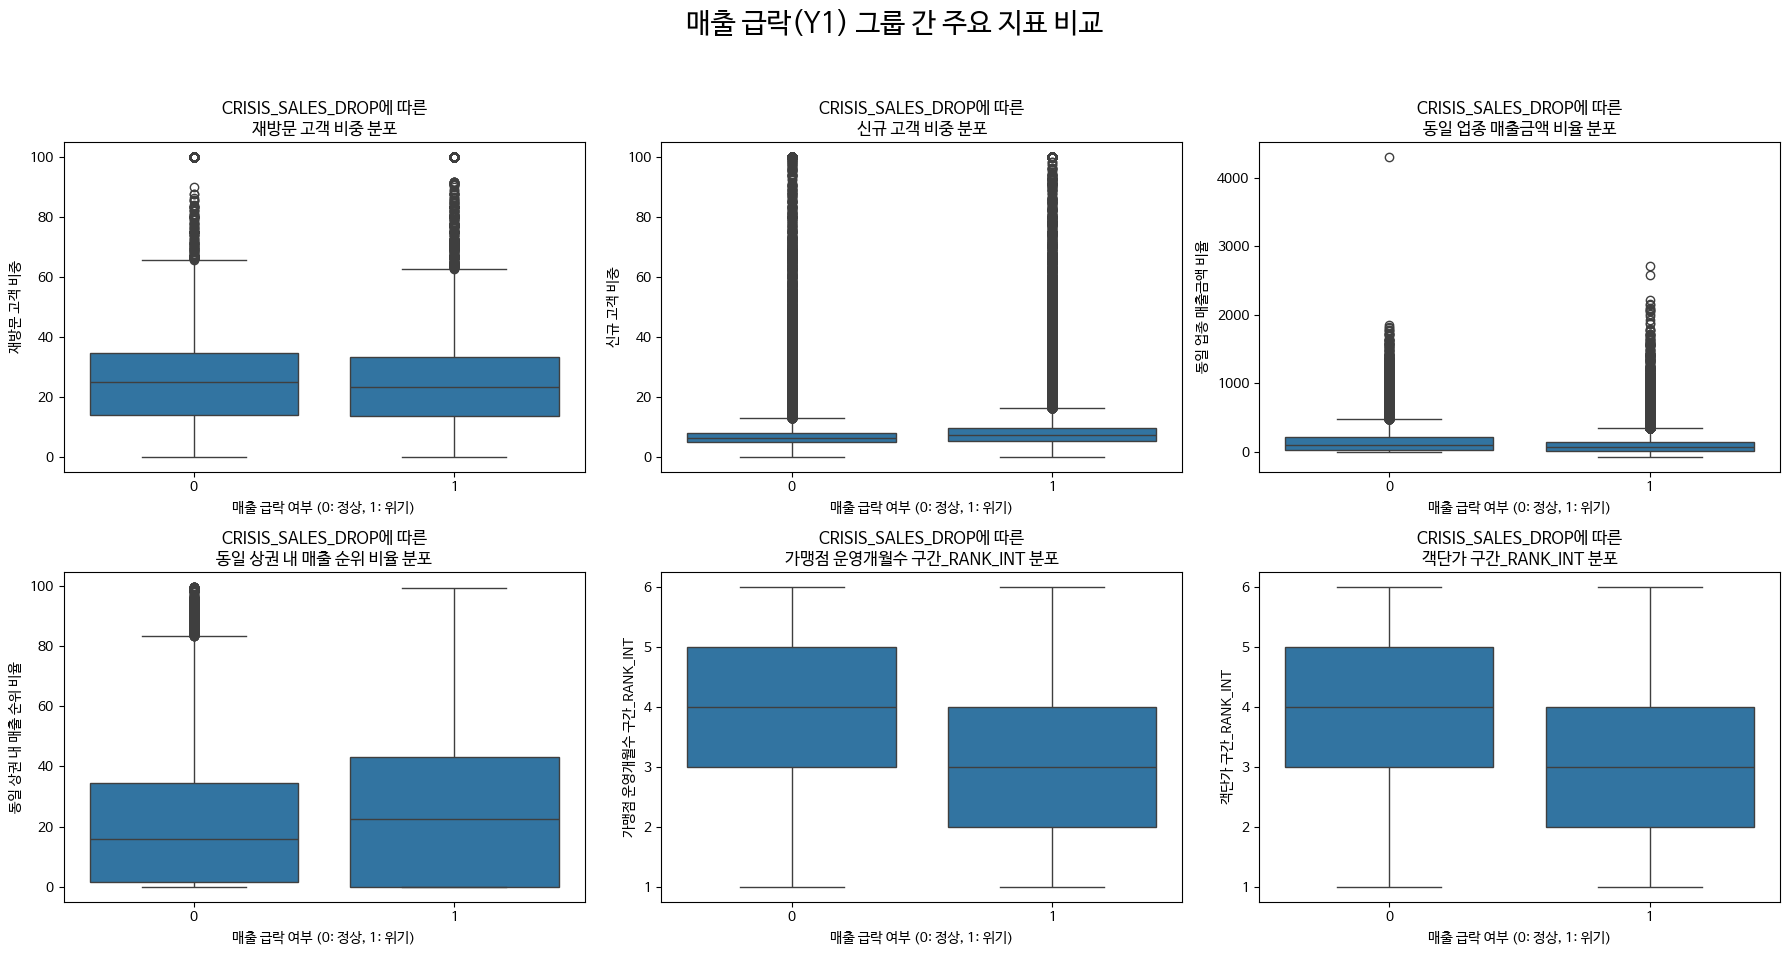


### 4. 상권별 위기 분석 (Y1: 매출 급락) ###


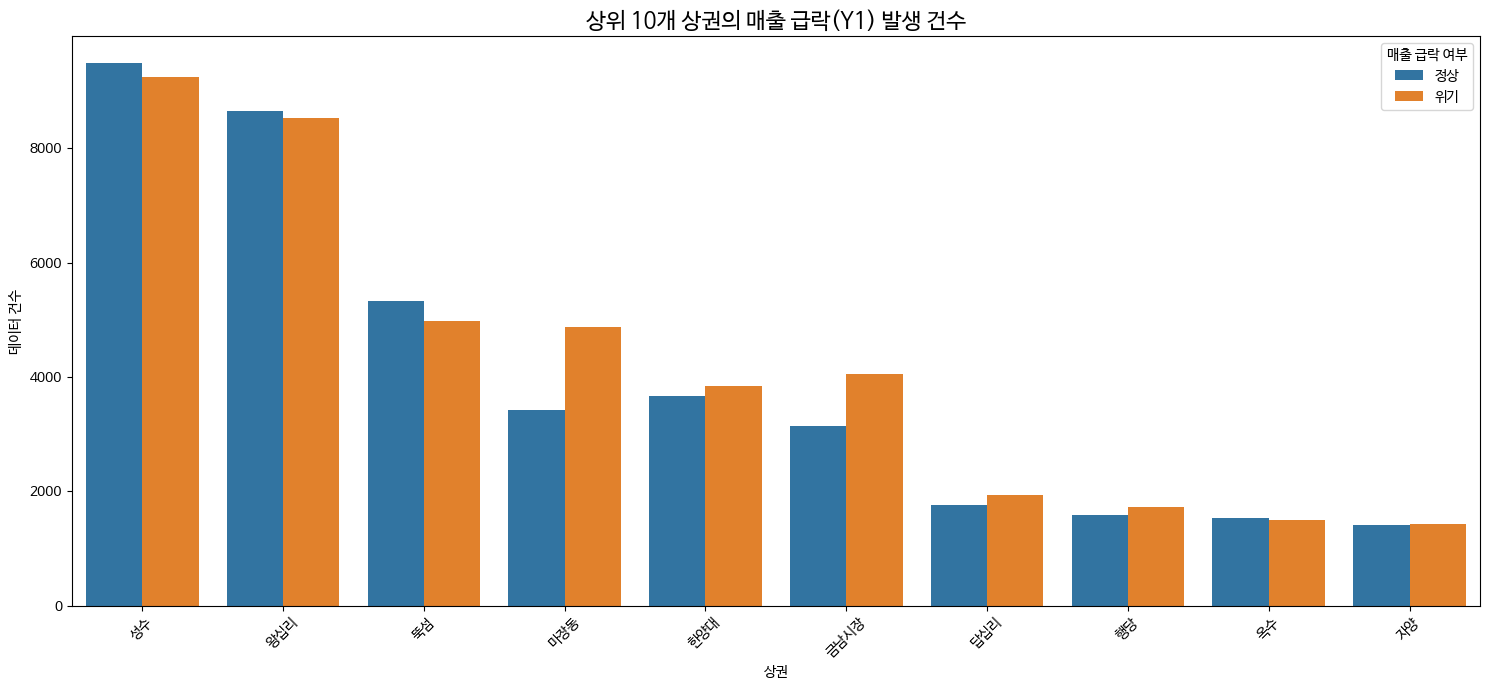


### 5. 주요 변수 간 상관관계 분석 ###


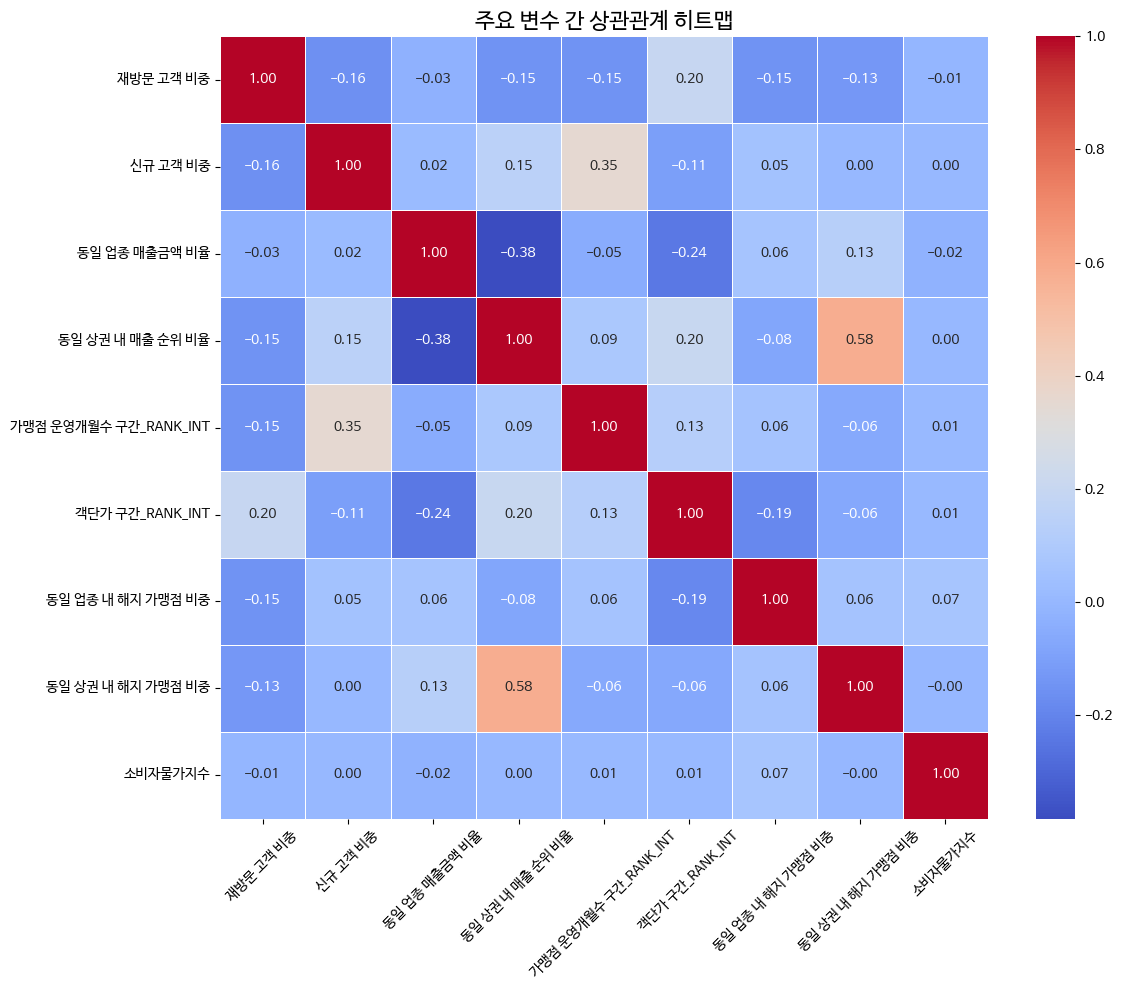

In [ ]:
# 1. 라이브러리 및 데이터 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# ⚠️ Colab에서 한글 폰트가 깨지지 않도록 설정하는 코드
# 아래 코드를 실행한 뒤, 런타임 → '런타임 다시 시작'을 꼭 해주세요!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 준비 ---
# 사용자가 업로드한 'df_Preprocessing.csv' 파일을 로드합니다.
# df = pd.read_csv('df_Preprocessing.csv')

# Y1 (CRISIS_SALES_DROP) 및 Y2 (IS_CLOSED) 정의 (이전 단계에서 사용한 전처리 로직)
SALES_DROP_THRESHOLD = -0.20
PREDICTION_WINDOW_MONTHS = 3
ID_COL = '가맹점구분번호'
SALES_COL = '동일 업종 매출금액 비율'

# '기준년월'을 날짜 형식으로 변환하고, 가맹점별/시간순으로 데이터를 정렬합니다.
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df = df.sort_values(by=[ID_COL, '기준년월'])

# 향후 3개월간의 매출 급락 여부를 계산하여 'CRISIS_SALES_DROP' 타겟 변수 생성
drop_rates = []
current_shift_col = SALES_COL
for i in range(1, PREDICTION_WINDOW_MONTHS + 1):
    df[f'NEXT_M{i}_SAA'] = df.groupby(ID_COL)[SALES_COL].shift(-i)
    df[f'DROP_RATE_M{i}'] = (df[f'NEXT_M{i}_SAA'] - df[current_shift_col]) / (df[current_shift_col] + 1e-6)
    drop_rates.append(df[f'DROP_RATE_M{i}'] < SALES_DROP_THRESHOLD)
    current_shift_col = f'NEXT_M{i}_SAA'

df['CRISIS_SALES_DROP'] = pd.concat(drop_rates, axis=1).any(axis=1).astype(int)

# '폐업일' 유무에 따라 'IS_CLOSED' 타겟 변수 생성
df['IS_CLOSED'] = df['폐업일'].notna().astype(int)

# 계산에 사용된 임시 컬럼들 삭제
drop_cols = [col for col in df.columns if col.startswith('NEXT_M') or col.startswith('DROP_RATE')]
df = df.drop(columns=drop_cols, errors='ignore')

print("✅ 데이터 준비 및 타겟 변수 생성이 완료되었습니다.\n")


# --- EDA 및 시각화 ---

# 2. 타겟 변수 분포 확인
print("### 1. 타겟 변수(Y1, Y2) 분포 ###")
y1_counts = df['CRISIS_SALES_DROP'].value_counts(normalize=True)
y2_counts = df['IS_CLOSED'].value_counts(normalize=True)
print(f"Y1 (매출 급락) 비율:\n{y1_counts}\n")
print(f"Y2 (폐업) 비율:\n{y2_counts}\n")


# 3. 월별 위기 발생 건수 시각화
print("### 2. 월별 위기 발생 건수 시각화 ###")
df['기준년월_str'] = df['기준년월'].dt.strftime('%Y-%m')
monthly_crisis = df.groupby('기준년월_str')[['CRISIS_SALES_DROP', 'IS_CLOSED']].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(monthly_crisis['기준년월_str'], monthly_crisis['CRISIS_SALES_DROP'], marker='o', linestyle='-', label='매출 급락 (Y1)')
plt.plot(monthly_crisis['기준년월_str'], monthly_crisis['IS_CLOSED'], marker='x', linestyle='--', label='폐업 (Y2)')
plt.title('월별 위기 발생 건수 추이', fontsize=16)
plt.xlabel('기준년월')
plt.ylabel('건수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 4. 위기 그룹 vs 정상 그룹 비교 (Box Plot)
print("\n### 3. 위기 그룹 vs. 정상 그룹 비교 시각화 (Y1: 매출 급락) ###")
# 비교할 주요 숫자형 변수들을 리스트로 정의
features_to_compare = [
    '재방문 고객 비중', '신규 고객 비중', '동일 업종 매출금액 비율',
    '동일 상권 내 매출 순위 비율', '가맹점 운영개월수 구간_RANK_INT', '객단가 구간_RANK_INT'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('매출 급락(Y1) 그룹 간 주요 지표 비교', fontsize=20)
axes = axes.flatten()

# 각 변수별로 box plot을 그려서 그룹 간 분포를 비교
for i, feature in enumerate(features_to_compare):
    sns.boxplot(x='CRISIS_SALES_DROP', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'CRISIS_SALES_DROP에 따른\n{feature} 분포', fontsize=12)
    axes[i].set_xlabel('매출 급락 여부 (0: 정상, 1: 위기)')
    axes[i].set_ylabel(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 5. 상권별 위기 분석
print("\n### 4. 상권별 위기 분석 (Y1: 매출 급락) ###")
# 데이터가 가장 많은 상위 10개 상권만 선택
top_n_bzn = df['상권'].value_counts().nlargest(10).index
df_top_bzn = df[df['상권'].isin(top_n_bzn)]

plt.figure(figsize=(15, 7))
sns.countplot(data=df_top_bzn, x='상권', hue='CRISIS_SALES_DROP', order=top_n_bzn)
plt.title('상위 10개 상권의 매출 급락(Y1) 발생 건수', fontsize=16)
plt.xlabel('상권')
plt.ylabel('데이터 건수')
plt.xticks(rotation=45)
plt.legend(title='매출 급락 여부', labels=['정상', '위기'])
plt.tight_layout()
plt.show()


# 6. 주요 변수 간 상관관계 분석 (히트맵)
print("\n### 5. 주요 변수 간 상관관계 분석 ###")
# 히트맵을 그릴 주요 숫자형 변수들을 선택
corr_features = features_to_compare + ['동일 업종 내 해지 가맹점 비중', '동일 상권 내 해지 가맹점 비중', '소비자물가지수']
correlation_matrix = df[corr_features].corr()

plt.figure(figsize=(12, 10))
# 상관관계 행렬을 히트맵으로 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('주요 변수 간 상관관계 히트맵', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

✅ 데이터 준비가 완료되었습니다.

### 월별 폐업(Y2) 건수와 거시 경제 지표 추이 비교 ###


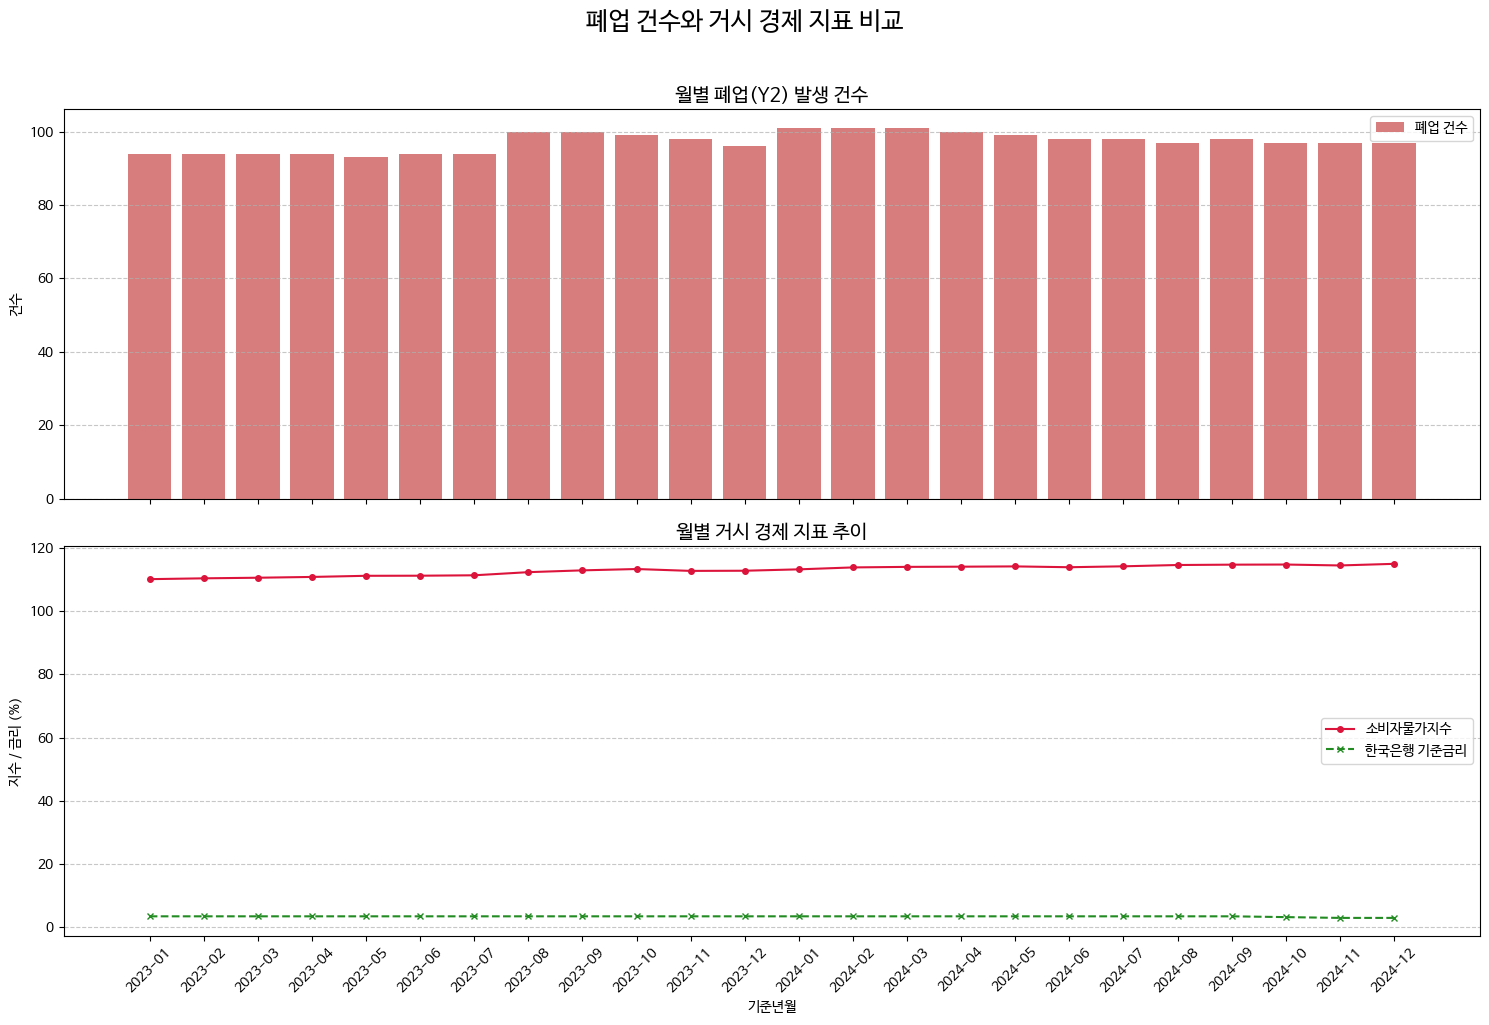

In [ ]:
# 1. 라이브러리 및 데이터 로딩 (이전과 동일)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Colab 한글 폰트 설정 (이미 실행했다면 건너뛰어도 돼)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 준비 (이전과 동일) ---
# df = pd.read_csv('df_Preprocessing.csv')

SALES_DROP_THRESHOLD = -0.20
PREDICTION_WINDOW_MONTHS = 3
ID_COL = '가맹점구분번호'
SALES_COL = '동일 업종 매출금액 비율'

df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')
df = df.sort_values(by=[ID_COL, '기준년월'])

drop_rates = []
current_shift_col = SALES_COL
for i in range(1, PREDICTION_WINDOW_MONTHS + 1):
    df[f'NEXT_M{i}_SAA'] = df.groupby(ID_COL)[SALES_COL].shift(-i)
    df[f'DROP_RATE_M{i}'] = (df[f'NEXT_M{i}_SAA'] - df[current_shift_col]) / (df[current_shift_col] + 1e-6)
    drop_rates.append(df[f'DROP_RATE_M{i}'] < SALES_DROP_THRESHOLD)
    current_shift_col = f'NEXT_M{i}_SAA'

df['CRISIS_SALES_DROP'] = pd.concat(drop_rates, axis=1).any(axis=1).astype(int)
df['IS_CLOSED'] = df['폐업일'].notna().astype(int)
drop_cols = [col for col in df.columns if col.startswith('NEXT_M') or col.startswith('DROP_RATE')]
df = df.drop(columns=drop_cols, errors='ignore')

print("✅ 데이터 준비가 완료되었습니다.\n")

# --- 폐업(Y2) 건수와 거시 경제 지표 시각화 ---
print("### 월별 폐업(Y2) 건수와 거시 경제 지표 추이 비교 ###")
df['기준년월_str'] = df['기준년월'].dt.strftime('%Y-%m')
monthly_macro_closed = df.groupby('기준년월_str').agg({
    'IS_CLOSED': 'sum',
    '소비자물가지수': 'mean',
    '한국은행 기준금리': 'mean'
}).reset_index()

# 2개의 서브플롯을 위아래로 생성 (x축 공유)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# 첫 번째(위) 그래프: 폐업 건수
ax1.bar(monthly_macro_closed['기준년월_str'], monthly_macro_closed['IS_CLOSED'], color='indianred', alpha=0.8, label='폐업 건수')
ax1.set_title('월별 폐업(Y2) 발생 건수', fontsize=14)
ax1.set_ylabel('건수')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# 두 번째(아래) 그래프: 거시 경제 지표
ax2.plot(monthly_macro_closed['기준년월_str'], monthly_macro_closed['소비자물가지수'], color='crimson', marker='o', markersize=4, linestyle='-', label='소비자물가지수')
ax2.plot(monthly_macro_closed['기준년월_str'], monthly_macro_closed['한국은행 기준금리'], color='forestgreen', marker='x', markersize=5, linestyle='--', label='한국은행 기준금리')
ax2.set_title('월별 거시 경제 지표 추이', fontsize=14)
ax2.set_xlabel('기준년월')
ax2.set_ylabel('지수 / 금리 (%)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

# x축 라벨 회전 및 전체 제목 설정
plt.xticks(rotation=45)
fig.suptitle('폐업 건수와 거시 경제 지표 비교', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
combined_macro_df=pd.read_csv('/content/drive/MyDrive/bigcon/data/raw/macro_data_combined_final.csv')

In [ ]:
combined_macro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   기준년월       24 non-null     int64  
 1   소비자물가지수    24 non-null     float64
 2   한국은행 기준금리  24 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 708.0 bytes


In [ ]:
combined_macro_df.info()

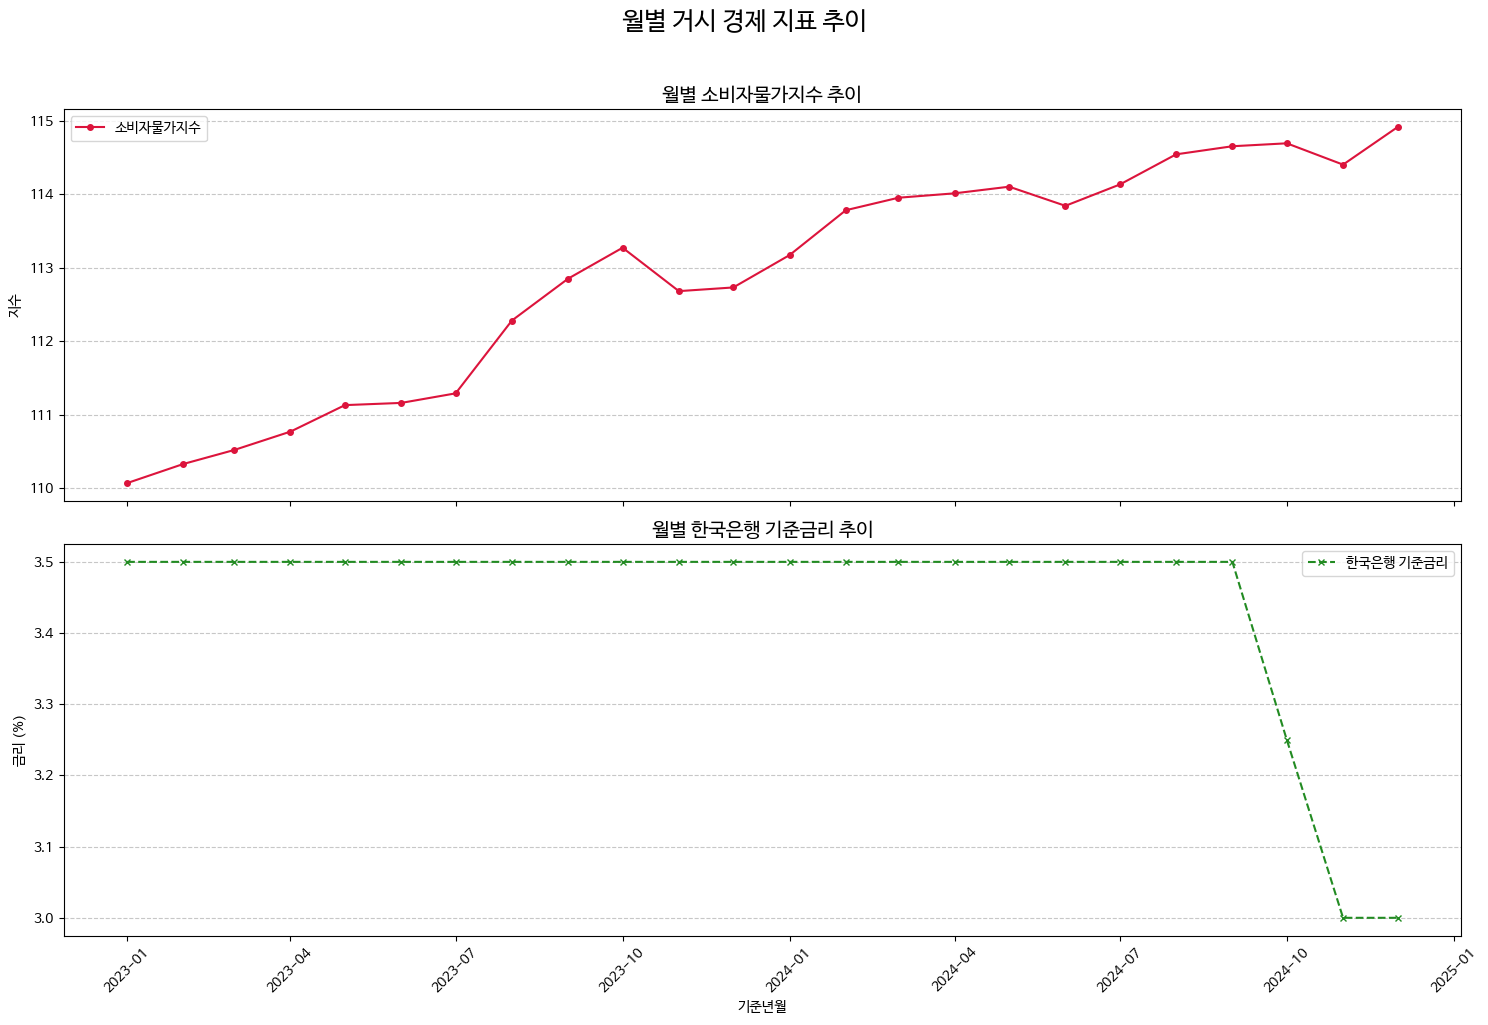

In [ ]:
# combined_macro_df의 '기준년월'을 datetime 형식으로 변환
combined_macro_df['기준년월'] = pd.to_datetime(combined_macro_df['기준년월'], format='%Y%m')

# 2개의 서브플롯을 위아래로 생성 (x축 공유)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# 첫 번째(위) 그래프: 소비자물가지수
ax1.plot(combined_macro_df['기준년월'], combined_macro_df['소비자물가지수'], color='crimson', marker='o', markersize=4, linestyle='-', label='소비자물가지수')
ax1.set_title('월별 소비자물가지수 추이', fontsize=14)
ax1.set_ylabel('지수')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# 두 번째(아래) 그래프: 한국은행 기준금리
ax2.plot(combined_macro_df['기준년월'], combined_macro_df['한국은행 기준금리'], color='forestgreen', marker='x', markersize=5, linestyle='--', label='한국은행 기준금리')
ax2.set_title('월별 한국은행 기준금리 추이', fontsize=14)
ax2.set_xlabel('기준년월')
ax2.set_ylabel('금리 (%)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

# x축 라벨 회전 및 전체 제목 설정
plt.xticks(rotation=45)
fig.suptitle('월별 거시 경제 지표 추이', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### 월별 거시 지표 및 폐업 건수 증감률 추이 비교 ###


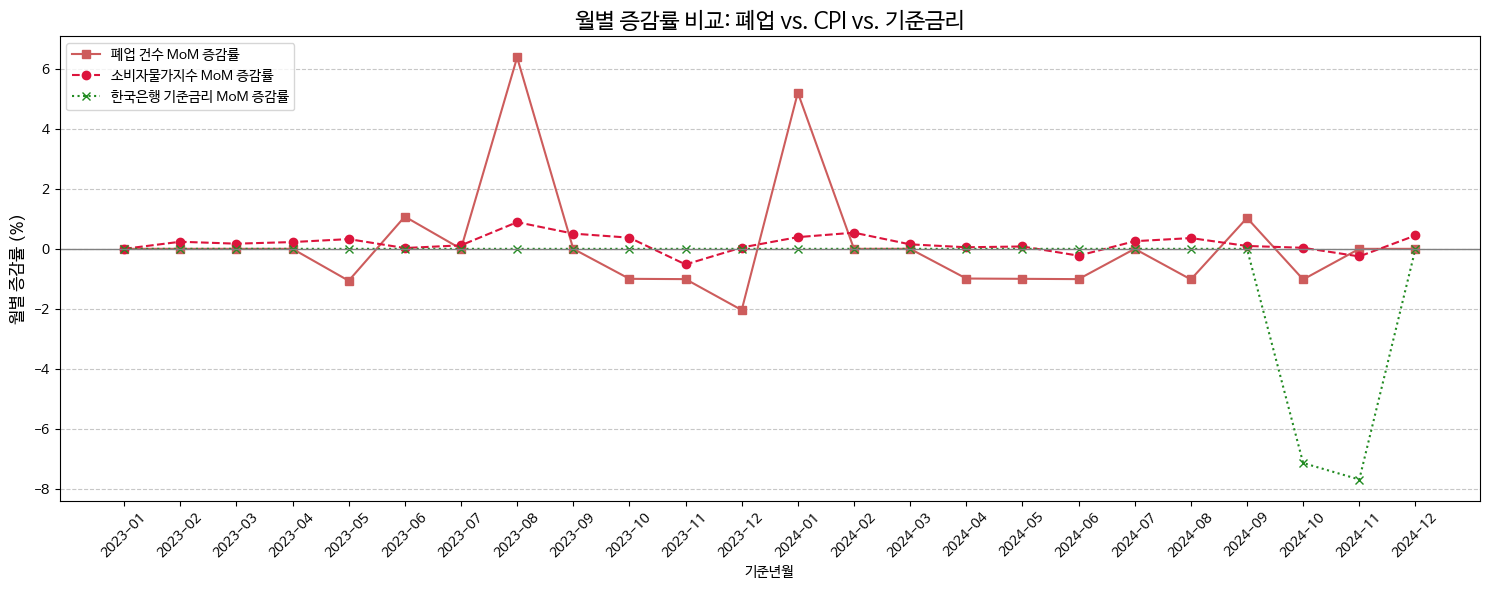

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import warnings

warnings.filterwarnings('ignore')

# 폰트 설정 (이전 설정 그대로 사용)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 준비 (이전 코드 블록에서 실행되었다고 가정) ---
# df, combined_macro_df 등의 변수가 존재해야 합니다.

# df['기준년월']을 datetime 형식으로 변환 (사용자 코드 재현)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')

# ----------------------------------------------------
# 1. 월별 데이터 집계 (IS_CLOSED, CPI, Rate)
# ----------------------------------------------------
# df에서 집계합니다.
df['기준년월_str'] = df['기준년월'].dt.strftime('%Y-%m')
monthly_agg = df.groupby('기준년월_str').agg({
    'IS_CLOSED': 'sum',
    '소비자물가지수': 'mean',
    '한국은행 기준금리': 'mean'
}).reset_index()

# '기준년월_str'을 다시 datetime으로 변환하여 정렬에 사용
monthly_agg['기준년월'] = pd.to_datetime(monthly_agg['기준년월_str'])
monthly_agg = monthly_agg.sort_values(by='기준년월').reset_index(drop=True)


# ----------------------------------------------------
# 2. 월별 증감률 (MoM Percentage Change) 계산
# ----------------------------------------------------
# .pct_change()를 사용하여 이전 달 대비 변화율을 계산합니다.
monthly_agg['IS_CLOSED_CHANGE'] = monthly_agg['IS_CLOSED'].pct_change() * 100 # %로 변환
monthly_agg['CPI_CHANGE'] = monthly_agg['소비자물가지수'].pct_change() * 100
monthly_agg['RATE_CHANGE'] = monthly_agg['한국은행 기준금리'].pct_change() * 100

# 첫 달은 NaN이므로 0으로 처리 (첫 달은 변화율 계산 불가)
monthly_agg = monthly_agg.fillna(0)


# ----------------------------------------------------
# 3. 통합 추이 시각화
# ----------------------------------------------------
print("### 월별 거시 지표 및 폐업 건수 증감률 추이 비교 ###")

fig, ax = plt.subplots(figsize=(15, 6))

# 라인 플롯 (3가지 지표의 MoM 변화율)
ax.plot(monthly_agg['기준년월_str'], monthly_agg['IS_CLOSED_CHANGE'],
        color='indianred', marker='s', linestyle='-', label='폐업 건수 MoM 증감률')
ax.plot(monthly_agg['기준년월_str'], monthly_agg['CPI_CHANGE'],
        color='crimson', marker='o', linestyle='--', label='소비자물가지수 MoM 증감률')
ax.plot(monthly_agg['기준년월_str'], monthly_agg['RATE_CHANGE'],
        color='forestgreen', marker='x', linestyle=':', label='한국은행 기준금리 MoM 증감률')

ax.set_title('월별 증감률 비교: 폐업 vs. CPI vs. 기준금리', fontsize=16)
ax.set_xlabel('기준년월')
ax.set_ylabel('월별 증감률 (%)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Y=0 선을 추가하여 증감/감소 구간 명확화
ax.axhline(0, color='gray', linestyle='-', linewidth=1)

ax.legend(loc='upper left', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 월별 거시 지표 및 매출 급락 건수 증감률 추이 비교 (3가지 지표 통합) ###


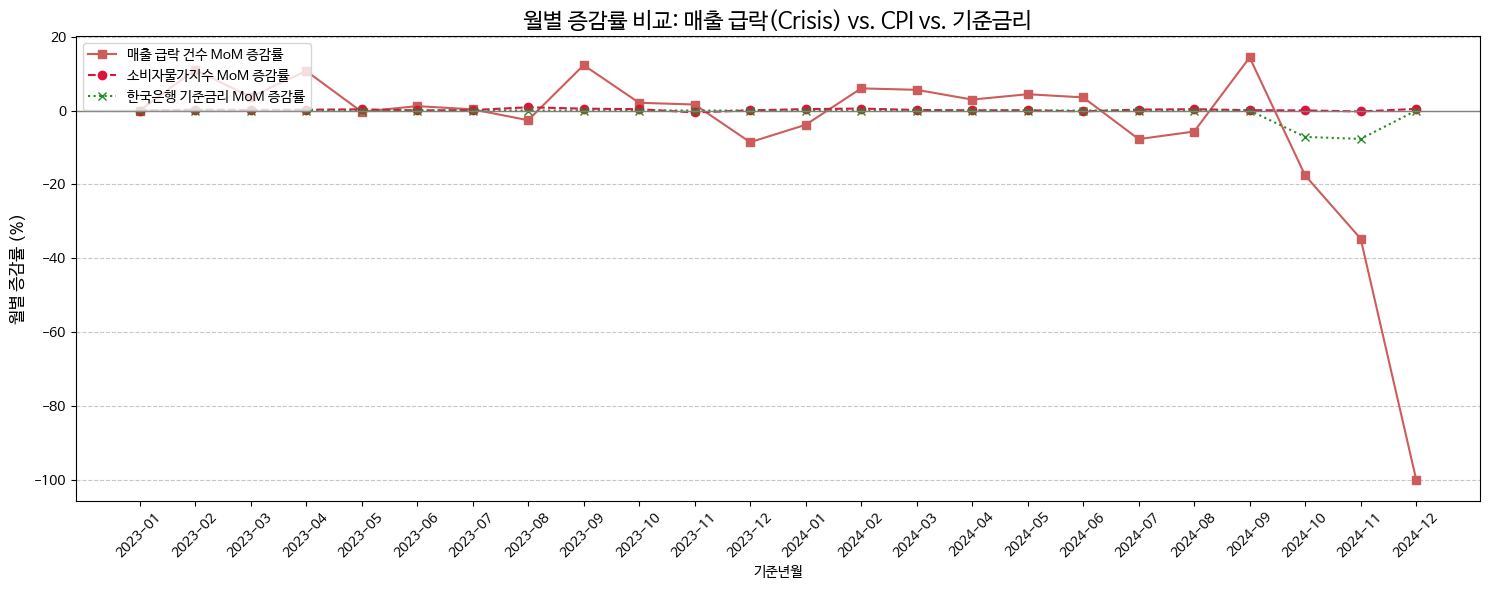

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------------------------------
# 1. 월별 데이터 집계 (CRISIS_SALES_DROP, CPI, Rate)
# ----------------------------------------------------
# df['기준년월']을 datetime 형식으로 변환 (사용자 코드 재현)
df['기준년월'] = pd.to_datetime(df['기준년월'], format='%Y%m')

# '기준년월_str' 컬럼을 다시 생성하여 집계
df['기준년월_str'] = df['기준년월'].dt.strftime('%Y-%m')

monthly_agg = df.groupby('기준년월_str').agg({
    'CRISIS_SALES_DROP': 'sum', # ⬅️ Soft Crisis 건수 합계
    '소비자물가지수': 'mean',
    '한국은행 기준금리': 'mean'
}).reset_index()

# '기준년월_str'을 다시 datetime으로 변환하여 정렬에 사용
monthly_agg['기준년월'] = pd.to_datetime(monthly_agg['기준년월_str'])
monthly_agg = monthly_agg.sort_values(by='기준년월').reset_index(drop=True)


# ----------------------------------------------------
# 2. 월별 증감률 (MoM Percentage Change) 계산
# ----------------------------------------------------
# .pct_change()를 사용하여 이전 달 대비 변화율을 계산합니다.
monthly_agg['CRISIS_CHANGE'] = monthly_agg['CRISIS_SALES_DROP'].pct_change() * 100 # %로 변환
monthly_agg['CPI_CHANGE'] = monthly_agg['소비자물가지수'].pct_change() * 100
monthly_agg['RATE_CHANGE'] = monthly_agg['한국은행 기준금리'].pct_change() * 100

# 첫 달은 NaN이므로 0으로 처리
monthly_agg = monthly_agg.fillna(0)


# ----------------------------------------------------
# 3. 통합 추이 시각화
# ----------------------------------------------------
print("### 월별 거시 지표 및 매출 급락 건수 증감률 추이 비교 (3가지 지표 통합) ###")

fig, ax = plt.subplots(figsize=(15, 6))

# 라인 플롯 (3가지 지표의 MoM 변화율)
ax.plot(monthly_agg['기준년월_str'], monthly_agg['CRISIS_CHANGE'],
        color='indianred', marker='s', linestyle='-', label='매출 급락 건수 MoM 증감률')
ax.plot(monthly_agg['기준년월_str'], monthly_agg['CPI_CHANGE'],
        color='crimson', marker='o', linestyle='--', label='소비자물가지수 MoM 증감률')
ax.plot(monthly_agg['기준년월_str'], monthly_agg['RATE_CHANGE'],
        color='forestgreen', marker='x', linestyle=':', label='한국은행 기준금리 MoM 증감률')

ax.set_title('월별 증감률 비교: 매출 급락(Crisis) vs. CPI vs. 기준금리', fontsize=16)
ax.set_xlabel('기준년월')
ax.set_ylabel('월별 증감률 (%)', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Y=0 선을 추가하여 증감/감소 구간 명확화
ax.axhline(0, color='gray', linestyle='-', linewidth=1)

ax.legend(loc='upper left', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-119160479.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=monthly_closure_counts, x='MCT_ME_D', y='Count', palette='viridis')


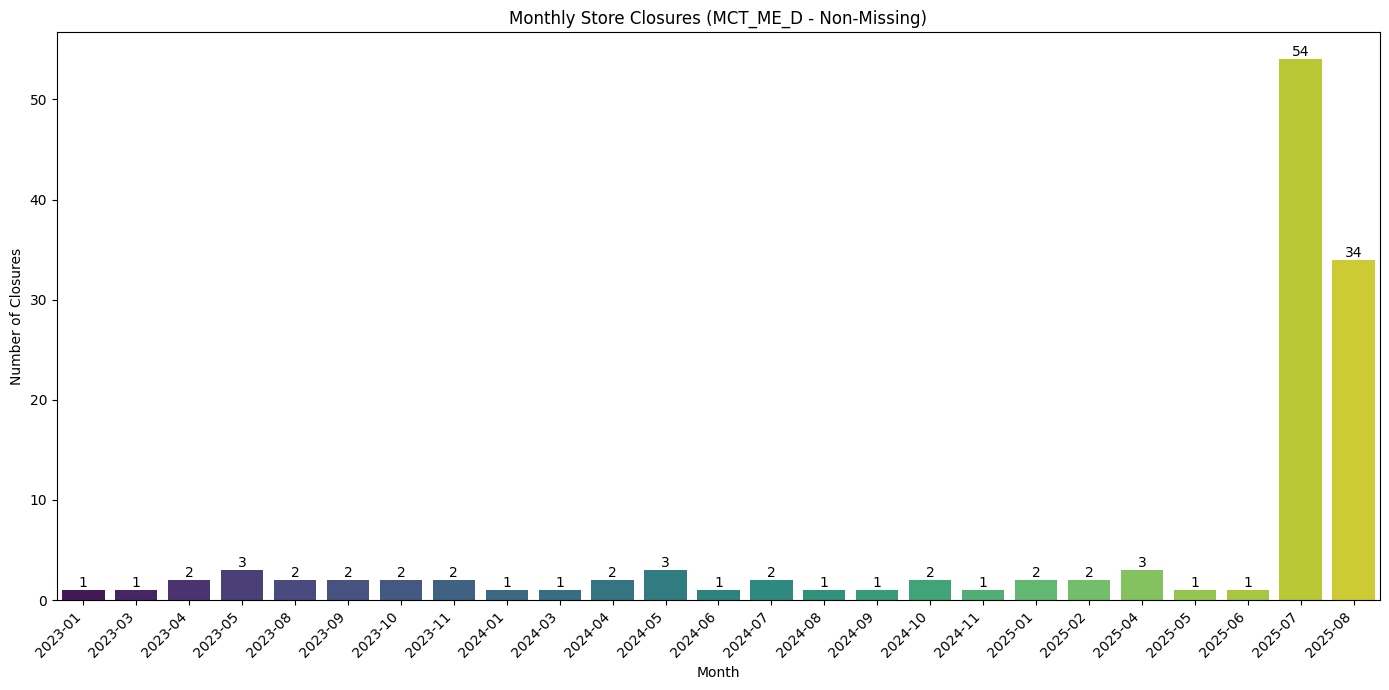

127

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# MCT_ME_D 컬럼에서 결측치가 아닌 행만 선택
non_missing_mct_me_d = df1.dropna(subset=['MCT_ME_D']).copy()

# MCT_ME_D 값을 날짜 형식으로 변환
# .0이 붙어있는 float 형태이므로 int로 먼저 변환 후 문자열로 변환
non_missing_mct_me_d['MCT_ME_D'] = non_missing_mct_me_d['MCT_ME_D'].astype(int).astype(str)

# 날짜 형식으로 변환 (오류 무시)
non_missing_mct_me_d['MCT_ME_D'] = pd.to_datetime(non_missing_mct_me_d['MCT_ME_D'], format='%Y%m%d', errors='coerce')

# 유효한 날짜만 필터링
non_missing_mct_me_d = non_missing_mct_me_d.dropna(subset=['MCT_ME_D'])

# 월별 폐업 카운트 집계
monthly_closure_counts = non_missing_mct_me_d.groupby(non_missing_mct_me_d['MCT_ME_D'].dt.to_period('M')).size().reset_index(name='Count')
monthly_closure_counts['MCT_ME_D'] = monthly_closure_counts['MCT_ME_D'].astype(str) # 시각화를 위해 문자열로 변환

# 월별 막대 그래프 시각화
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=monthly_closure_counts, x='MCT_ME_D', y='Count', palette='viridis')

# 그래프에 개수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title('Monthly Store Closures (MCT_ME_D - Non-Missing)')
plt.xlabel('Month')
plt.ylabel('Number of Closures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(len(non_missing_mct_me_d))

상권 전처리 시각화

In [ ]:
''' 컬럼명 한국어로 바꾸기'''

# data copy 생성
# df1=df1_org.copy()
# df2=df2_org.copy()
# df3=df3_org.copy()

# 컬럼 한국어로 mapping 할 수 있는 딕셔너리 생성
column_name_mapping = {
    # ============================================
    # 1. 기존에 제공했던 마스터/일반 정보 컬럼
    # ============================================
    'ENCODED_MCT': '가맹점구분번호',
    'MCT_BSE_AR': '가맹점주소',
    'MCT_NM': '가맹점명',
    'MCT_BRD_NUM': '브랜드구분코드',
    'MCT_SIGUNGU_NM': '가맹점지역',
    'HPSN_MCT_ZCD_NM': '업종',
    'HPSN_MCT_BZN_CD_NM': '상권',
    'ARE_D': '개설일',
    'MCT_ME_D': '폐업일',
    'TA_YM': '기준년월',
    'MCT_OPE_MS_CN': '가맹점 운영개월수 구간',
    'RC_M1_SAA': '매출금액 구간',
    'RC_M1_TO_UE_CT': '매출건수 구간',
    'RC_M1_UE_CUS_CN': '유니크 고객 수 구간',
    'RC_M1_AV_NP_AT': '객단가 구간',
    'APV_CE_RAT': '취소율 구간',
    'DLV_SAA_RAT': '배달매출금액 비율',
    'M1_SME_RY_SAA_RAT': '동일 업종 매출금액 비율',
    'M1_SME_RY_CNT_RAT': '동일 업종 매출건수 비율',
    'M12_SME_RY_SAA_PCE_RT': '동일 업종 내 매출 순위 비율',
    'M12_SME_BZN_SAA_PCE_RT': '동일 상권 내 매출 순위 비율',
    'M12_SME_RY_ME_MCT_RAT': '동일 업종 내 해지 가맹점 비중',
    'M12_SME_BZN_ME_MCT_RAT': '동일 상권 내 해지 가맹점 비중',

    # ============================================
    # 2. 새로 추가된 고객/이용 패턴 관련 컬럼
    # ============================================
    # 고객 성별/연령대 비중
    'M12_MAL_1020_RAT': '남성 20대이하 고객 비중',
    'M12_MAL_30_RAT': '남성 30대 고객 비중',
    'M12_MAL_40_RAT': '남성 40대 고객 비중',
    'M12_MAL_50_RAT': '남성 50대 고객 비중',
    'M12_MAL_60_RAT': '남성 60대이상 고객 비중',
    'M12_FME_1020_RAT': '여성 20대이하 고객 비중',
    'M12_FME_30_RAT': '여성 30대 고객 비중',
    'M12_FME_40_RAT': '여성 40대 고객 비중',
    'M12_FME_50_RAT': '여성 50대 고객 비중',
    'M12_FME_60_RAT': '여성 60대이상 고객 비중',

    # 고객 유형 및 재방문
    'MCT_UE_CLN_REU_RAT': '재방문 고객 비중',
    'MCT_UE_CLN_NEW_RAT': '신규 고객 비중',

    # 고객 이용 목적 (거주/직장/유동)
    'RC_M1_SHC_RSD_UE_CLN_RAT': '거주 이용 고객 비율',
    'RC_M1_SHC_WP_UE_CLN_RAT': '직장 이용 고객 비율',
    'RC_M1_SHC_FLP_UE_CLN_RAT': '유동인구 이용 고객 비율'
}

# 컬럼이름 한국어로 바꾸기
df1.rename(columns=column_name_mapping, inplace=True)
# df2.rename(columns=column_name_mapping, inplace=True)
# df1.rename(columns=column_name_mapping, inplace=True)

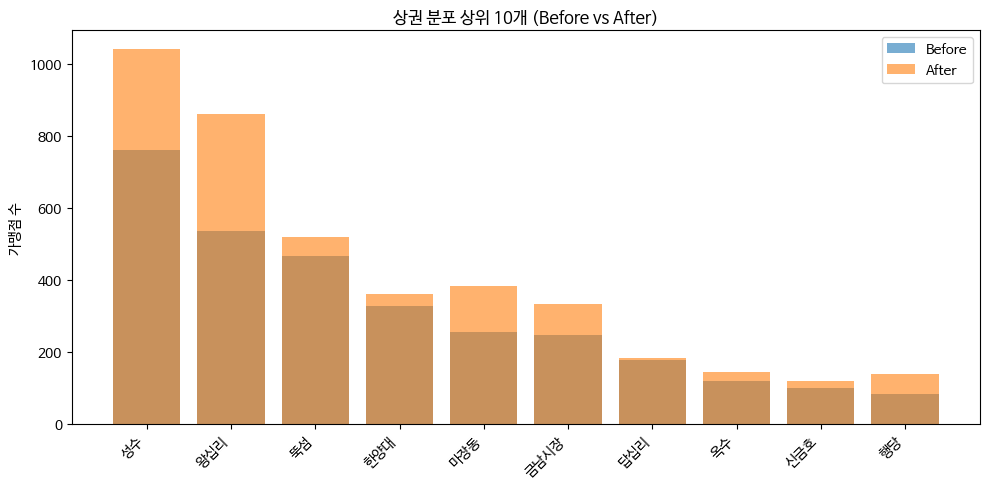

In [ ]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

topN = 10
before_counts = df1['상권'].value_counts().head(topN)
after_counts = df1_pre['상권'].value_counts().head(topN)

plt.figure(figsize=(10,5))
plt.bar(before_counts.index, before_counts.values, alpha=0.6, label='Before')
plt.bar(after_counts.index, after_counts.values, alpha=0.6, label='After')
plt.xticks(rotation=45, ha='right')
plt.ylabel("가맹점 수")
plt.title("상권 분포 상위 10개 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 두 데이터프레임을 ID 기준으로 병합
compare_df = df1[['가맹점구분번호','상권']].merge(
    df1_pre[['가맹점구분번호','상권']],
    on='가맹점구분번호',
    suffixes=('_before', '_after')
)

# 상권이 달라진 경우만 필터링
changed = compare_df[compare_df['상권_before'] != compare_df['상권_after']]

print(f"🏪 상권이 변경된 점포 수: {len(changed)}개")
display(changed.head(10))


🏪 상권이 변경된 점포 수: 1047개


가맹점구분번호 상권_before 상권_after
6   9A71D71270       NaN      마장동
9   27C88660A5       NaN   장한평자동차
15  E863289A7D       NaN      왕십리
18  3E35A71757       NaN      마장동
19  5017C6924A       NaN      마장동
20  888828B4FB       NaN      마장동
21  06C463E9D9       NaN      마장동
22  5AEEA3B4EF       NaN      마장동
23  1400634946       NaN      마장동
24  3E61C339E2       NaN      마장동

In [ ]:
df1_pre

가맹점구분번호                가맹점주소          가맹점명        업종   상권  \
0     16184E93D9           서울 성동구 마장동          성우**       축산물  마장동   
1     4D039EA8B7           서울 성동구 마장동          대보**       축산물  마장동   
2     0074C4990A           서울 성동구 마장동          대용**       축산물  마장동   
3     68308F2746           서울 성동구 마장동          통일**       축산물  마장동   
4     4117EDDE9C           서울 성동구 마장동          한울**       축산물  마장동   
...          ...                  ...           ...       ...  ...   
4180  7FCF23E6F3    서울특별시 성동구 마장로 137  아이**********  아이스크림/빙수  왕십리   
4181  9743B78531      서울 성동구 독서당로 223          어반**        양식   옥수   
4182  C2261977A8  서울특별시 성동구 마장로35길 76          한성**       축산물  마장동   
4183  F1C69918DF      서울 성동구 왕십리로 410          국수**  한식-국수/만두  왕십리   
4184  58B8C943BF     서울특별시 성동구 매봉길 50      아이******  아이스크림/빙수   옥수   

             개설일  폐업일        LAT         LNG  브랜드구분코드_FREQ  
0     2013-03-20  NaN  37.566380  127.045326      0.870490  
1     2013-11-22  NaN  37.566380  127.045326      0.870490  
2     2014-05-12  NaN  37.566380  127.045326      0.870490  
3     2015-11-24  NaN  37.566380  127.045326      0.870490  
4     2015-12-11  NaN  37.566380  127.045326      0.870490  
...          ...  ...        ...         ...           ...  
4180  2023-08-21  NaN  37.567825  127.025054      0.870490  
4181  2013-03-05  NaN  37.544271  127.015192      0.870490  
4182  2023-05-17  NaN  37.570263  127.041997      0.870490  
4183  2021-10-07  NaN  37.566603  127.024082      0.000478  
4184  2023-03-03  NaN  37.547299  127.012189      0.870490  

[4185 rows x 10 columns]

In [ ]:
import folium

m = folium.Map(location=[37.56, 127.03], zoom_start=13)

# 결측이었던 점포 (빨간색) - 좌표는 df1_pre에서 가져옴
for _, r in df1[df1['상권'].isna()].iterrows():
    # df1_pre에서 해당 가맹점의 LAT, LNG 찾기
    store_id = r['가맹점구분번호']
    coords = df1_pre.loc[df1_pre['가맹점구분번호'] == store_id, ['LAT', 'LNG']]

    if not coords.empty:
        lat = coords['LAT'].values[0]
        lng = coords['LNG'].values[0]
        folium.CircleMarker([lat, lng], radius=3, color='red', fill=True, tooltip=f"{store_id} (Before NaN)").add_to(m)

# 새로 채워진 점포 (파란색) - 좌표는 changed DataFrame에서 바로 가져옴
for _, r in changed.iterrows():
    # changed DataFrame은 이미 df1_pre와 병합되었으므로 LAT, LNG 컬럼이 있음
    lat = df1_pre.loc[df1_pre['가맹점구분번호'] == r['가맹점구분번호'], 'LAT'].values[0]
    lng = df1_pre.loc[df1_pre['가맹점구분번호'] == r['가맹점구분번호'], 'LNG'].values[0]
    folium.CircleMarker([lat, lng], radius=3, color='blue', fill=True, tooltip=f"{r['가맹점구분번호']} (After {r['상권_after']})").add_to(m)

m.save("상권_전후비교.html")
m

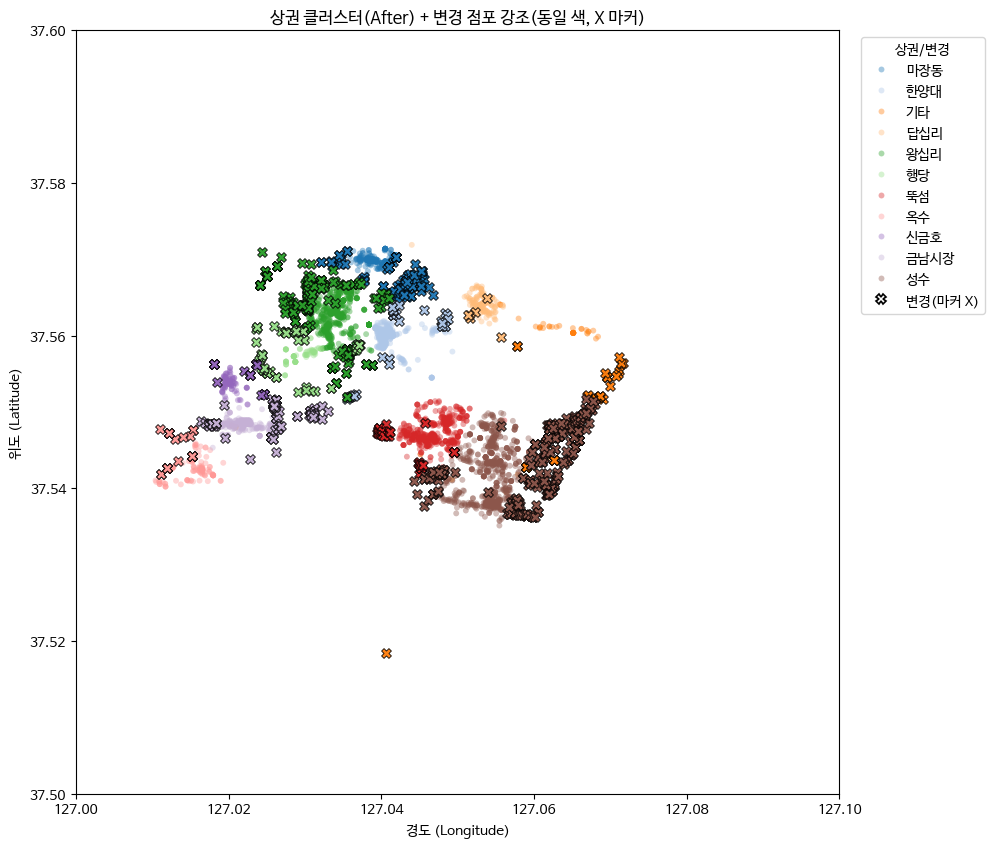

✅ 저장 완료: bizzone_clusters_changed_samecolor_X.png


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 한글 폰트 설정 적용
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# df1_pre에는 이미 LAT, LNG 컬럼이 있습니다.
# df1 (df_before)에 LAT, LNG 컬럼을 추가하기 위해 df1_pre와 병합합니다.
df_before = df1.copy()
# df1_pre에서 가맹점구분번호, LAT, LNG 컬럼만 선택
coords_df = df1_pre[['가맹점구분번호', 'LAT', 'LNG']].drop_duplicates(subset=['가맹점구분번호'])
# df_before에 좌표 정보 병합
df_before = pd.merge(df_before, coords_df, on='가맹점구분번호', how='left')

df_after  = df1_pre.copy() # df_after는 이미 df1_pre이므로 좌표 정보가 있습니다.


ID_COL, BZN_COL, LAT_COL, LNG_COL = '가맹점구분번호', '상권', 'LAT', 'LNG'

# 좌표 결측치 제거
df_before = df_before.dropna(subset=[LAT_COL, LNG_COL])
df_after  = df_after.dropna(subset=[LAT_COL, LNG_COL])


# 전/후 상권 비교해 변경 여부 플래그
cmp = df_before[[ID_COL, BZN_COL]].merge(
    df_after[[ID_COL, BZN_COL]],
    on=ID_COL, how='inner', suffixes=('_before', '_after')
)
# 상권이 변경되거나, before가 NaN인데 after가 NaN이 아닌 경우
changed_ids = cmp[
    (cmp[f'{BZN_COL}_before'] != cmp[f'{BZN_COL}_after']) |
    (cmp[f'{BZN_COL}_before'].isna() & cmp[f'{BZN_COL}_after'].notna())
][ID_COL]
df_after['CHANGED'] = df_after[ID_COL].isin(changed_ids)

# 상위 N개 라벨 + 기타
TOP_N = 10
top_labels = df_after[BZN_COL].value_counts().head(TOP_N).index.tolist()
df_after['상권_plot'] = np.where(df_after[BZN_COL].isin(top_labels), df_after[BZN_COL], '기타')

# 팔레트(상권별 고정 색)
unique_labels = df_after['상권_plot'].unique().tolist()
base_colors = sns.color_palette('tab20', n_colors=len(unique_labels))
palette = {lab: base_colors[i] for i, lab in enumerate(unique_labels)}

plt.figure(figsize=(10,10))

# 1) 배경: 상권별 색 (투명도 낮게)
sns.scatterplot(
    data=df_after, x=LNG_COL, y=LAT_COL,
    hue='상권_plot', palette=palette,
    s=18, alpha=0.40, linewidth=0
)

# 2) 변경점: 같은 색으로 X 마커로 오버레이
changed = df_after[df_after['CHANGED']]
for lab in unique_labels:
    sub = changed[changed['상권_plot'] == lab]
    if sub.empty:
        continue
    plt.scatter(
        sub[LNG_COL], sub[LAT_COL],
        s=50, marker='X', c=[palette[lab]],  # ← 상권 컬러와 동일
        edgecolors='k', linewidths=0.6, alpha=0.95, zorder=3
    )

plt.title('상권 클러스터(After) + 변경 점포 강조(동일 색, X 마커)')
plt.xlabel('경도 (Longitude)'); plt.ylabel('위도 (Latitude)')
plt.xlim(127.0, 127.1); plt.ylim(37.5, 37.6)
plt.gca().set_aspect('equal', adjustable='box')

# 범례: 상권 색 + "X=변경" 안내 하나만 추가
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))
# 변경 마커 범례 추가 (색상은 임의로 검정색 사용)
uniq['변경(마커 X)'] = Line2D([0],[0], marker='X', color='k', linestyle='',
                              markerfacecolor='none', markeredgewidth=1.2, markersize=7,
                              label='변경(마커 X)')
plt.legend(uniq.values(), uniq.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.0), title='상권/변경')


plt.tight_layout()
plt.savefig('bizzone_clusters_changed_samecolor_X.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 저장 완료: bizzone_clusters_changed_samecolor_X.png")

In [ ]:
01. VPC 생성
    AI-SUN-PRD-VPC : 10.250.0.0/16  (65,563)

02. Subnet 생성

    1) AZ : 2A
     AI-SUN-PRD-VPC-PUB-2A    (10.250.4.0/24) - 251      AI-SUN-PRD-VPC-PUB-SG-2A (80,443)
     ### ec2 name: AI-SUN-PRD-VPC-Docker-PUB-2A : 10.250.4.107

     AI-SUN-PRD-VPC-WAS-PRI-2A     (10.250.2.0/24) - 251      AI-SUN-PRD-VPC-WAS-PRI-SG-2A
     ### ec2 name: AI-SUN-PRD-VPC-WAS-PRI-2A : 10.250.2.115

   2) AZ : 2C

     AI-SUN-PRD-VPC-PUB-2C    (10.250.12.0/24) - 251      AI-SUN-PRD-PUB-SG-2C
     ### ec2 name: AI-SUN-PRD-VPC-WAS-PRI-2C  : 10.250.12.254

      AI-SUN-PRD-VPC-WAS-PRI-2C     (10.250.14.0/24) - 251      AI-SUN-PRD-VPC-WAS-PRI-SG-2A
     ### ec2 name: AI-SUN-PRD-VPC-WAS-PRI-2C : 10.250.14.115

03. Routing 테이블 생성

    AI-SUN-PRD-RT-PUB-2A     AI-SUN-PRD-RT-PUB
    AI-SUN-PRD-RT-PUB-2C
    AI-SUN-PRD-RT-PRI-2A     AI-SUN-PRD-RT-PRI
    AI-SUN-PRD-RT-PRI-2C

04. Internet Gateway 생성
    (Pubic Subnet에 있는 인스턴스가 인터넷을 사용할 수 있도록 해주기 위함)
    AI-SUN-PRD-IGW

05. NAT GATEWAY 생성
   (Private Subnet에 있는 인스턴스가 인터넷을 사용할 수 있도록 해주기 위함)
   (연결유형 Public / 탄력적 IP 부여하고 PUB SUBNET에 붙입니다)
    AI-SUN-PRD-NGW-2A   -- 우리 실습환경
    # 우리는 만들지 않음. AI-SUN-PRD-NGW-2C   -- 이중화를 위해 구성하는 것을 권고함.

########################## 그 외에 우리가 추가할 것들 #####################################
06. KeyPair 이름 : 본인키페어.pem

07. Linux 연결사용자계정 : ubuntu 패스워드는 없음.
   EC2 2개 IP (WAS)

11. ALB Security Name(보안그룹) : AI-SUN-PRD-ALB-SG  (80,443)

12. Target Group(대상 그룹, EC2로 이동 후 작업)      : AI-SUN-PRD-ALB-TG

13. ALB Name          : AI-SUN-PRD-ALB

14. Autoscaling Name  : AI-SUN-PRD-WAS-Auto

15. 시작템플릿 이름   : AI-SUN-PRD-WAS-TEMP



In [ ]:
import folium
from folium.plugins import MarkerCluster
import matplotlib.colors as mcolors

# 지도 생성
m = folium.Map(location=[37.56, 127.03], zoom_start=13, tiles='cartodbpositron')

# -------------------------------
# 1️⃣ 상권별 팔레트 색상 고정
# -------------------------------
unique_labels = df1_pre['상권'].unique().tolist()
base_colors = list(mcolors.TABLEAU_COLORS.values())
palette = {lab: base_colors[i % len(base_colors)] for i, lab in enumerate(unique_labels)}

# -------------------------------
# 2️⃣ 변경점포 표시 준비
# -------------------------------
# df_after에서 CHANGED 여부 표시 (이미 있다고 가정)
changed = df1_pre[df1_pre['가맹점구분번호'].isin(changed_ids)]
unchanged = df1_pre[~df1_pre['가맹점구분번호'].isin(changed_ids)]

# 마커 클러스터링 추가 (시각적 정돈)
marker_cluster = MarkerCluster().add_to(m)

# -------------------------------
# 3️⃣ 상권별 색상 마커 추가
# -------------------------------
for _, row in unchanged.iterrows():
    color = palette.get(row['상권'], 'gray')
    folium.CircleMarker(
        location=[row['LAT'], row['LNG']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        tooltip=f"{row['가맹점명']} ({row['상권']})"
    ).add_to(marker_cluster)

# -------------------------------
# 4️⃣ 변경된 점포: X 마커로 표시
# -------------------------------
for _, row in changed.iterrows():
    color = palette.get(row['상권'], 'black')
    folium.Marker(
        location=[row['LAT'], row['LNG']],
        icon=folium.plugins.BeautifyIcon(
            icon='x',
            icon_shape='marker',
            number=1,
            border_color=color,
            text_color='white',
            background_color=color
        ),
        tooltip=f"[변경] {row['가맹점명']} → {row['상권']}"
    ).add_to(marker_cluster)

# -------------------------------
# 5️⃣ 범례 추가
# -------------------------------
legend_html = """
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 230px; height: 270px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     overflow: auto;">
&nbsp;<b>상권별 색상 범례</b><br>
"""
for lab, col in palette.items():
    legend_html += f"&nbsp;<i style='background:{col};width:10px;height:10px;display:inline-block;'></i>&nbsp;{lab}<br>"
legend_html += "<br>&nbsp;<i style='background:black;width:10px;height:10px;display:inline-block;'></i> 변경 점포(X마커)"
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# -------------------------------
# 6️⃣ 저장 및 표시
# -------------------------------
m.save("상권_전후비교_강화.html")
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import folium
from folium.plugins import MarkerCluster, BeautifyIcon
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

# ------------------------------------------------
# 준비: df1_pre (after), df1 (before) 가정
# ------------------------------------------------
df_after = df1_pre.copy()
ID_COL, BZN_COL, LAT_COL, LNG_COL = '가맹점구분번호', '상권', 'LAT', 'LNG'

# 만약 CHANGED 플래그가 없다면 자동 계산
if 'CHANGED' not in df_after.columns:
    # df1에 좌표가 없을 수 있으니 after에서 좌표만 가져와 merge
    coords_df = df_after[[ID_COL, LAT_COL, LNG_COL]].drop_duplicates(subset=[ID_COL])
    df_before = pd.merge(df1.copy(), coords_df, on=ID_COL, how='left')
    cmp = df_before[[ID_COL, BZN_COL]].merge(
        df_after[[ID_COL, BZN_COL]],
        on=ID_COL, how='inner', suffixes=('_before', '_after')
    )
    changed_ids = cmp[
        (cmp[f'{BZN_COL}_before'] != cmp[f'{BZN_COL}_after']) |
        (cmp[f'{BZN_COL}_before'].isna() & cmp[f'{BZN_COL}_after'].notna())
    ][ID_COL]
    df_after['CHANGED'] = df_after[ID_COL].isin(changed_ids)

# -------------------------------
# 1) 상권별 팔레트 (Top N + 기타)
# -------------------------------
TOP_N = 10
top_labels = df_after[BZN_COL].value_counts().head(TOP_N).index.tolist()
df_after['상권_plot'] = np.where(df_after[BZN_COL].isin(top_labels), df_after[BZN_COL], '기타')

unique_labels = df_after['상권_plot'].unique().tolist()
palette_sns = sns.color_palette('tab20', n_colors=len(unique_labels))
palette = {lab: mcolors.to_hex(palette_sns[i]) for i, lab in enumerate(unique_labels)}

# -------------------------------
# 2) Folium 지도 생성/레이어
# -------------------------------
center = [df_after[LAT_COL].mean(), df_after[LNG_COL].mean()]
m = folium.Map(location=center, zoom_start=13, tiles='CartoDB positron')

fg_all = folium.FeatureGroup(name='(배경) 전체 점포(상권 색)', show=True).add_to(m)
fg_changed = folium.FeatureGroup(name='(강조) 상권 변경/채움 점포 (X)', show=True).add_to(m)

cluster_all = MarkerCluster(name='배경 클러스터').add_to(fg_all)
cluster_changed = MarkerCluster(name='변경점 클러스터').add_to(fg_changed)

# -------------------------------
# 3) 배경: 모든 점포 (상권 색 동그라미)
# -------------------------------
for _, r in df_after.iterrows():
    col = palette.get(r['상권_plot'], '#888888')
    folium.CircleMarker(
        location=[r[LAT_COL], r[LNG_COL]],
        radius=3, color=col, fill=True, fill_color=col, fill_opacity=0.45,
        weight=0.5,
        tooltip=f"{r.get('가맹점명','') or ''} / 상권: {r[BZN_COL]}"
    ).add_to(cluster_all)

# -------------------------------
# 4) 변경/채움 점포: X 마커 (상권 색 유지)
# -------------------------------
changed_df = df_after[df_after['CHANGED']].copy()
for _, r in changed_df.iterrows():
    col = palette.get(r['상권_plot'], '#000000')
    folium.Marker(
        location=[r[LAT_COL], r[LNG_COL]],
        icon=BeautifyIcon(
            icon='x',              # X 문자
            icon_shape='marker',   # 말핀 형태
            background_color=col,  # 상권 색 유지
            text_color='white',
            border_color=col,
            border_width=2
        ),
        tooltip=f"🔁 변경/채움 • 상권: {r[BZN_COL]} • 점포: {r.get('가맹점명','') or ''}"
    ).add_to(cluster_changed)

# -------------------------------
# 5) 범례 + 레이어 컨트롤
# -------------------------------
legend_items = ''.join(
    [f'<div style="margin:2px">'
     f'<span style="display:inline-block;width:10px;height:10px;background:{palette[l]};'
     f'margin-right:6px;border:1px solid #999"></span>{l}</div>'
     for l in unique_labels]
)
legend_html = f"""
<div style="
 position: fixed; bottom: 20px; left: 20px; z-index: 9999;
 background: white; padding: 10px 12px; border: 1px solid #aaa; border-radius: 6px;
 font-size: 12px; max-height: 280px; overflow:auto;">
<b>상권 색상</b>{legend_items}
<div style="margin-top:6px">
<span style="display:inline-block;width:12px;height:12px;background:#000;color:#fff;
 text-align:center;line-height:12px;border-radius:2px;margin-right:6px;font-weight:bold;">X</span>
변경/채움 점포
</div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl(collapsed=False).add_to(m)

# 뷰포트 자동 맞춤
m.fit_bounds([[df_after[LAT_COL].min(), df_after[LNG_COL].min()],
              [df_after[LAT_COL].max(), df_after[LNG_COL].max()]])

# 저장
m.save("상권_전후비교_인터랙티브_X마커.html")
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import folium
from folium.plugins import MarkerCluster
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

# ------------------------------------
# 0️⃣ 데이터 준비
# ------------------------------------
df_after = df1_pre.copy()  # 상권 전처리 완료된 최종 데이터프레임
ID_COL, BZN_COL, LAT_COL, LNG_COL = '가맹점구분번호', '상권', 'LAT', 'LNG'

# ------------------------------------
# 1️⃣ 상권별 팔레트 구성 (Top N + 기타)
# ------------------------------------
TOP_N = 10
top_labels = df_after[BZN_COL].value_counts().head(TOP_N).index.tolist()
df_after['상권_plot'] = np.where(df_after[BZN_COL].isin(top_labels), df_after[BZN_COL], '기타')

unique_labels = df_after['상권_plot'].unique().tolist()
palette_sns = sns.color_palette('tab20', n_colors=len(unique_labels))
palette = {lab: mcolors.to_hex(palette_sns[i]) for i, lab in enumerate(unique_labels)}

# ------------------------------------
# 2️⃣ 지도 생성
# ------------------------------------
center = [df_after[LAT_COL].mean(), df_after[LNG_COL].mean()]
m = folium.Map(location=center, zoom_start=13, tiles='CartoDB positron')

# 레이어 그룹 생성
fg_bg = folium.FeatureGroup(name='배경 (전체 상권)', show=True).add_to(m)
fg_changed = folium.FeatureGroup(name='상권 변경 점포', show=True).add_to(m)

# ------------------------------------
# 3️⃣ 변경된 점포 식별
# ------------------------------------
# 이전 상권 정보가 포함된 df_before가 있다면 비교
cmp = df_before[[ID_COL, BZN_COL]].merge(
    df_after[[ID_COL, BZN_COL]], on=ID_COL, how='inner', suffixes=('_before', '_after')
)
changed_ids = cmp[
    (cmp[f'{BZN_COL}_before'] != cmp[f'{BZN_COL}_after']) |
    (cmp[f'{BZN_COL}_before'].isna() & cmp[f'{BZN_COL}_after'].notna())
][ID_COL]
df_after['CHANGED'] = df_after[ID_COL].isin(changed_ids)

# ------------------------------------
# 4️⃣ 변경되지 않은 점포: 외곽선만 표시
# ------------------------------------
unchanged = df_after[~df_after['CHANGED']]

for _, r in unchanged.iterrows():
    col = palette.get(r['상권_plot'], '#999999')
    folium.CircleMarker(
        location=[r[LAT_COL], r[LNG_COL]],
        radius=4,
        color=col,
        fill=False,              # 채우지 않음
        weight=0.7,              # 얇은 외곽선
        opacity=0.25,            # 희미하게 표시
        popup=f"상권: {r['상권']}<br>가맹점명: {r.get('가맹점명','')}"
    ).add_to(fg_bg)

# ------------------------------------
# 5️⃣ 변경된 점포: 굵은 링으로 강조
# ------------------------------------
changed = df_after[df_after['CHANGED']]

for _, r in changed.iterrows():
    col = palette.get(r['상권_plot'], 'black')
    folium.CircleMarker(
        location=[r[LAT_COL], r[LNG_COL]],
        radius=7,
        color=col,
        fill=False,
        weight=3,
        opacity=1.0,
        popup=folium.Popup(
            f"<b>🔁 변경된 점포</b><br>상권: {r['상권']}<br>가맹점명: {r.get('가맹점명','')}",
            max_width=300
        )
    ).add_to(fg_changed)

# ------------------------------------
# 6️⃣ 범례 추가
# ------------------------------------
legend_items = ''.join(
    [f'<div style="margin:2px">'
     f'<span style="display:inline-block;width:12px;height:12px;background:{palette[l]};'
     f'margin-right:6px;border:1px solid #555"></span>{l}</div>'
     for l in unique_labels]
)
legend_html = f"""
<div style="
 position: fixed; bottom: 20px; left: 20px; z-index: 9999;
 background: white; padding: 10px 12px; border: 1px solid #aaa; border-radius: 6px;
 font-size: 12px;">
<b>상권별 색상</b><br>{legend_items}
<div style="margin-top:6px">
<span style="display:inline-block;width:12px;height:12px;border:3px solid #000;border-radius:12px;margin-right:6px"></span>
변경 점포 (굵은 링)
</div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ------------------------------------
# 7️⃣ 마무리
# ------------------------------------
folium.LayerControl(collapsed=False).add_to(m)
m.fit_bounds([[df_after[LAT_COL].min(), df_after[LNG_COL].min()],
              [df_after[LAT_COL].max(), df_after[LNG_COL].max()]])
m.save("상권_변경_외곽선_강조지도.html")
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import branca.colormap as cm

# ------------------------------------------------
# 0) 데이터 준비
# ------------------------------------------------
df_after = df1_pre.copy()
ID_COL, BZN_COL, LAT_COL, LNG_COL = '가맹점구분번호', '상권', 'LAT', 'LNG'

# CHANGED 없으면 자동 계산 (df_before와 비교)
if 'CHANGED' not in df_after.columns:
    coords_df = df_after[[ID_COL, LAT_COL, LNG_COL]].drop_duplicates(subset=[ID_COL])
    df_before = pd.merge(df1.copy(), coords_df, on=ID_COL, how='left')
    cmp = df_before[[ID_COL, BZN_COL]].merge(
        df_after[[ID_COL, BZN_COL]], on=ID_COL, how='inner', suffixes=('_before', '_after')
    )
    changed_ids = cmp[
        (cmp[f'{BZN_COL}_before'] != cmp[f'{BZN_COL}_after']) |
        (cmp[f'{BZN_COL}_before'].isna() & cmp[f'{BZN_COL}_after'].notna())
    ][ID_COL]
    df_after['CHANGED'] = df_after[ID_COL].isin(changed_ids)

# 좌표 결측 제거
df_after = df_after.dropna(subset=[LAT_COL, LNG_COL])

# ------------------------------------------------
# 1) 상권 팔레트 (Top N + 기타)
# ------------------------------------------------
TOP_N = 10
top_labels = df_after[BZN_COL].value_counts().head(TOP_N).index.tolist()
df_after['상권_plot'] = np.where(df_after[BZN_COL].isin(top_labels), df_after[BZN_COL], '기타')

unique_labels = df_after['상권_plot'].unique().tolist()
palette_sns = sns.color_palette('tab20', n_colors=len(unique_labels))
palette = {lab: mcolors.to_hex(palette_sns[i]) for i, lab in enumerate(unique_labels)}

# ------------------------------------------------
# 2) 베이스 지도 + 레이어
# ------------------------------------------------
center = [df_after[LAT_COL].mean(), df_after[LNG_COL].mean()]
m = folium.Map(location=center, zoom_start=13, tiles='CartoDB positron')

fg_bg       = folium.FeatureGroup(name='배경(외곽선: 변경 無)', show=True).add_to(m)
fg_changed  = folium.FeatureGroup(name='상권 변경 점포 (X)', show=True).add_to(m)
fg_heat_all = folium.FeatureGroup(name='HeatMap: 전체 점포', show=False).add_to(m)
fg_heat_chg = folium.FeatureGroup(name='HeatMap: 변경 점포', show=False).add_to(m)
fg_rate     = folium.FeatureGroup(name='상권별 변경비율(%)', show=True).add_to(m)

# ------------------------------------------------
# 3) 배경: 변경되지 않은 점포는 외곽선만
# ------------------------------------------------
unchanged = df_after[~df_after['CHANGED']]
for _, r in unchanged.iterrows():
    col = palette.get(r['상권_plot'], '#999999')
    folium.CircleMarker(
        location=[r[LAT_COL], r[LNG_COL]],
        radius=4, color=col, fill=False,
        weight=0.7, opacity=0.25,
        tooltip=f"{r.get('가맹점명','')} / 상권:{r[BZN_COL]}"
    ).add_to(fg_bg)

# ------------------------------------------------
# 4) 변경된 점포: X 마커 (상권색 배경)
# ------------------------------------------------
changed = df_after[df_after['CHANGED']]
for _, r in changed.iterrows():
    col = palette.get(r['상권_plot'], '#000000')
    folium.Marker(
        location=[r[LAT_COL], r[LNG_COL]],
        icon=BeautifyIcon(icon='x', icon_shape='marker',
                          background_color=col, text_color='white',
                          border_color=col, border_width=2),
        tooltip=f"🔁 변경/채움 • 상권:{r[BZN_COL]} • {r.get('가맹점명','')}"
    ).add_to(fg_changed)

# ------------------------------------------------
# 5) HeatMap (전체 / 변경)
# ------------------------------------------------
heat_all = df_after[[LAT_COL, LNG_COL]].values.tolist()
HeatMap(heat_all, radius=12, blur=18, max_zoom=16).add_to(fg_heat_all)

heat_chg = changed[[LAT_COL, LNG_COL]].values.tolist()
if heat_chg:  # 변경점이 있을 때만
    HeatMap(heat_chg, radius=14, blur=20, max_zoom=16).add_to(fg_heat_chg)

# ------------------------------------------------
# 6) 상권별 변경비율(%) 비례심볼
#    - 상권별 중심점(평균 위경도) + 변경비율(변경수/전체수)
# ------------------------------------------------
grp = (df_after
       .groupby(BZN_COL)
       .agg(전체수=(ID_COL, 'count'),
            변경수=('CHANGED', 'sum'),
            LAT_mean=(LAT_COL, 'mean'),
            LNG_mean=(LNG_COL, 'mean'))
       .reset_index())
grp['변경비율'] = (grp['변경수'] / grp['전체수'] * 100).round(2)

# 색상 맵 (낮은 비율→연녹, 높은 비율→진적)
cmap = cm.linear.YlOrRd_09.scale(grp['변경비율'].min(), grp['변경비율'].max())

# 반지름 스케일 (5~30 px)
r_min, r_max = 5, 30
if grp['변경비율'].max() == grp['변경비율'].min():
    grp['_r'] = (r_min + r_max) / 2
else:
    grp['_r'] = r_min + (grp['변경비율'] - grp['변경비율'].min()) * (r_max - r_min) / (grp['변경비율'].max() - grp['변경비율'].min())

for _, g in grp.iterrows():
    color = cmap(g['변경비율'])
    folium.CircleMarker(
        location=[g['LAT_mean'], g['LNG_mean']],
        radius=float(g['_r']),
        color='white', weight=2,
        fill=True, fill_color=color, fill_opacity=0.75,
        tooltip=(f"📍 상권: {g[BZN_COL]}<br>"
                 f"전체 점포: {g['전체수']:,}개<br>"
                 f"변경 점포: {int(g['변경수']):,}개<br>"
                 f"<b>변경비율: {g['변경비율']}%</b>")
    ).add_to(fg_rate)

# 컬러바(변경비율) 추가
cmap.caption = '상권별 변경비율(%)'
m.add_child(cmap)

# ------------------------------------------------
# 7) 범례 + 레이어 컨트롤
# ------------------------------------------------
# 상권 색상 범례 (상위 N + 기타)
legend_items = ''.join(
    [f'<div style="margin:2px">'
     f'<span style="display:inline-block;width:12px;height:12px;background:{palette[l]};'
     f'margin-right:6px;border:1px solid #555"></span>{l}</div>'
     for l in sorted(df_after['상권_plot'].unique().tolist())]
)
legend_html = f"""
<div style="
 position: fixed; bottom: 20px; left: 20px; z-index: 9999;
 background: white; padding: 10px 12px; border: 1px solid #aaa; border-radius: 6px;
 font-size: 12px; max-height: 280px; overflow:auto;">
<b>상권 색상(Top {TOP_N}+기타)</b><br>{legend_items}
<div style="margin-top:6px">
<span style="display:inline-block;width:12px;height:12px;background:#000;color:#fff;
 text-align:center;line-height:12px;border-radius:2px;margin-right:6px;font-weight:bold;">X</span>
변경/채움 점포
</div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl(collapsed=False).add_to(m)

# 뷰포트 맞춤 + 저장
m.fit_bounds([[df_after[LAT_COL].min(), df_after[LNG_COL].min()],
              [df_after[LAT_COL].max(), df_after[LNG_COL].max()]])
m.save("상권_변경_외곽선+히트맵+비례심볼.html")
m


Output hidden; open in https://colab.research.google.com to view.